In [1]:
import os
import matplotlib.pyplot as plt
# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from global_dict import DATASET_PATH, HYPER_PARAMS
from preprocess import *

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#preprocess_and_save(TEXT_LOGS=True, PLT_LOGS=True)


Load npz type dataset: /datasets/preprocessed/PDB.npz
- keys: ['L', 'Y', 'A', 'X']
- (X) sequence  features shape: (1059,)
- (A) backbone  features shape: (1059,)
- (Y) structure features shape: (1059,)
- (L) sequence  length   shape: (1059,)


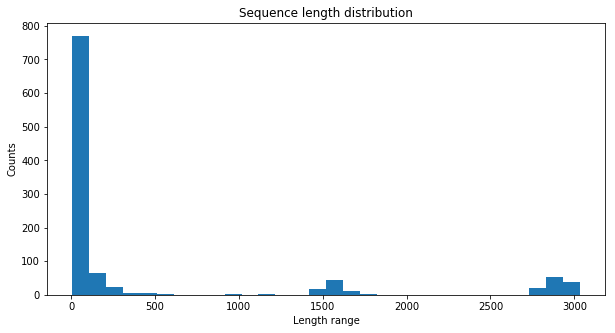

In [3]:
X, A, Y, L = load_rna_ss_dataset(PLT_LOGS=True)

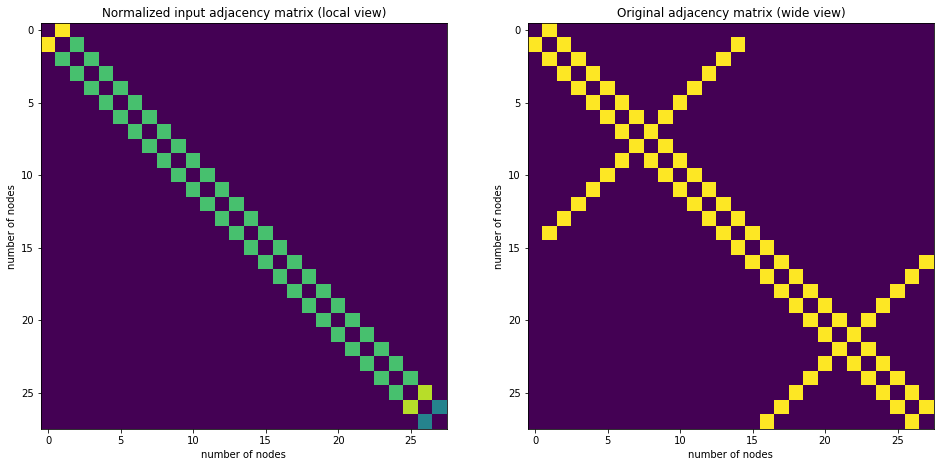

In [4]:
idx = 900
x = X[idx]
a = A[idx].todense()
y = Y[idx].todense()
seq_len = L[idx]   

a = a[:seq_len,:seq_len]
y = y[:seq_len,:seq_len]

# for debuging
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(a)
plt.title("Normalized input adjacency matrix (local view)")
plt.ylabel("number of nodes")
plt.xlabel("number of nodes")
plt.subplot(1,2,2)
plt.imshow(y)
plt.title("Original adjacency matrix (wide view)")
plt.ylabel("number of nodes")
plt.xlabel("number of nodes")
plt.show()

In [5]:
import tensorflow as tf

max_len = HYPER_PARAMS["max_seq_length"]
ae_hidden = HYPER_PARAMS["ae_hidden"]

def weight_bias_vars(in_dim, out_dim):
    init_range = np.sqrt(6.0 / (in_dim + out_dim))
    initial = tf.random_uniform([in_dim, out_dim], minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial)

def ae_layer(x, in_dim, out_dim):
    w = weight_bias_vars(in_dim, out_dim)
    x = tf.matmul(x,w)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def ae_model(a_in):
    encoder = ae_layer(a_in, max_len, ae_hidden)
    decoder = ae_layer(encoder, ae_hidden, max_len)
    return encoder, decoder

def get_pos_weight(mat):
    pos_w = float(mat.shape[0] * mat.shape[0] - mat.sum()) / mat.sum()
    return pos_w

def get_norm(mat):
    norm = mat.shape[0] * mat.shape[0] / float((mat.shape[0] * mat.shape[0] - mat.sum()) * 2)
    return norm

placeholders = {
    "X" : tf.sparse_placeholder(tf.float32),
    "A" : tf.sparse_placeholder(tf.float32),
    "Y" : tf.sparse_placeholder(tf.float32),
    "pos_weight": tf.placeholder(tf.float32),
    "norm" : tf.placeholder(tf.float32)
}

adj_in = tf.reshape(tf.sparse_tensor_to_dense(placeholders["A"] , validate_indices=False) ,
                    (max_len, max_len)) 

encoder, decoder = ae_model(adj_in)
decoder_flatten = tf.reshape(decoder, [-1])
decoder_sigmoid = tf.nn.sigmoid(decoder)

In [6]:
class OptimizerAE(object):
    def __init__(self, preds, labels, pos_weight, norm, lr):
        preds_sub = preds
        labels_sub = labels

        self.cost = norm * tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=preds_sub,
                                                                                    targets=labels_sub, 
                                                                                    pos_weight=pos_weight))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate = lr) # Adam Optimizer
        self.opt_op = self.optimizer.minimize(self.cost)
        self.grads_vars = self.optimizer.compute_gradients(self.cost)
        self.correct_prediction = tf.equal(tf.cast(tf.greater_equal(tf.sigmoid(preds_sub), 0.5), tf.int32), 
                                           tf.cast(labels_sub, tf.int32))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

opt = OptimizerAE(preds= decoder_flatten,
                  labels= tf.reshape(tf.sparse_tensor_to_dense(placeholders["Y"] , validate_indices=False) , [-1]),
                  pos_weight = placeholders["pos_weight"],
                  norm = placeholders["norm"],
                  lr = HYPER_PARAMS["learning_rate"])

In [7]:
# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
save_dir = HYPER_PARAMS["ae_model_dir"]
saver = tf.train.Saver()
checkpoint_path = os.path.join(save_dir, "ae_model")
ckpt = tf.train.get_checkpoint_state(save_dir)

IS_LOAD = True
if IS_LOAD and ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("model_exist")
    

INFO:tensorflow:Restoring parameters from ae_model/ae_model
model_exist


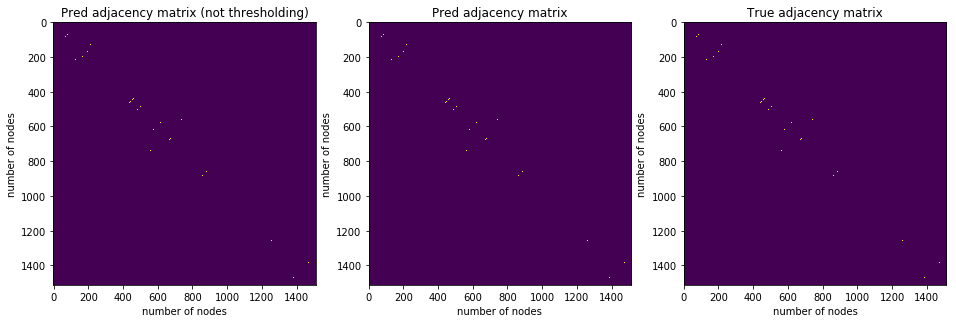

>> test acc :  1.0


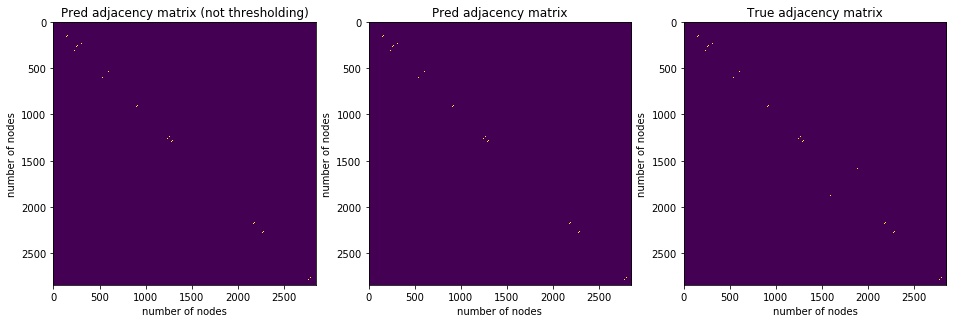

>> test acc :  0.9999887


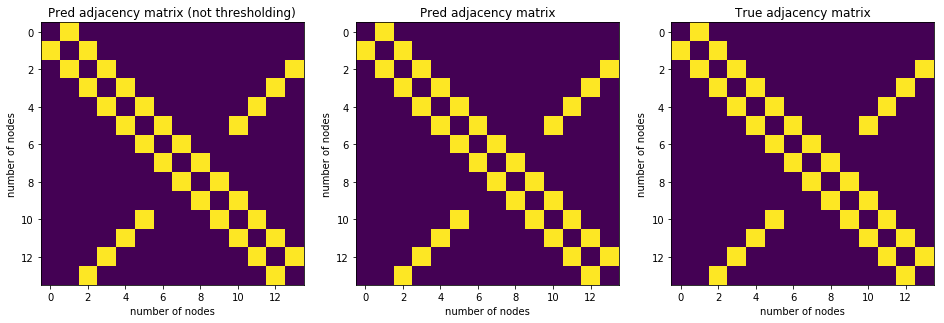

>> test acc :  1.0


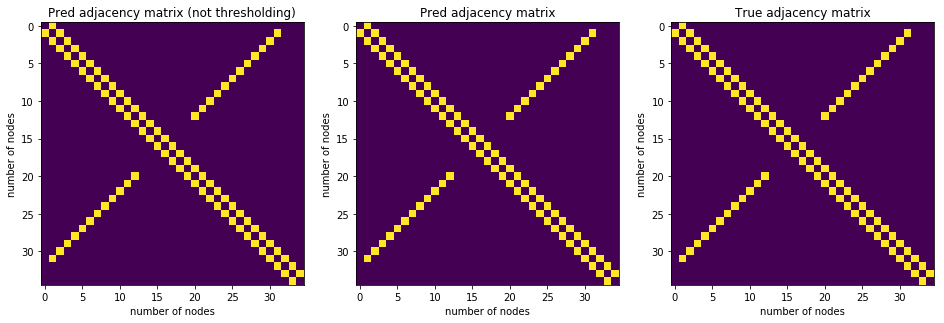

>> test acc :  1.0


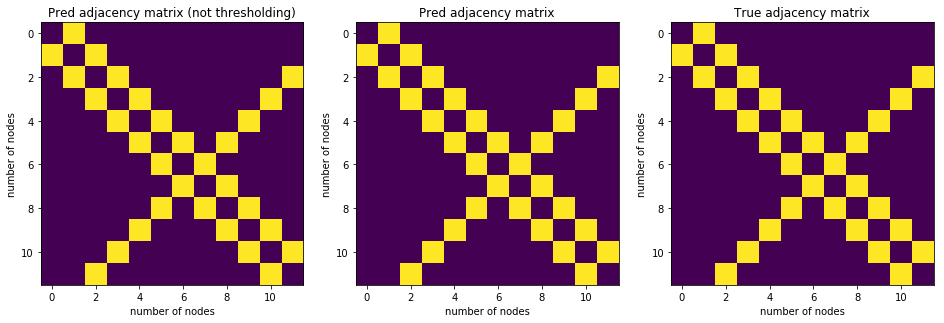

>> test acc :  1.0


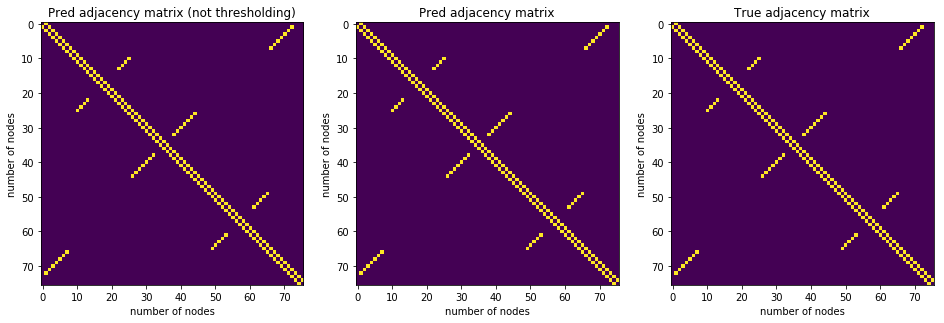

>> test acc :  1.0


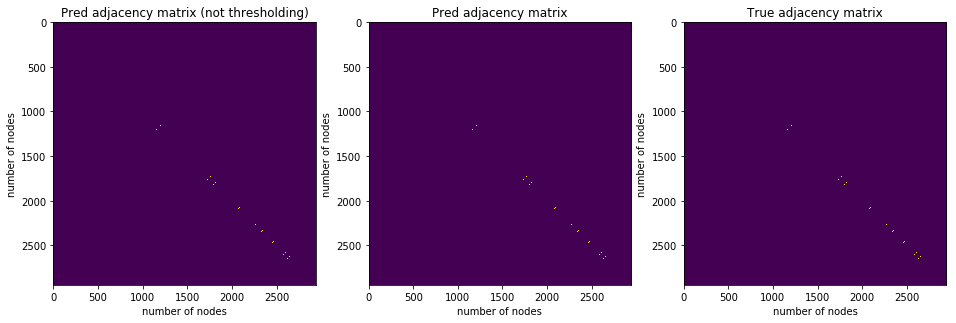

>> test acc :  1.0


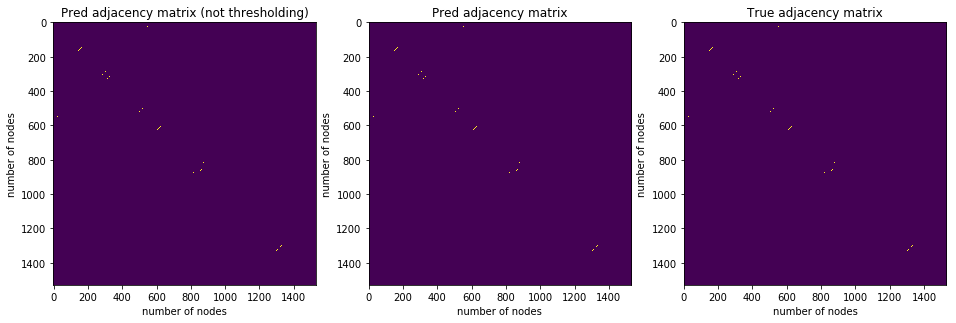

>> test acc :  1.0


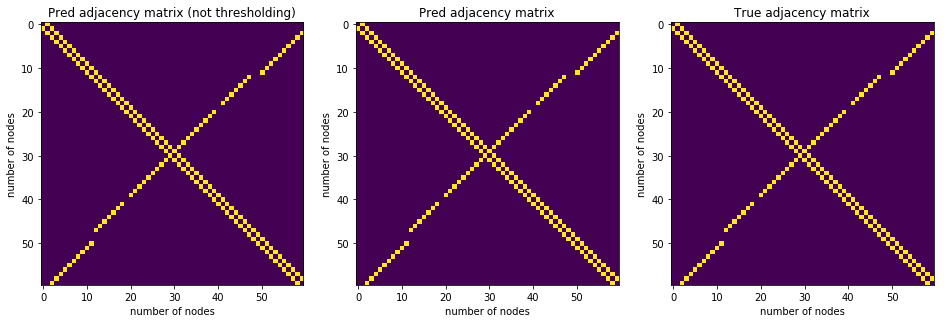

>> test acc :  1.0


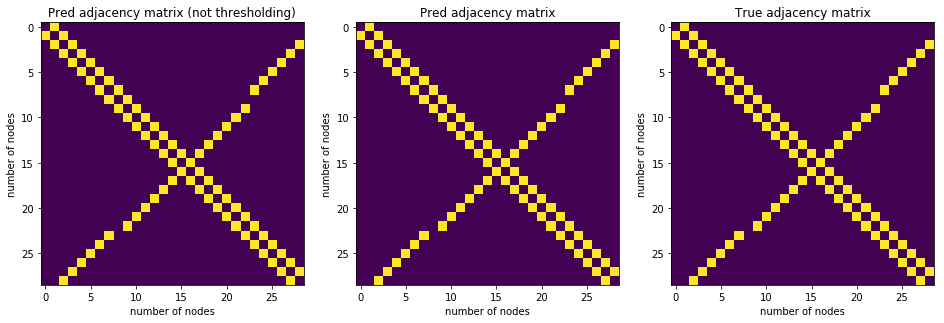

>> test acc :  1.0


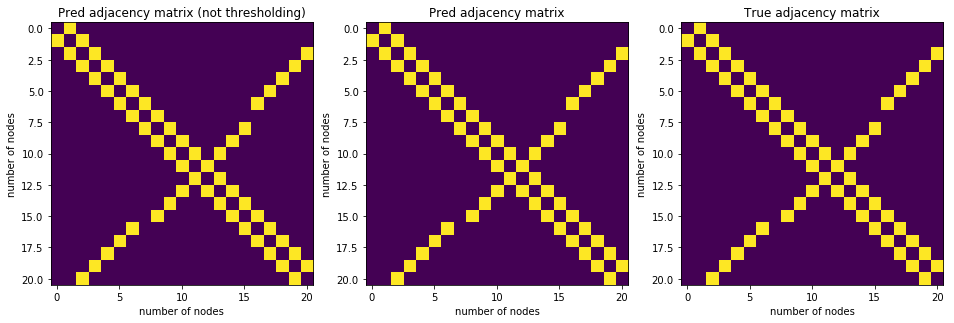

>> test acc :  1.0


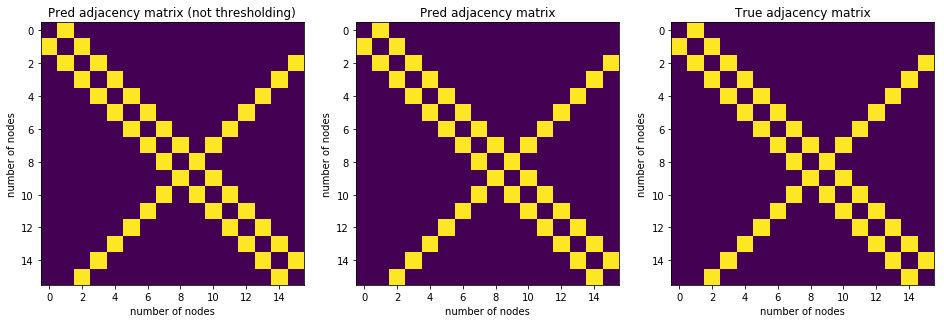

>> test acc :  1.0


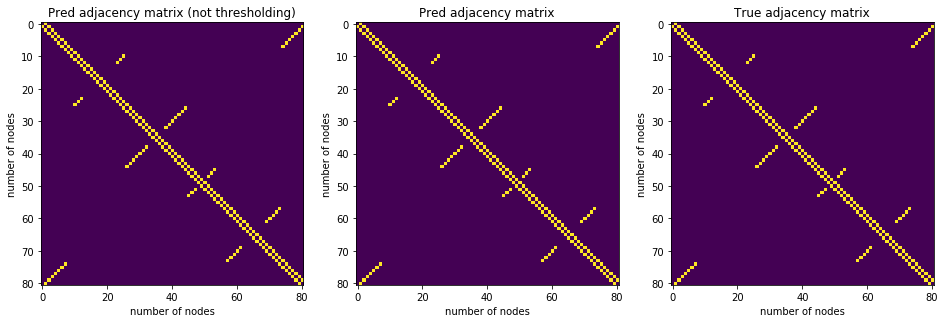

>> test acc :  1.0


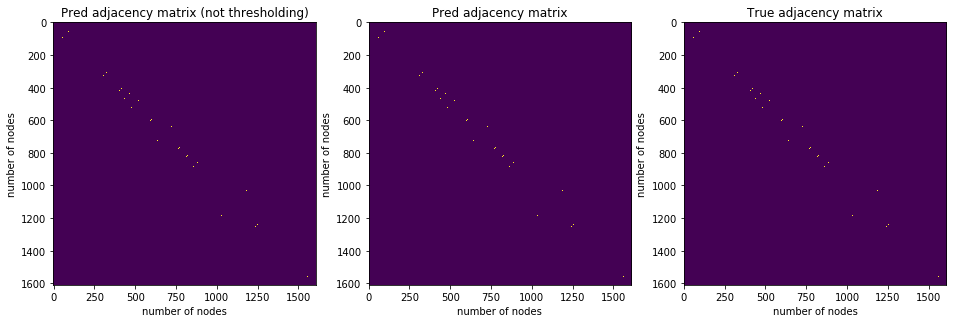

>> test acc :  0.9999991


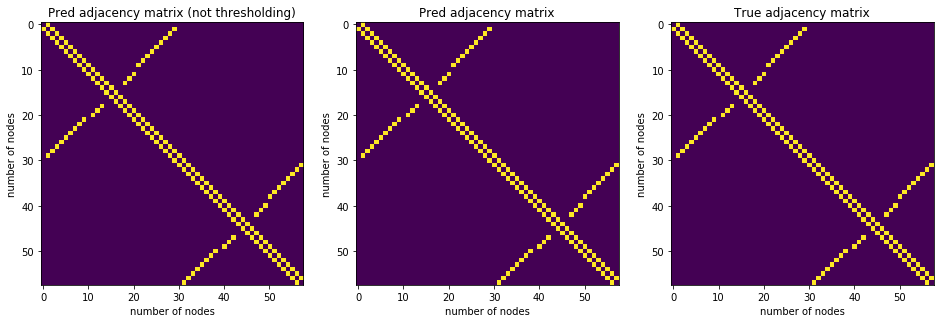

>> test acc :  1.0


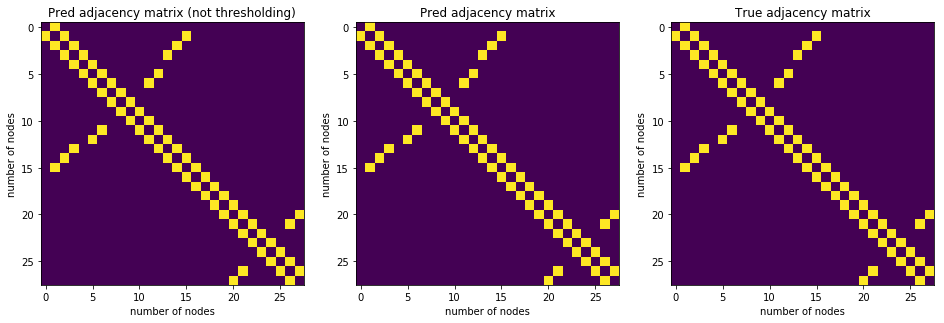

>> test acc :  1.0


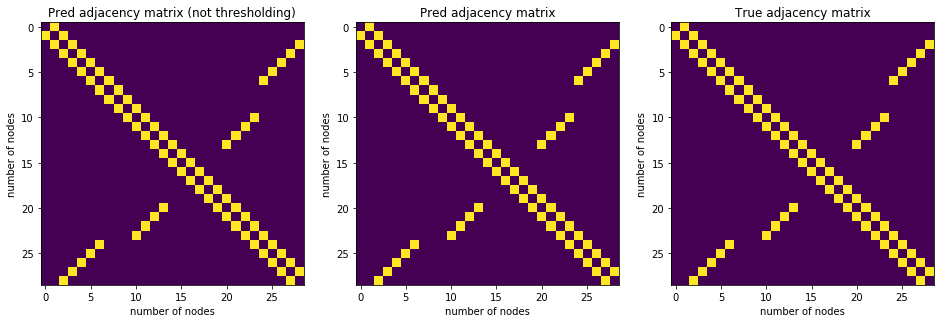

>> test acc :  1.0


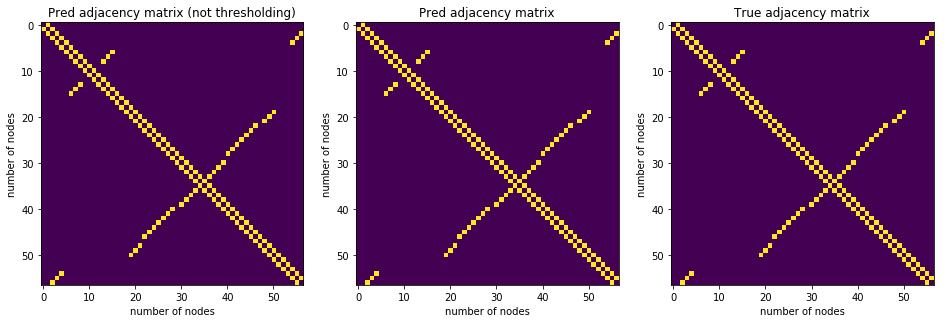

>> test acc :  1.0


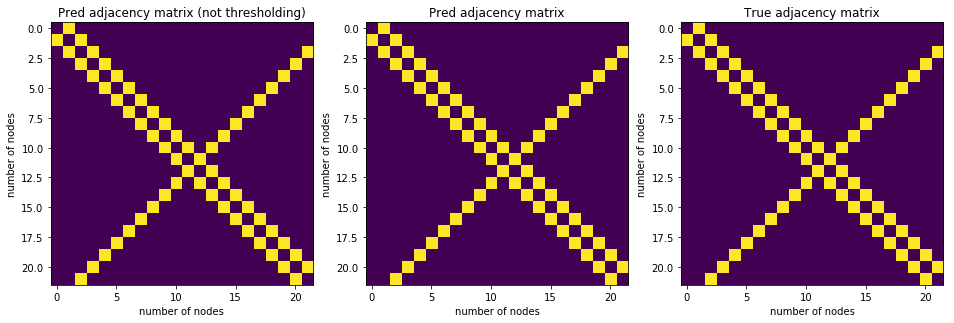

>> test acc :  1.0


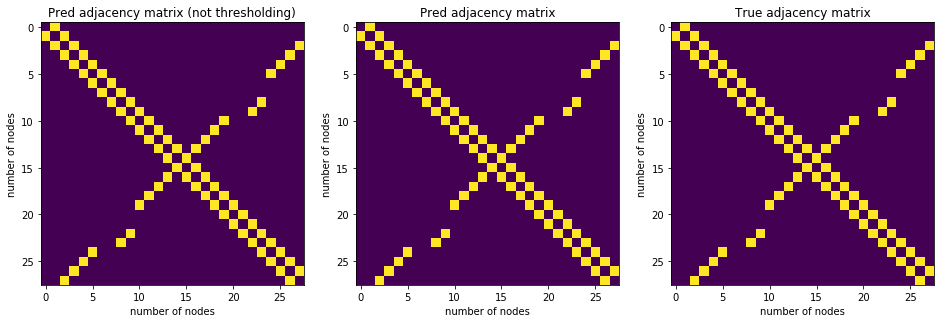

>> test acc :  1.0


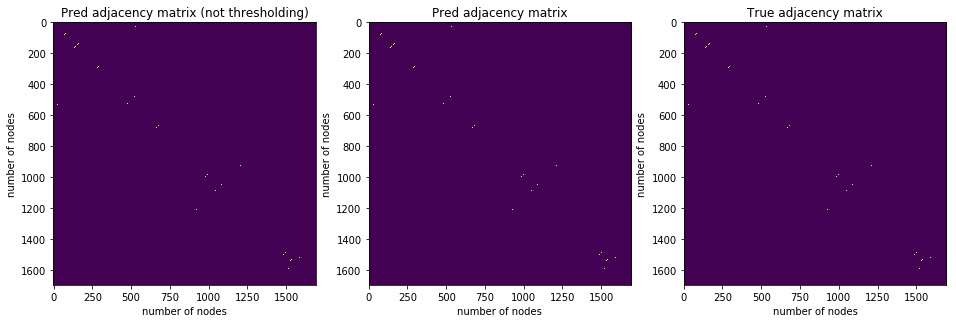

>> test acc :  0.9999993


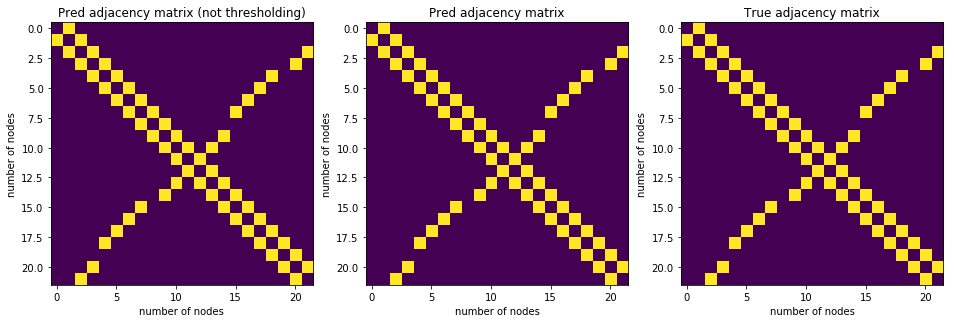

>> test acc :  1.0


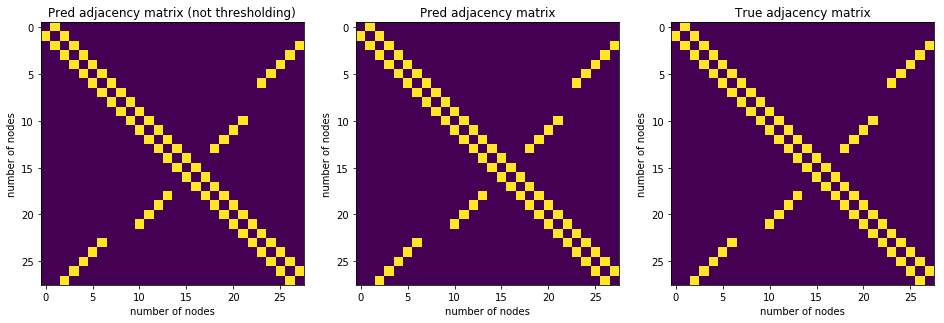

>> test acc :  1.0


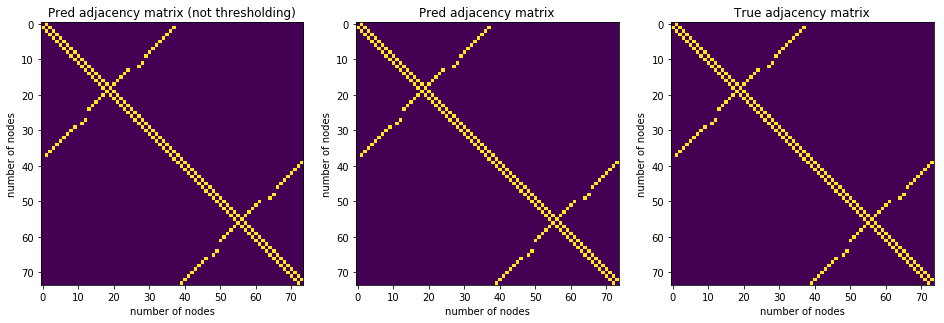

>> test acc :  1.0


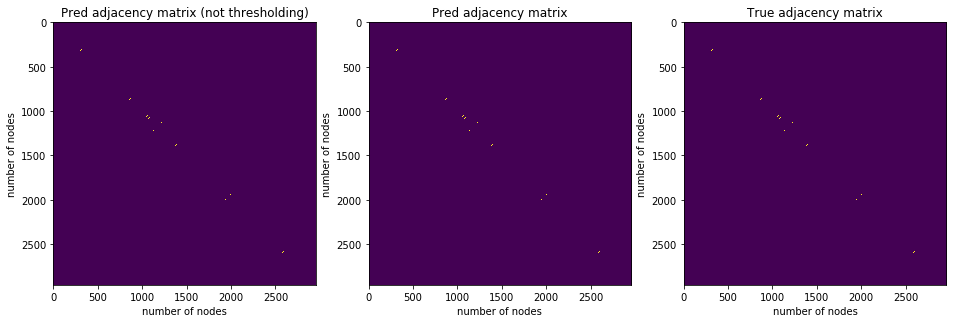

>> test acc :  1.0


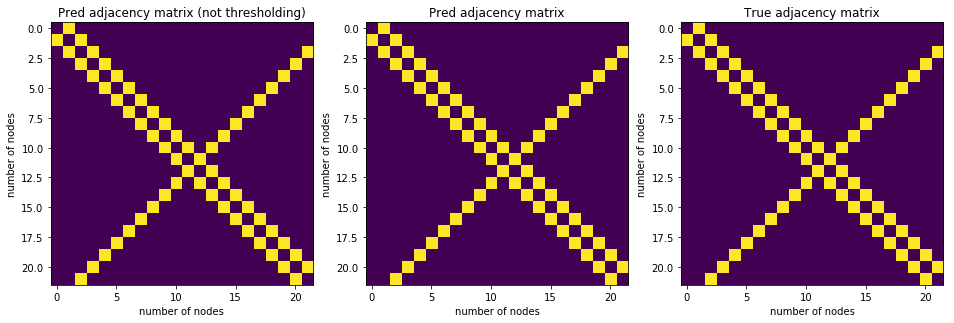

>> test acc :  1.0


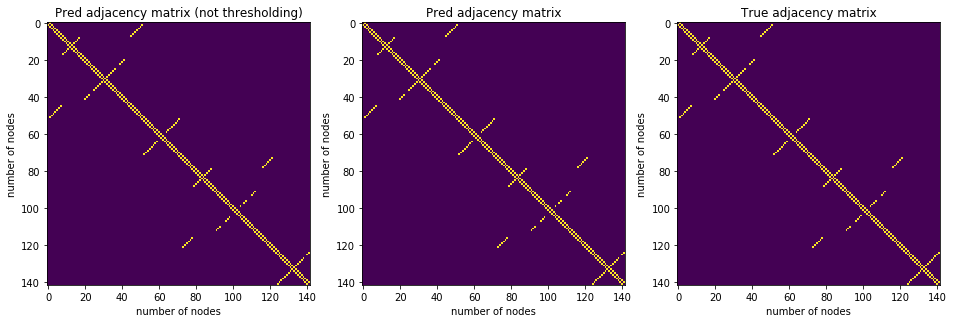

>> test acc :  0.9999998


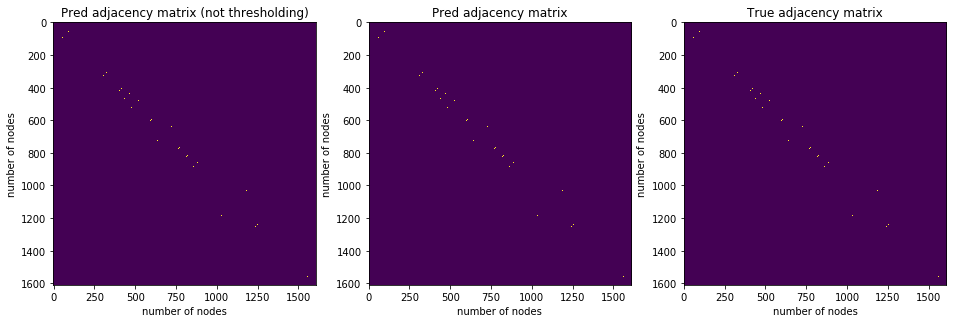

>> test acc :  0.9999992


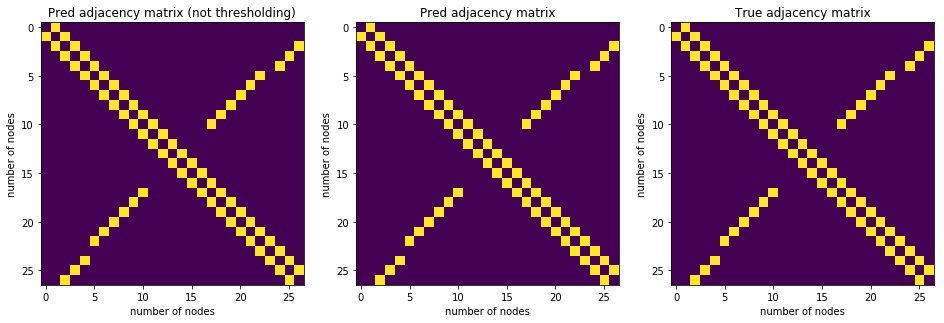

>> test acc :  1.0


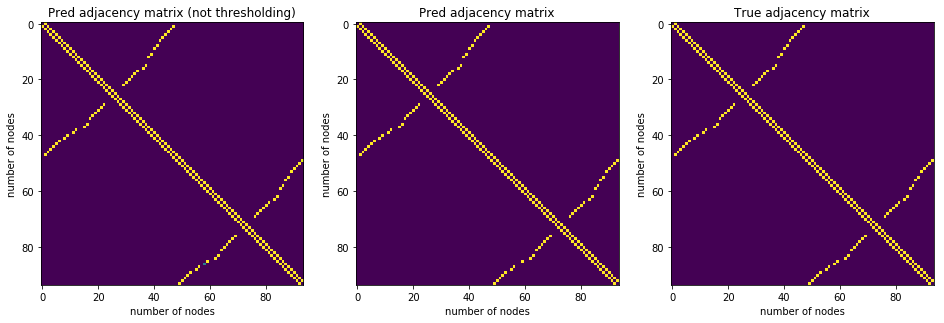

>> test acc :  0.99999994


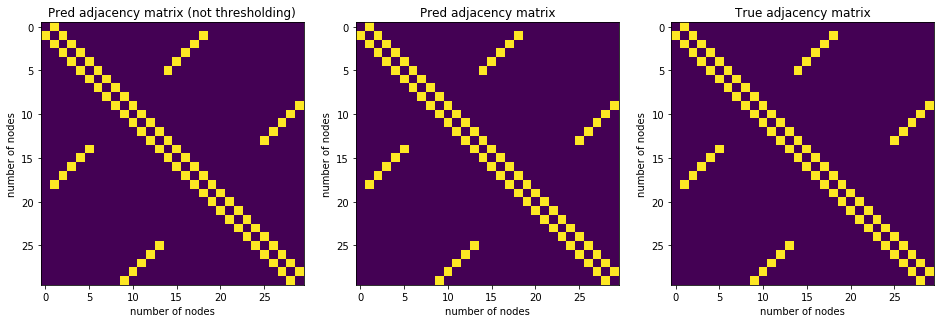

>> test acc :  1.0


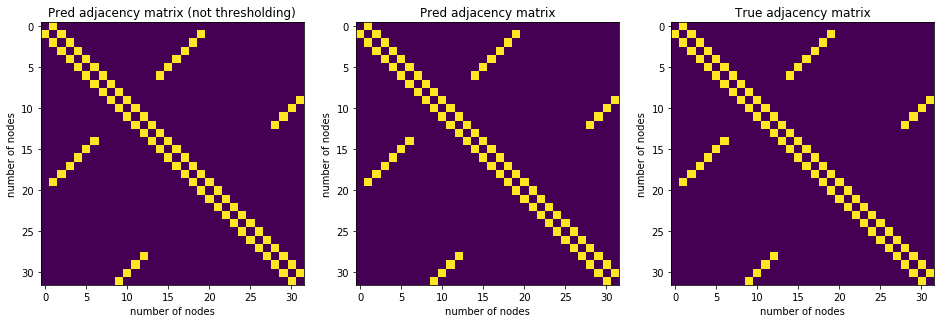

>> test acc :  1.0


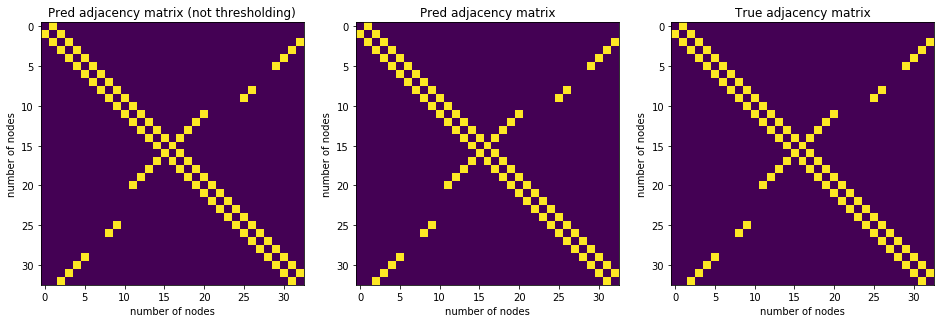

>> test acc :  1.0


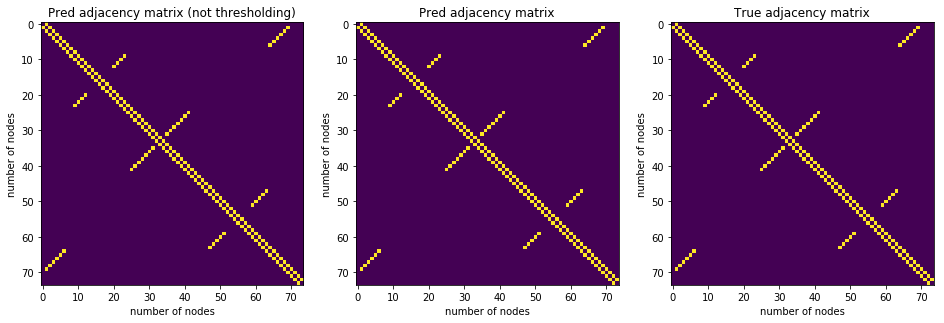

>> test acc :  1.0


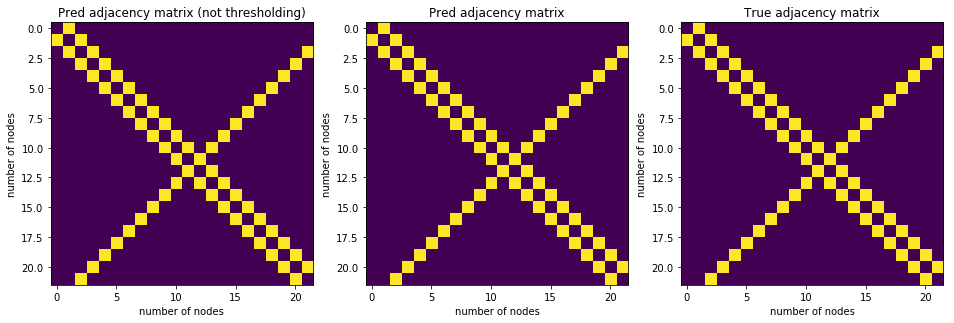

>> test acc :  1.0


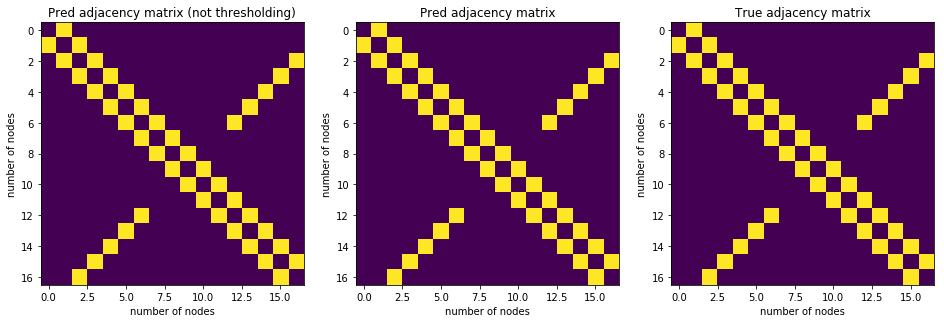

>> test acc :  1.0


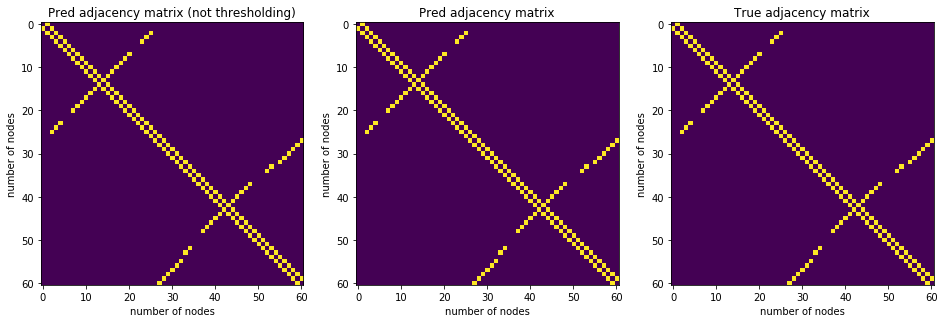

>> test acc :  1.0


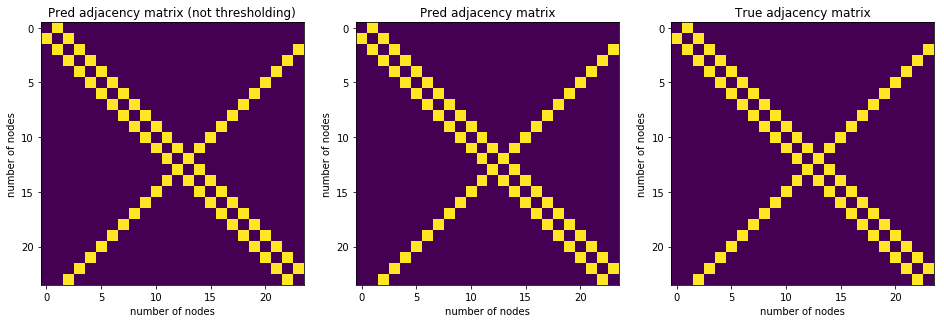

>> test acc :  1.0


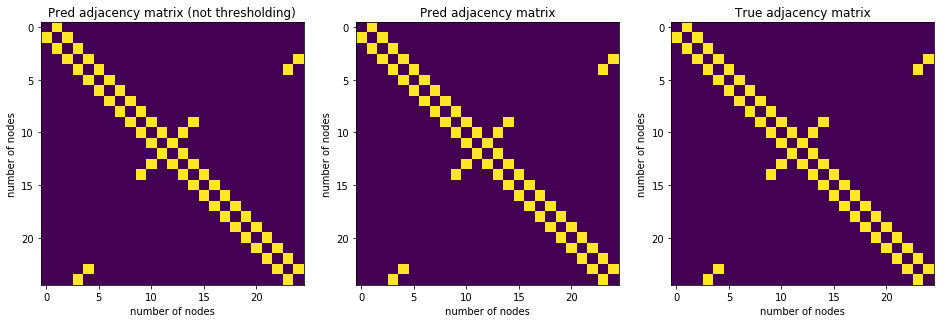

>> test acc :  1.0


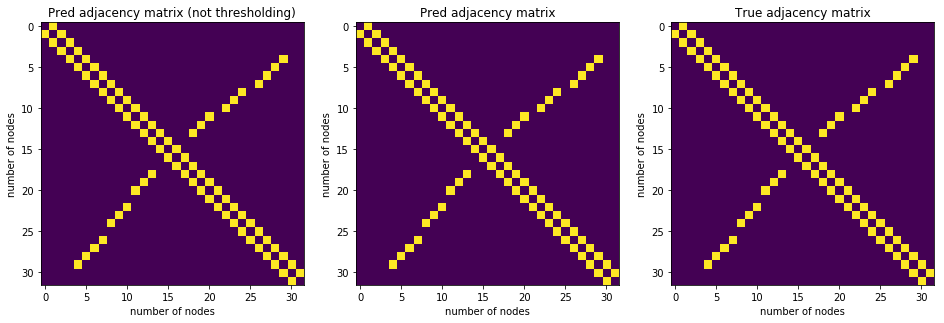

>> test acc :  1.0


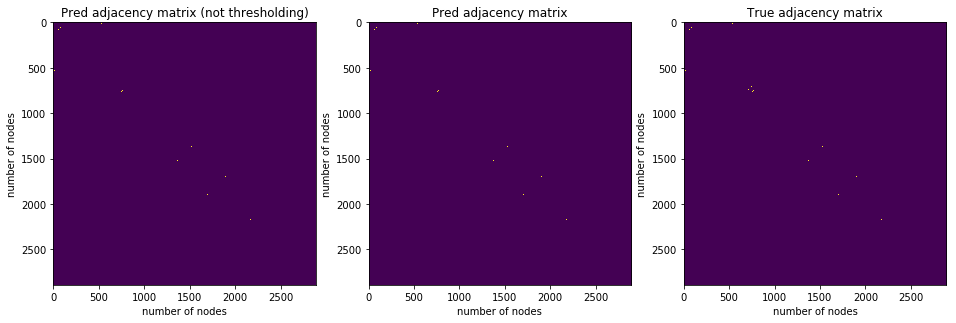

>> test acc :  0.9999888


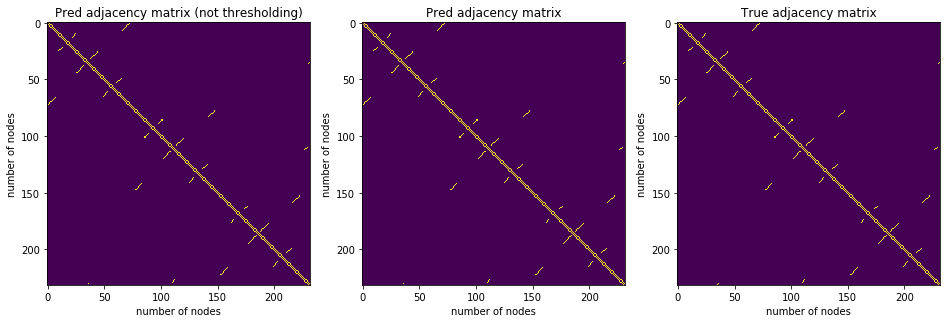

>> test acc :  0.9999999


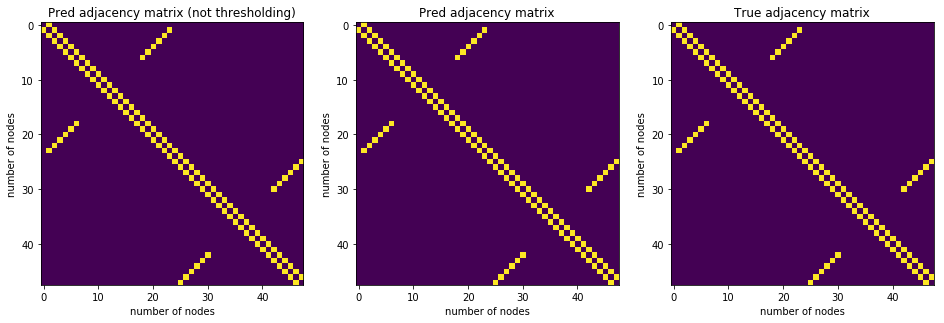

>> test acc :  1.0


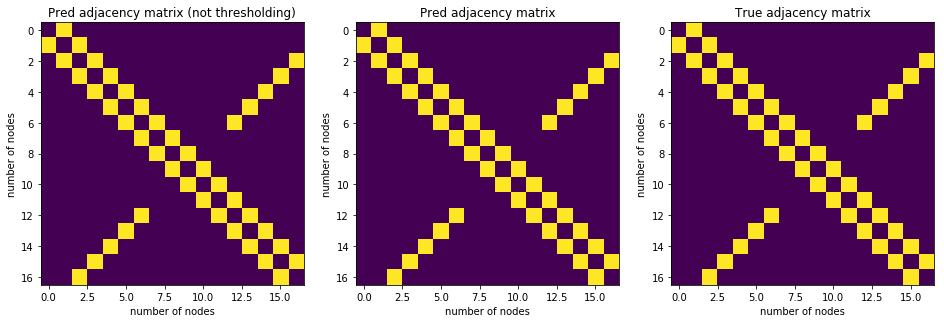

>> test acc :  1.0


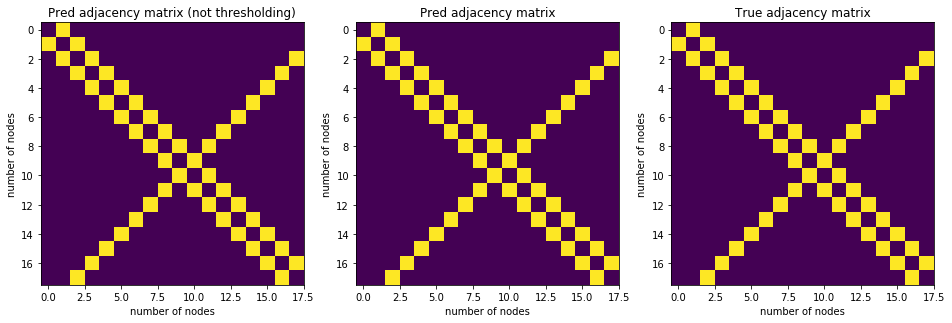

>> test acc :  1.0


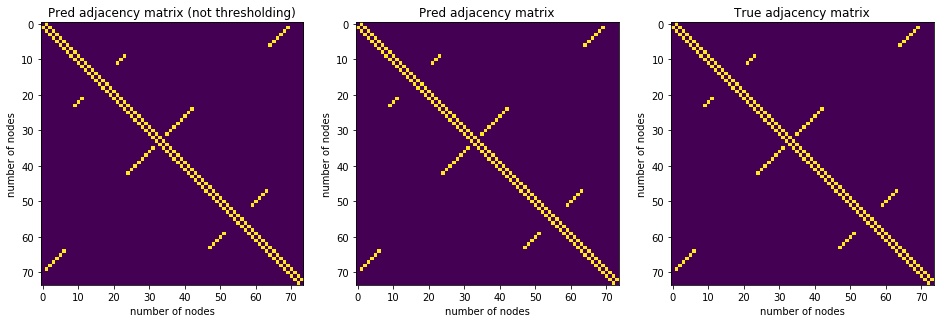

>> test acc :  1.0


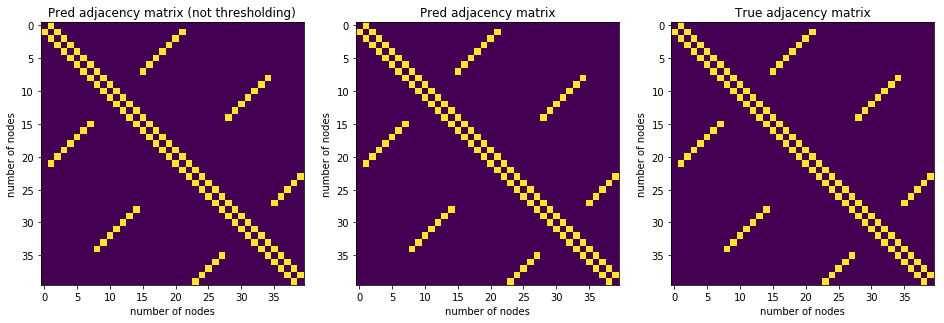

>> test acc :  1.0


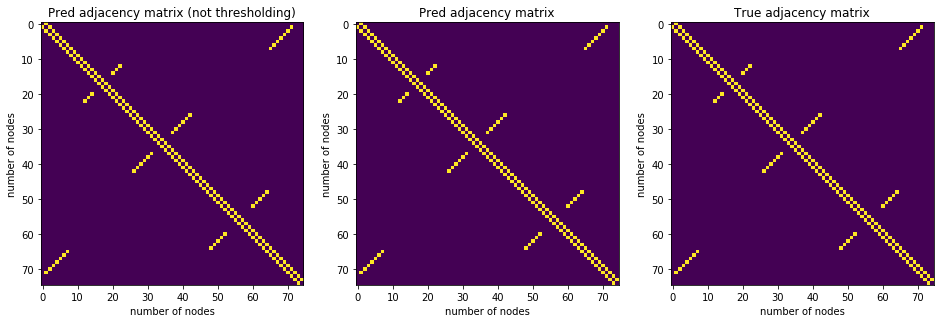

>> test acc :  1.0


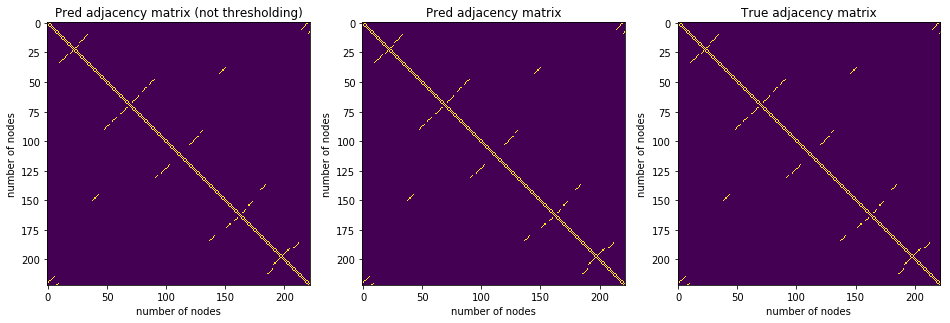

>> test acc :  1.0


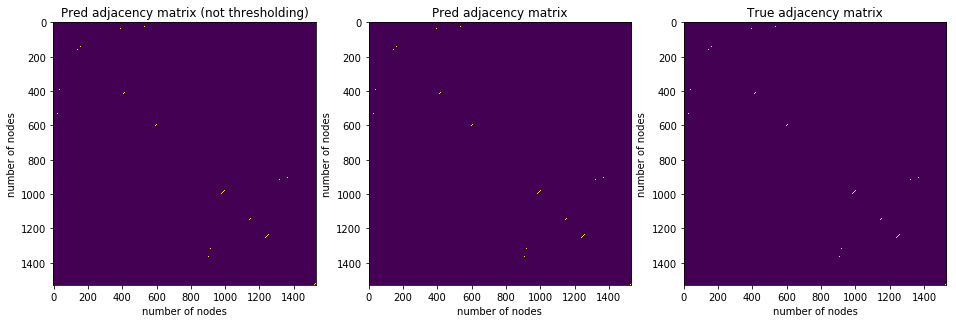

>> test acc :  1.0


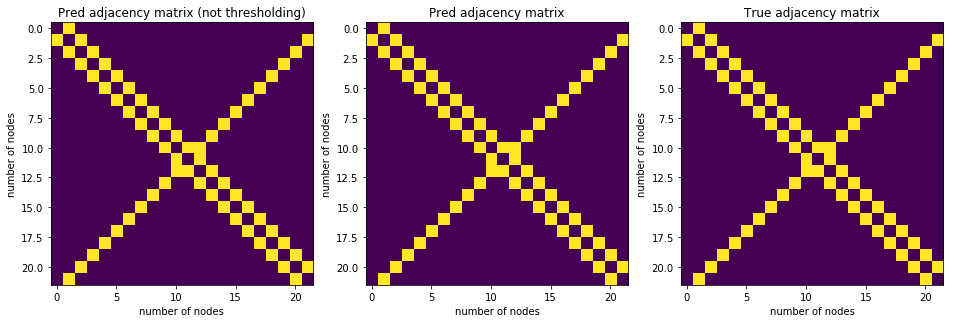

>> test acc :  1.0


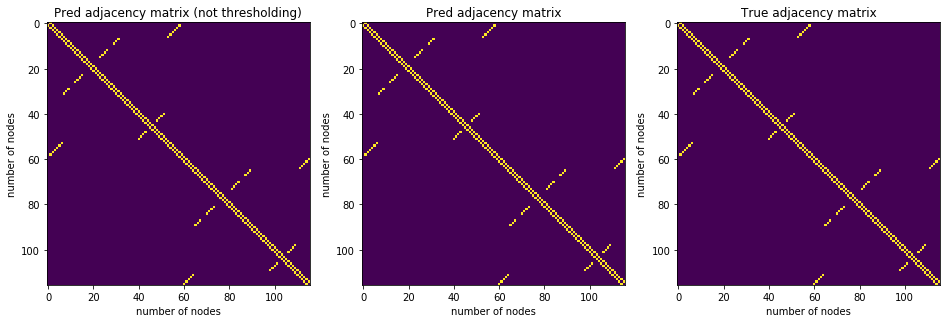

>> test acc :  1.0


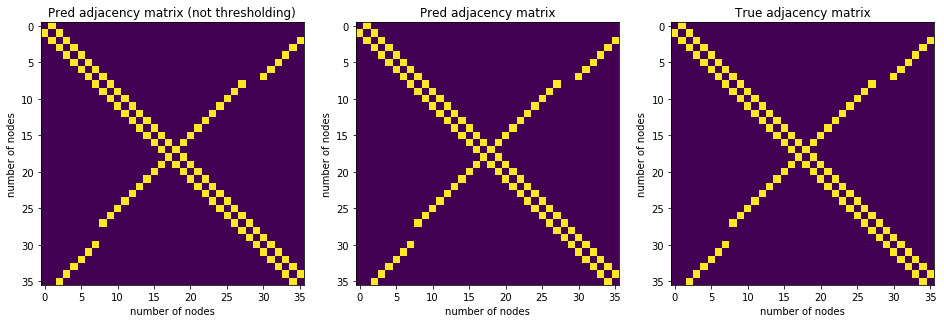

>> test acc :  1.0


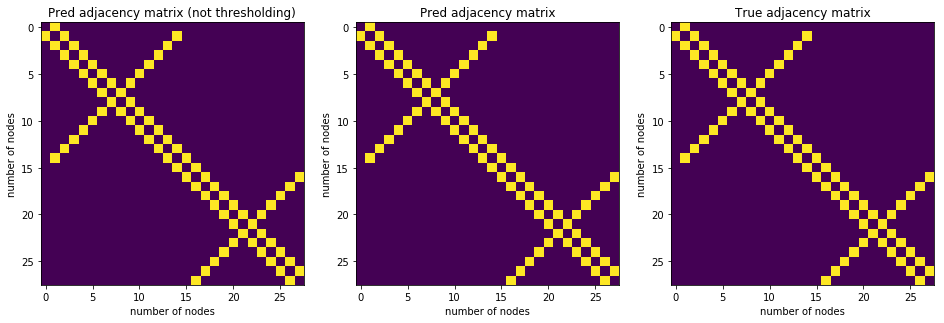

>> test acc :  1.0


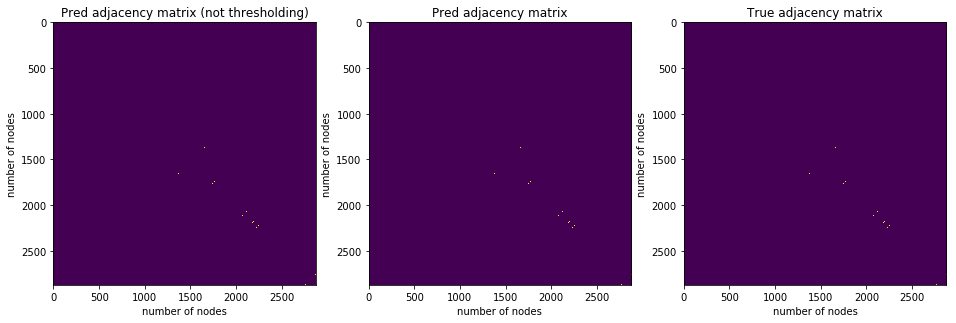

>> test acc :  1.0


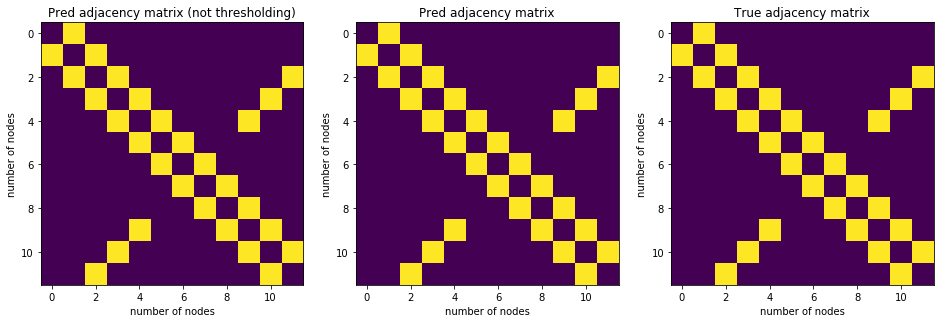

>> test acc :  1.0


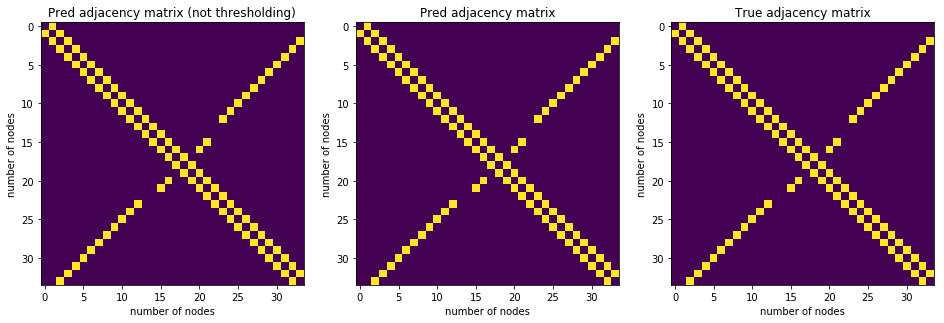

>> test acc :  1.0


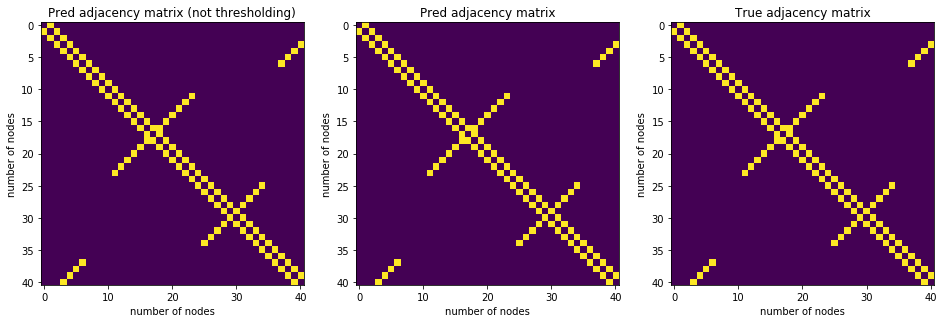

>> test acc :  1.0


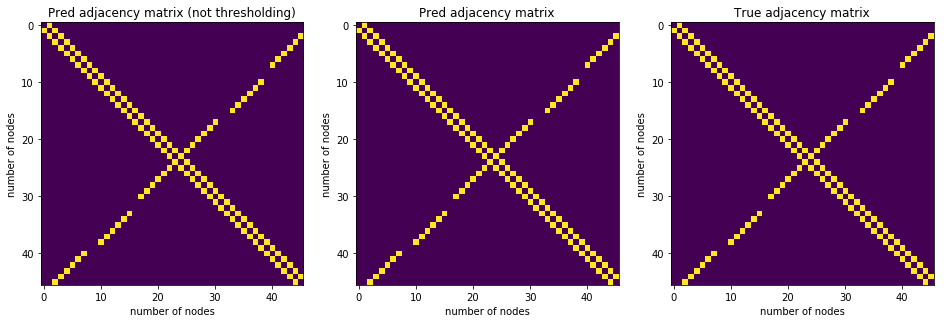

>> test acc :  1.0


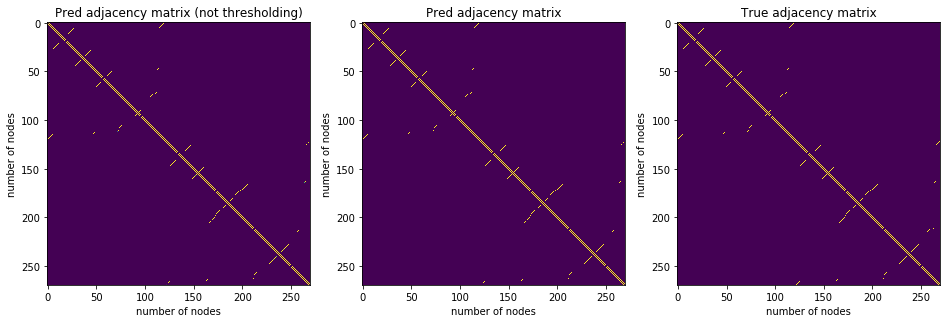

>> test acc :  0.9999994


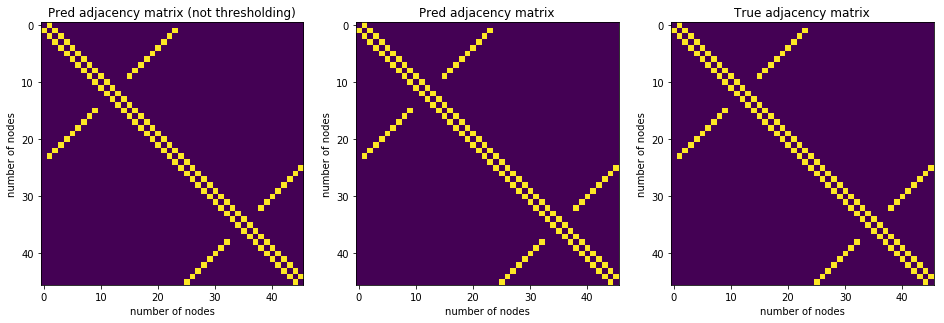

>> test acc :  1.0


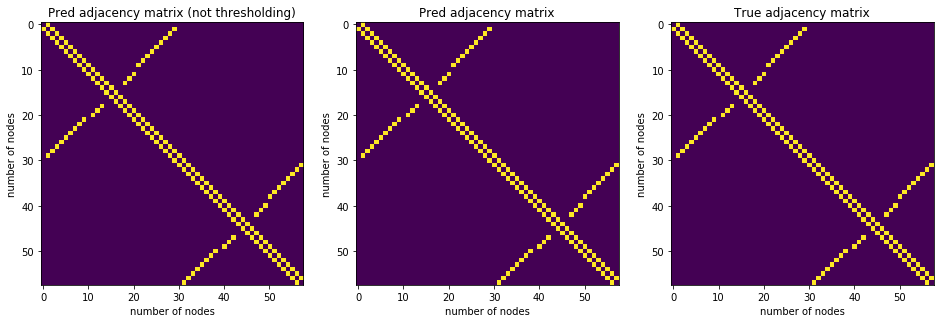

>> test acc :  1.0


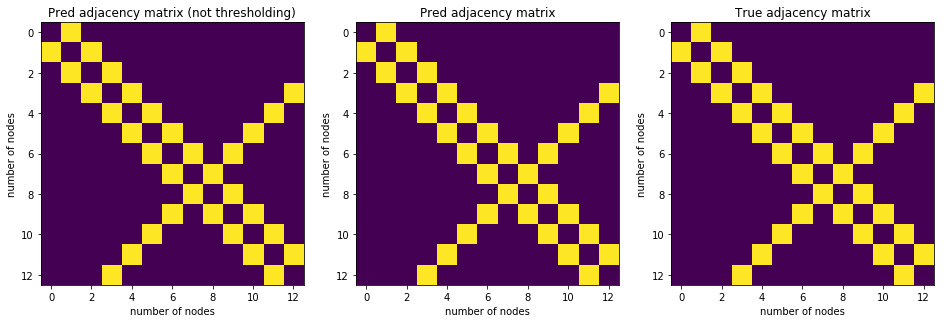

>> test acc :  1.0


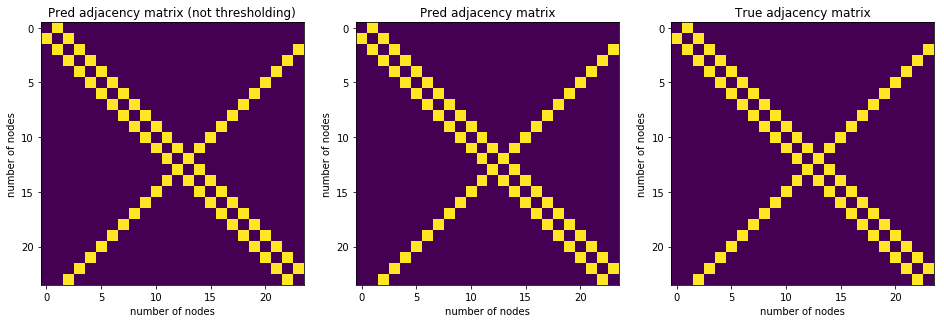

>> test acc :  1.0


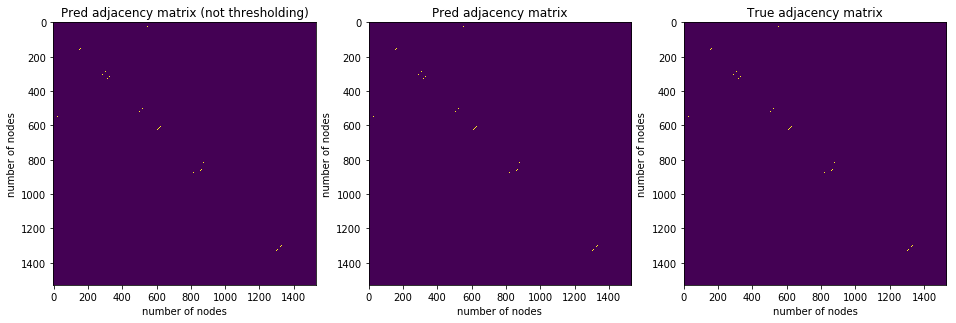

>> test acc :  1.0


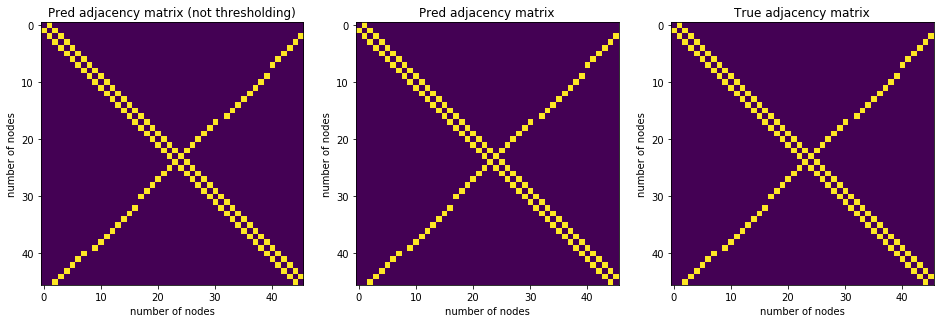

>> test acc :  1.0


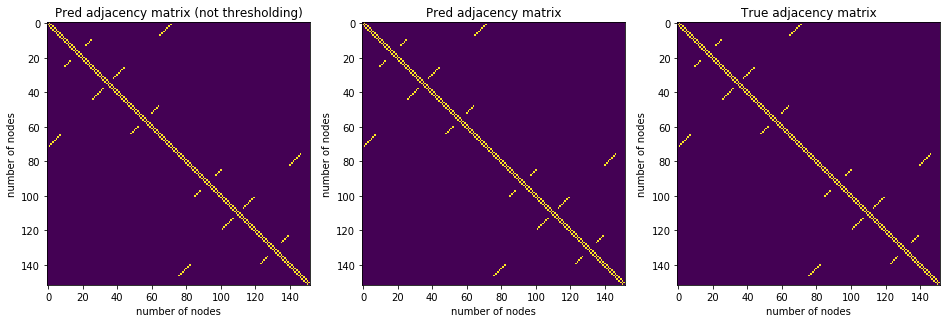

>> test acc :  1.0


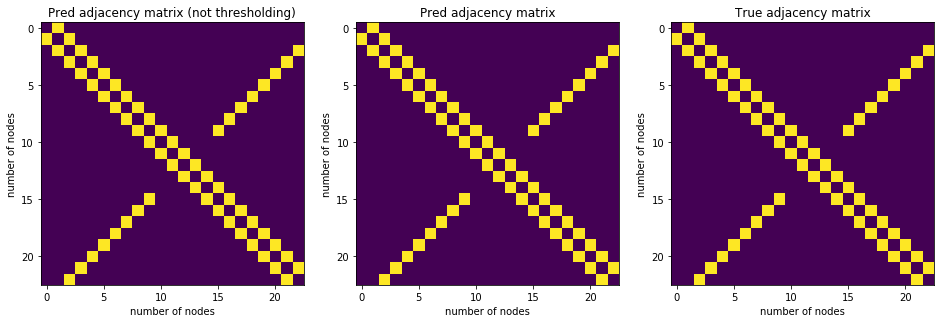

>> test acc :  1.0


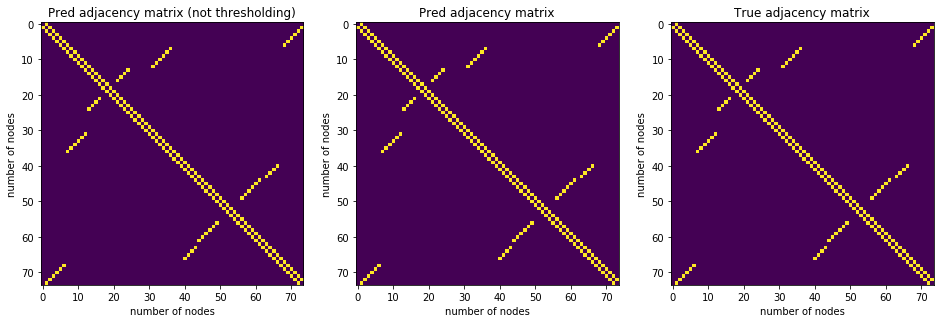

>> test acc :  1.0


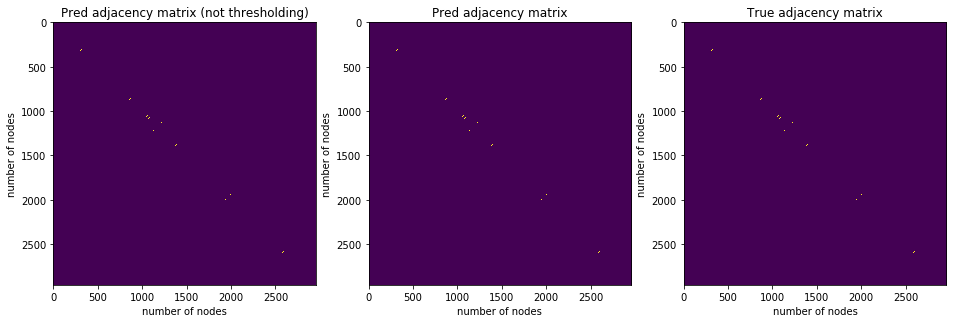

>> test acc :  1.0


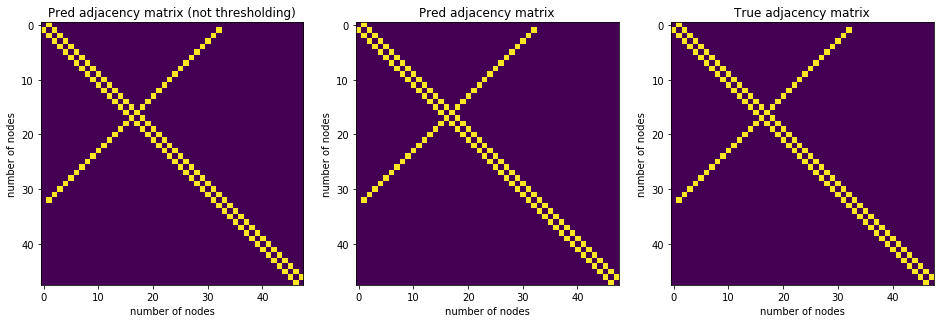

>> test acc :  1.0


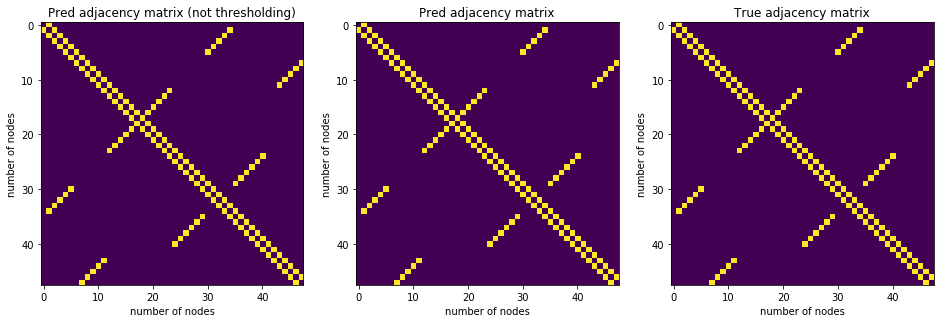

>> test acc :  1.0


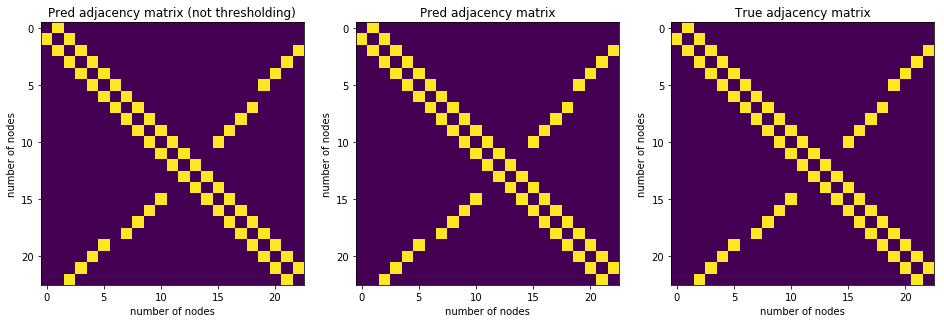

>> test acc :  1.0


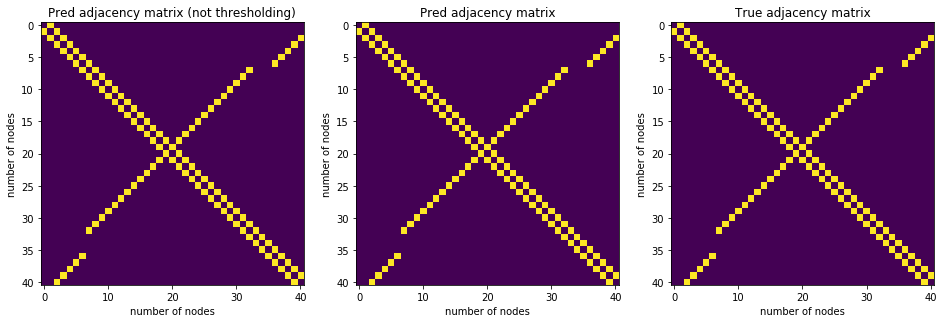

>> test acc :  1.0


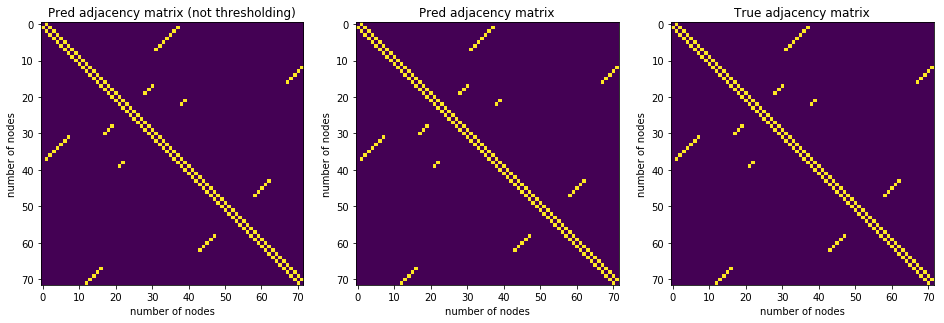

>> test acc :  1.0


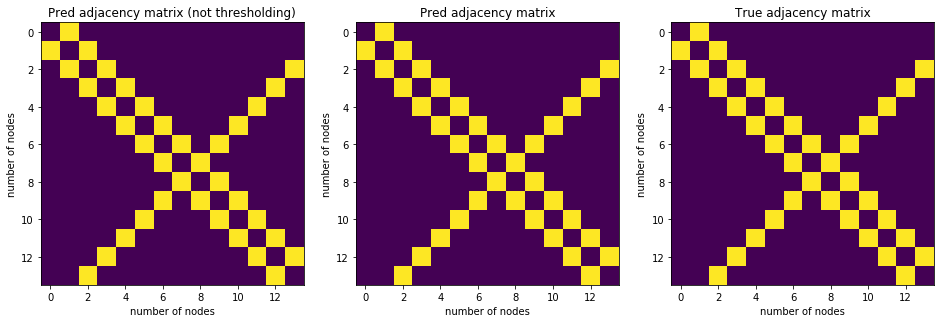

>> test acc :  1.0


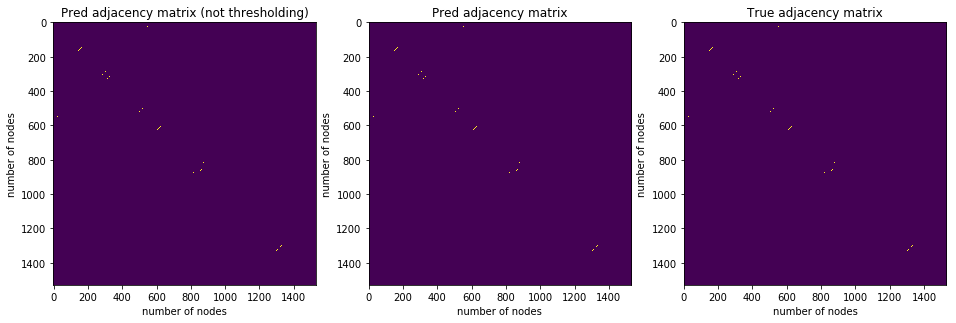

>> test acc :  1.0


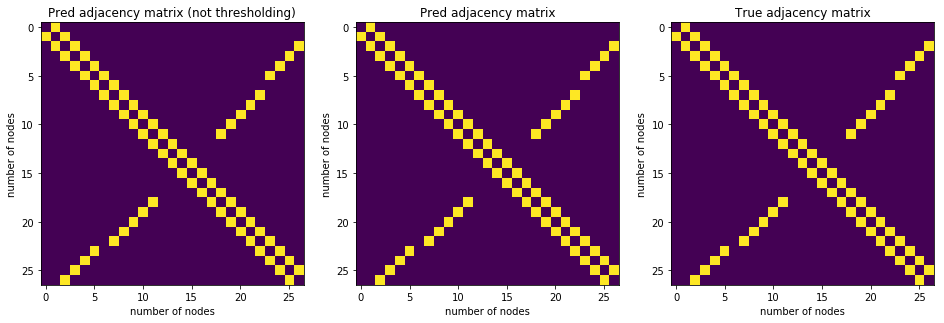

>> test acc :  1.0


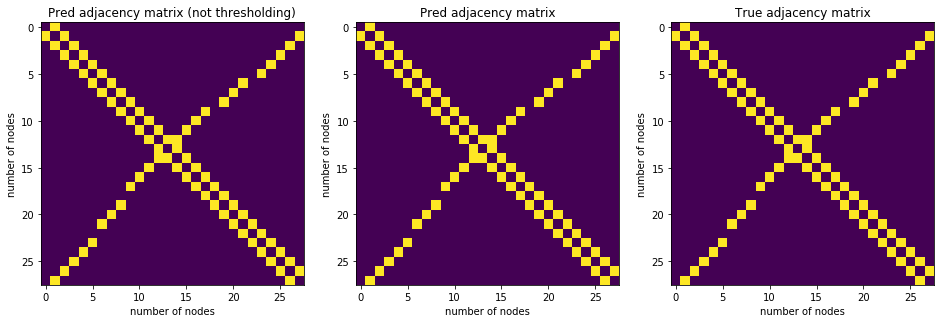

>> test acc :  1.0


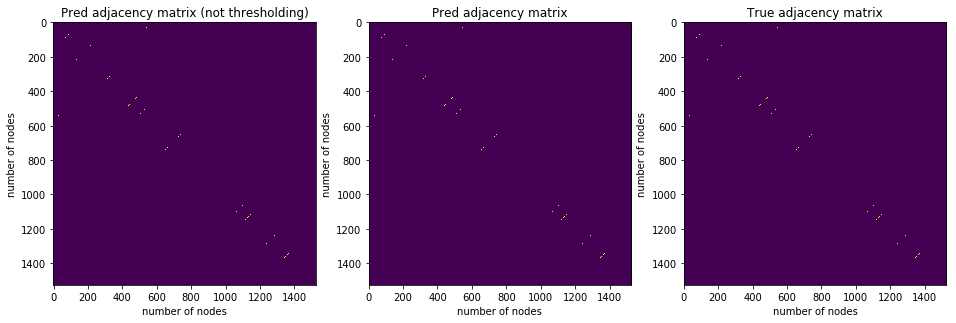

>> test acc :  1.0


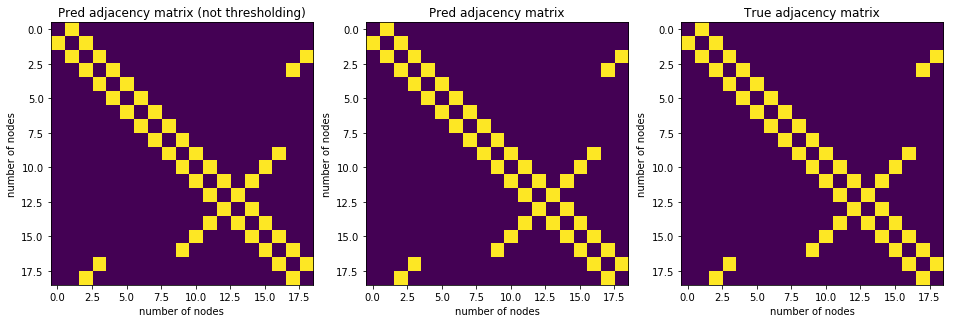

>> test acc :  1.0


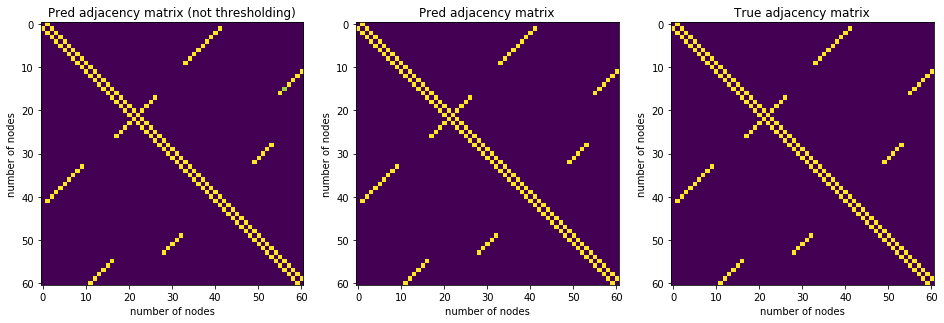

>> test acc :  1.0


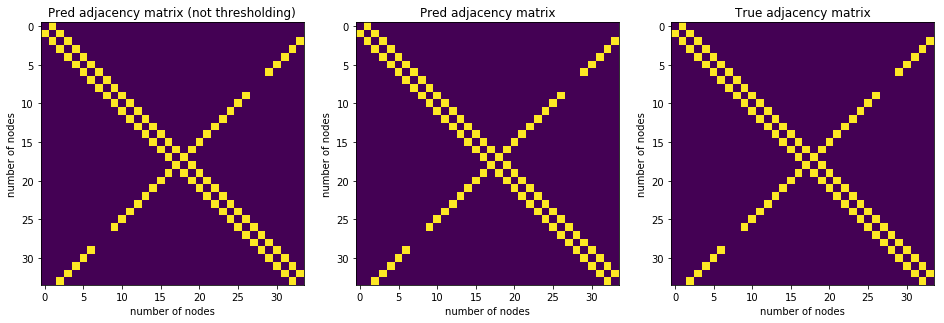

>> test acc :  1.0


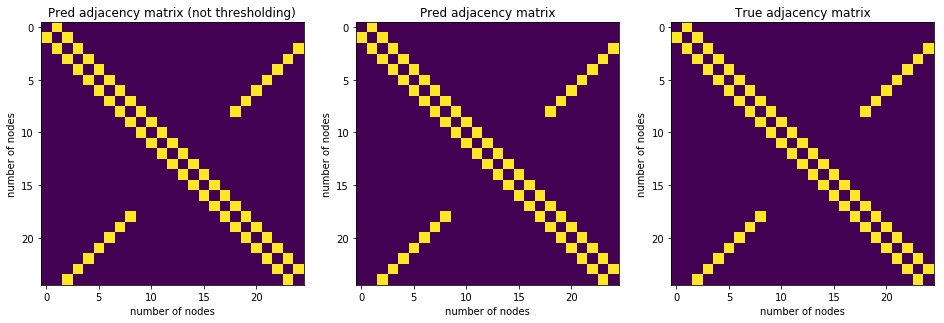

>> test acc :  1.0


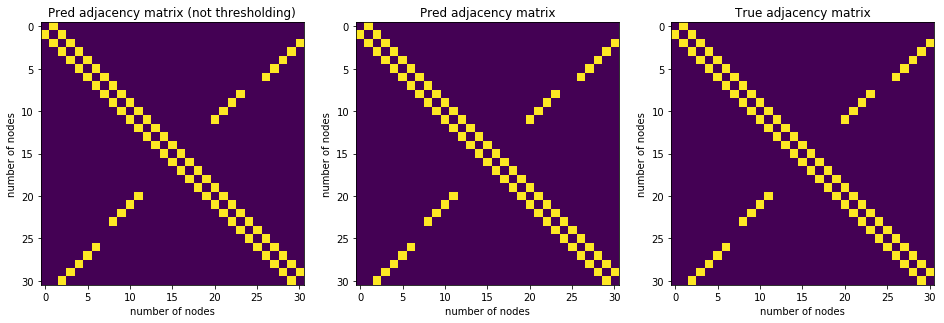

>> test acc :  1.0


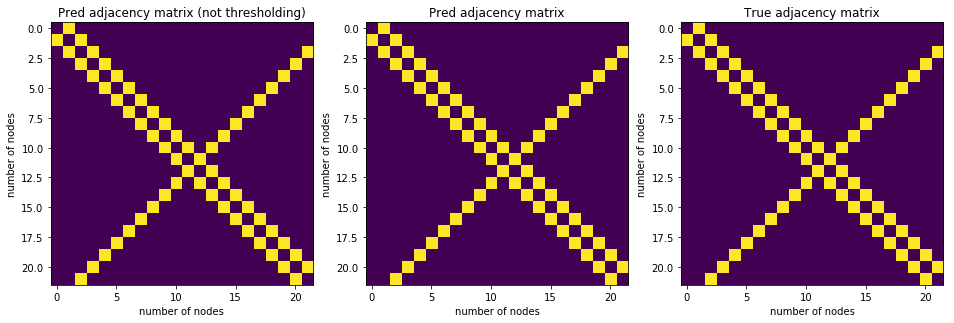

>> test acc :  1.0


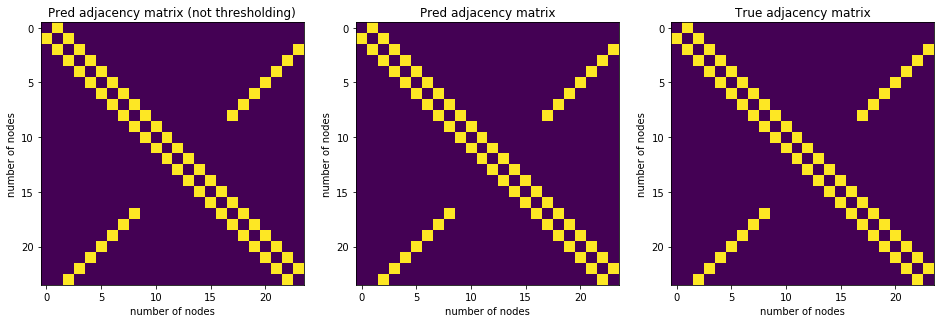

>> test acc :  1.0


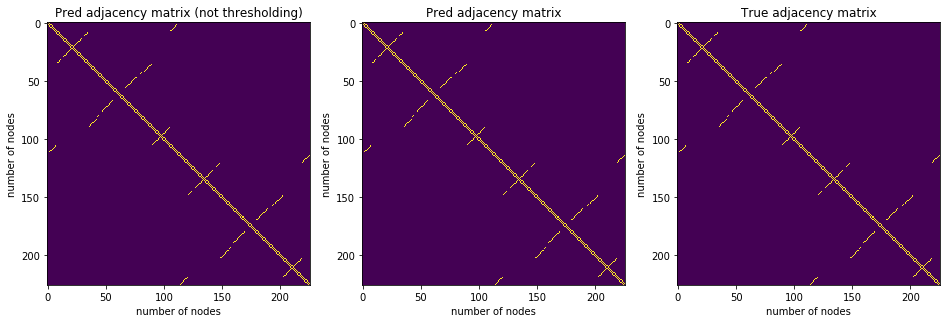

>> test acc :  1.0


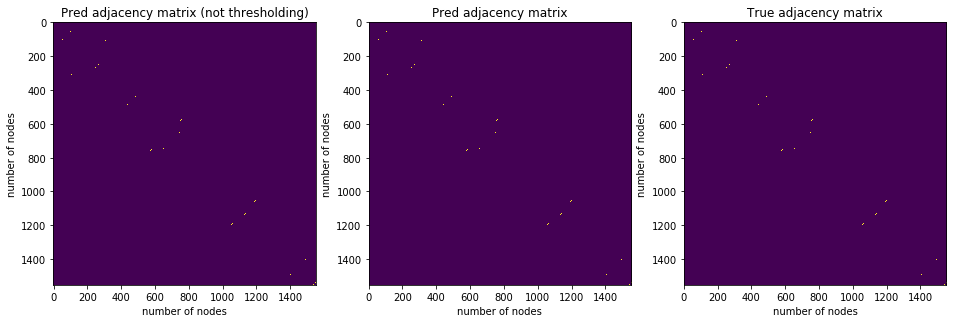

>> test acc :  1.0


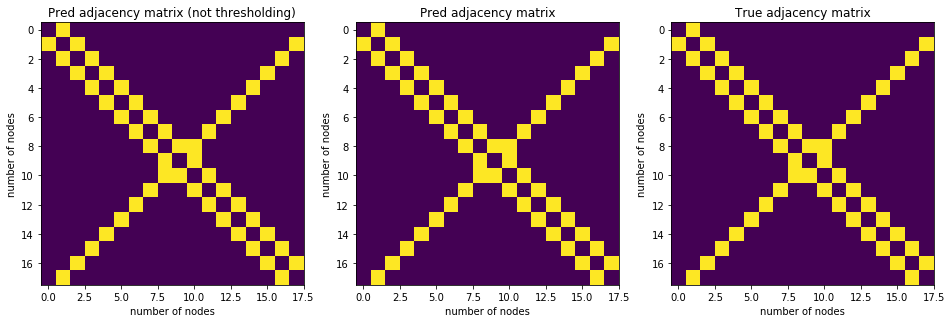

>> test acc :  1.0


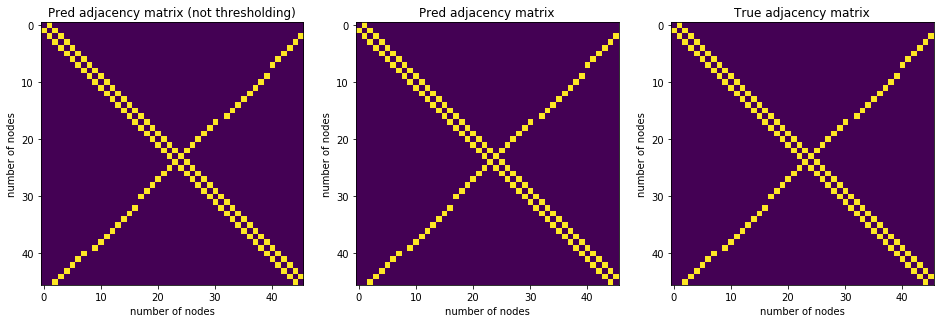

>> test acc :  1.0


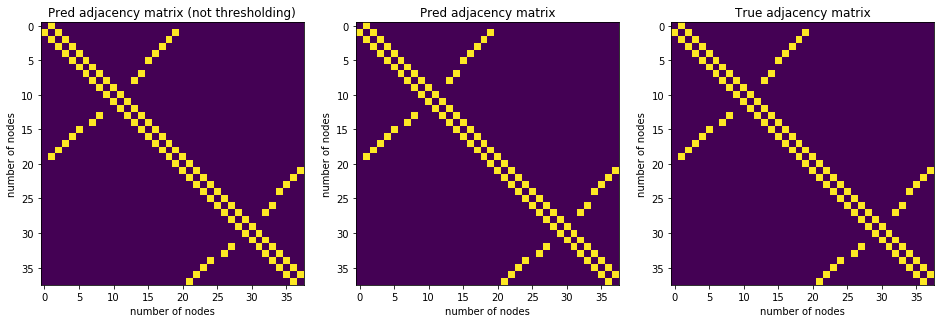

>> test acc :  1.0


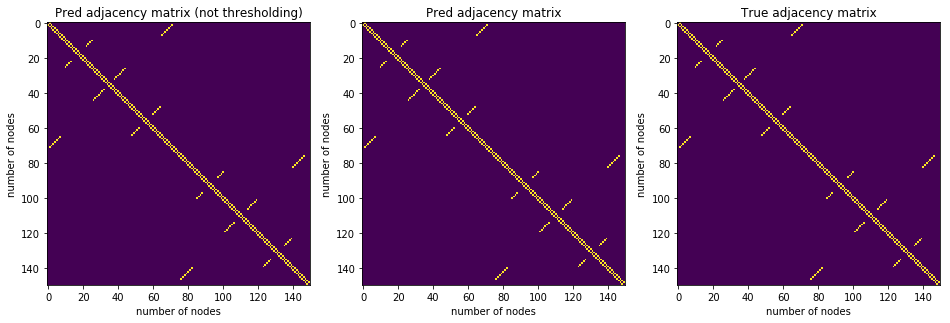

>> test acc :  1.0


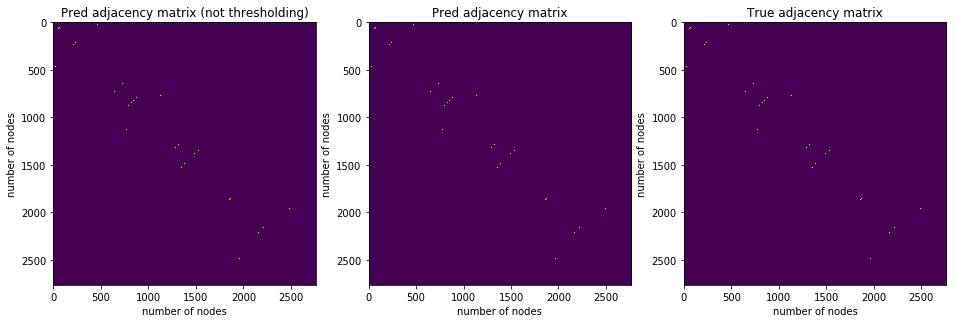

>> test acc :  1.0


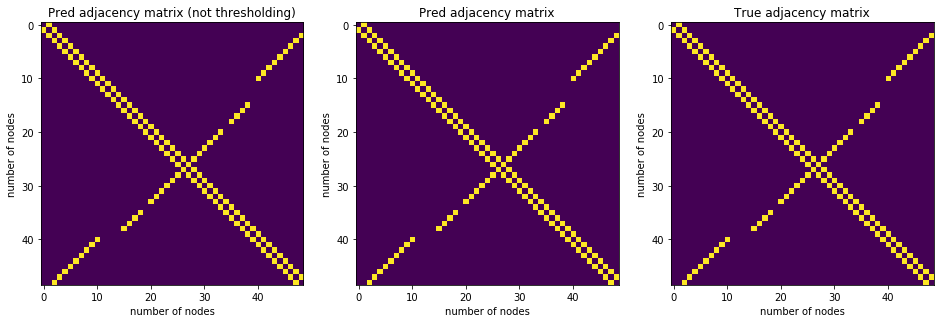

>> test acc :  1.0


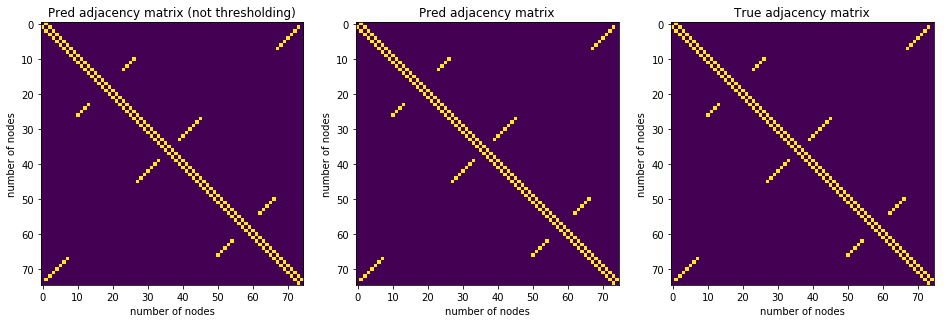

>> test acc :  1.0


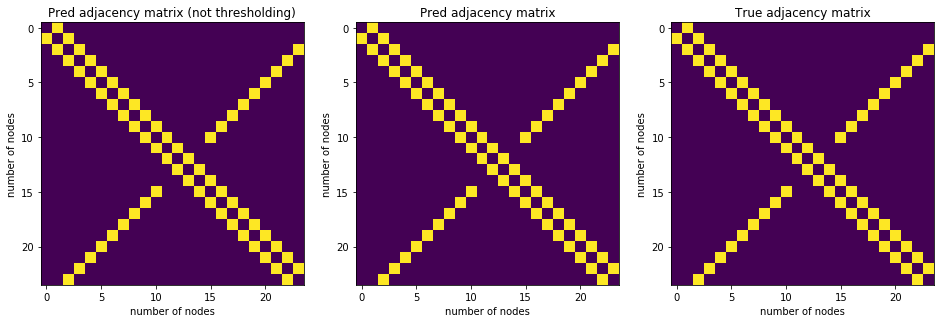

>> test acc :  1.0


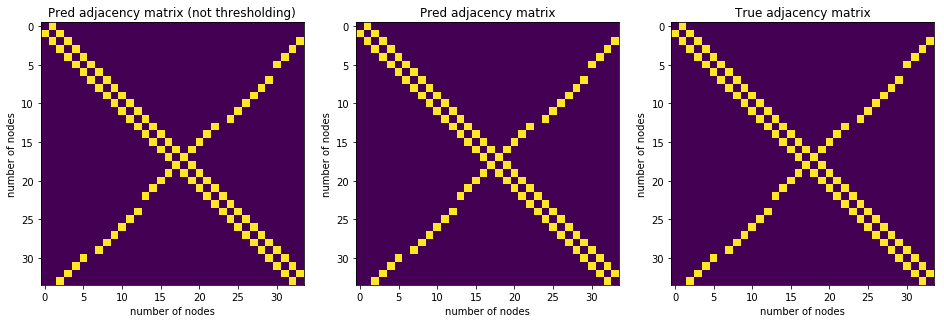

>> test acc :  1.0


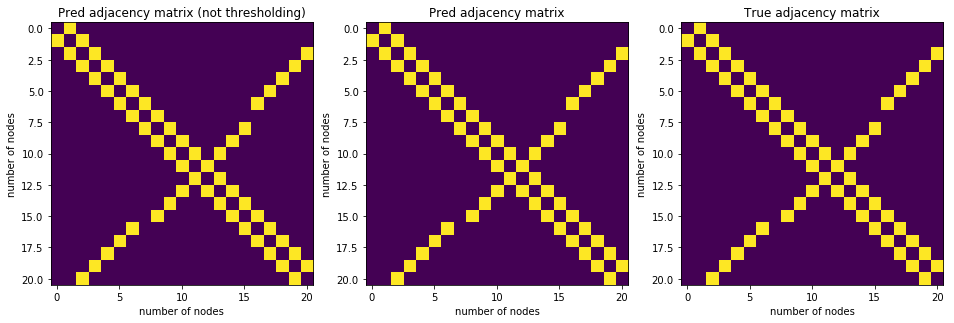

>> test acc :  1.0


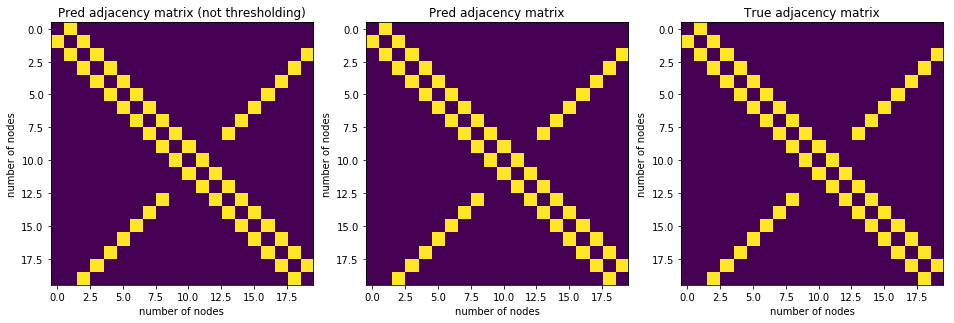

>> test acc :  1.0


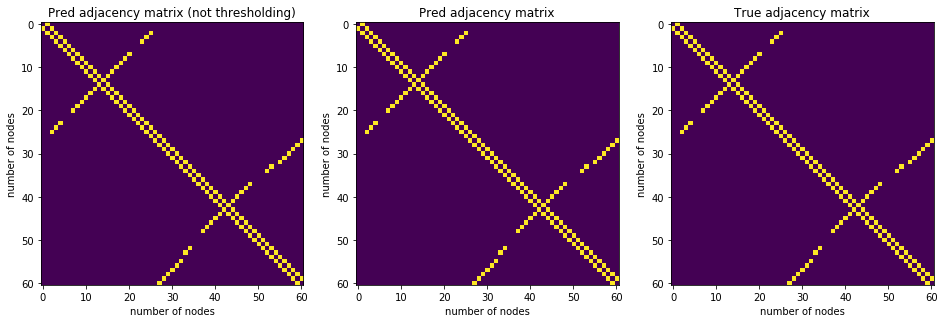

>> test acc :  1.0


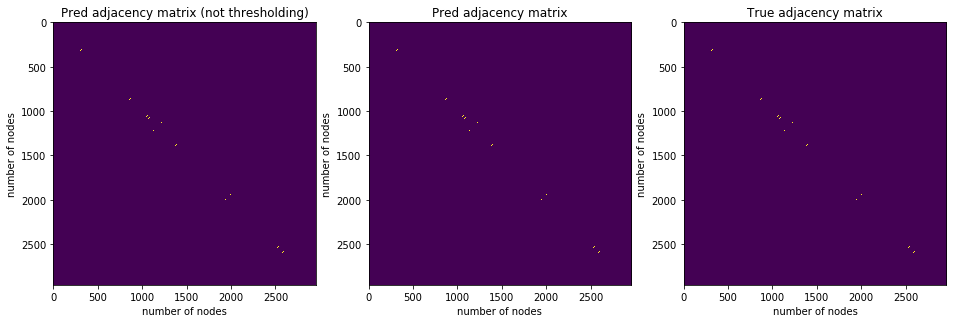

>> test acc :  1.0


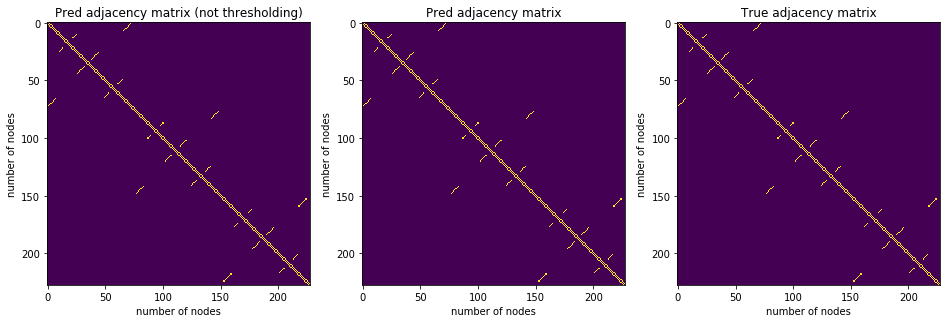

>> test acc :  1.0


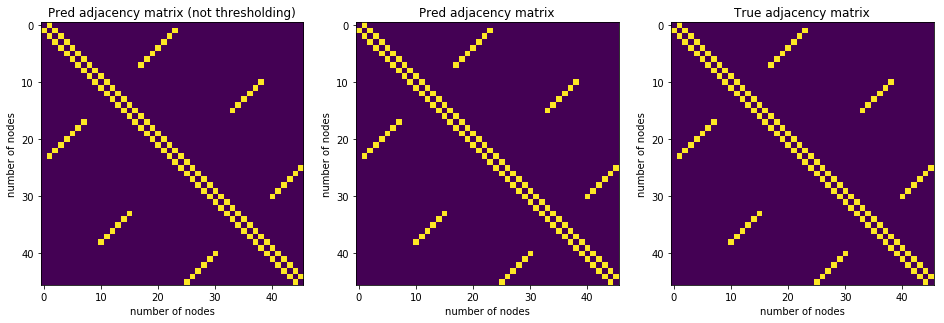

>> test acc :  1.0


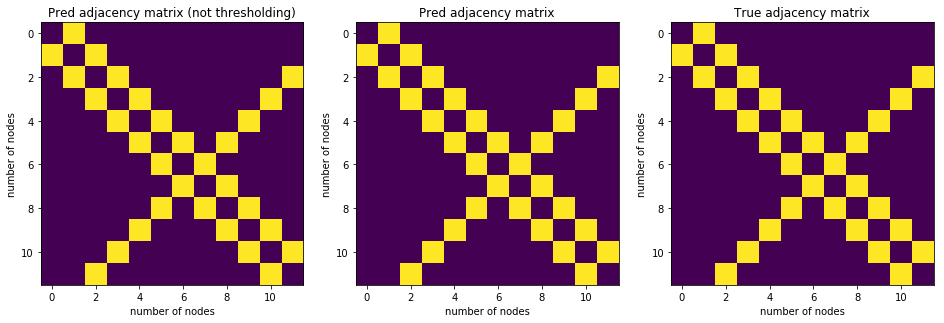

>> test acc :  1.0


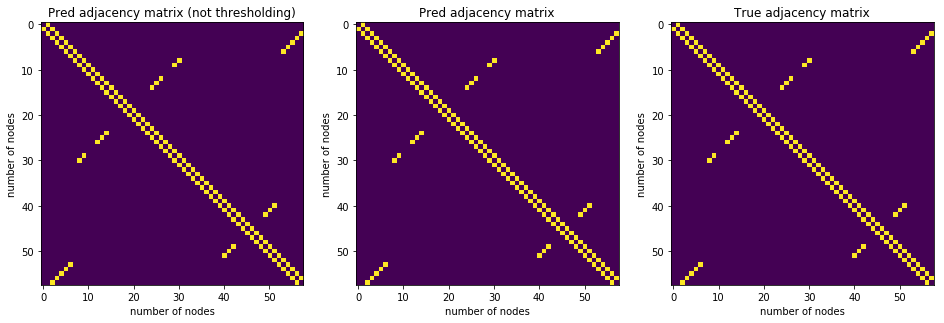

>> test acc :  1.0


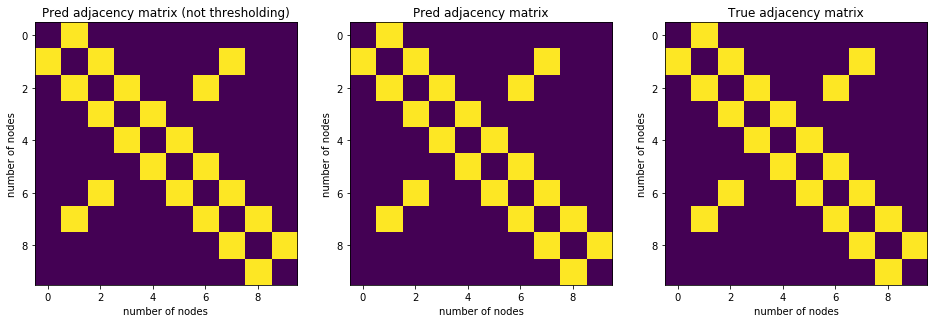

>> test acc :  1.0


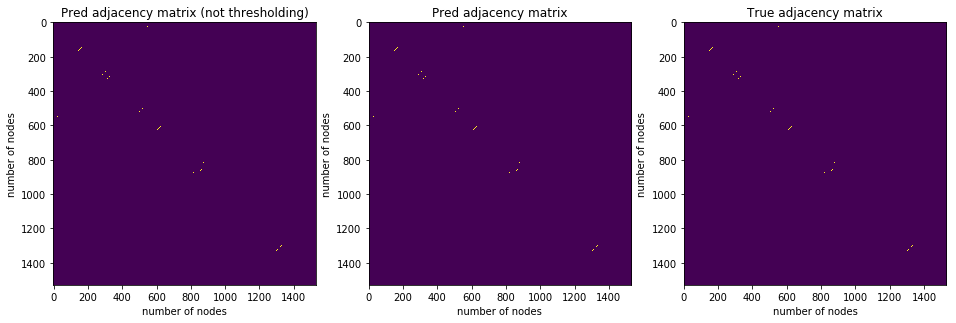

>> test acc :  1.0


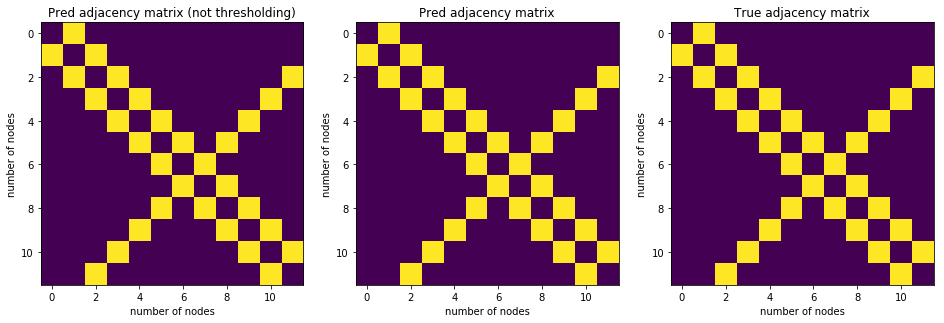

>> test acc :  1.0


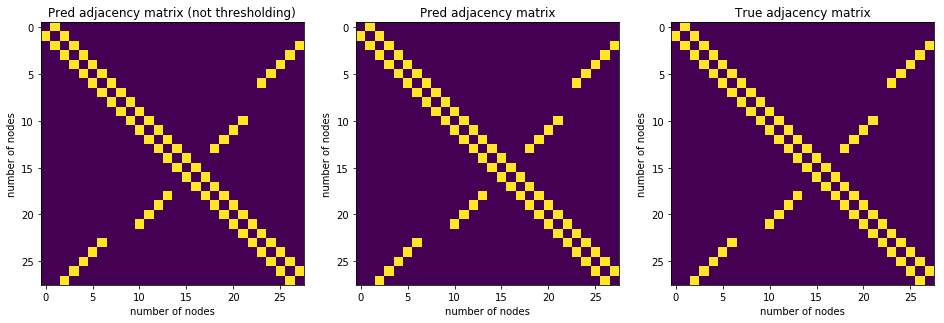

>> test acc :  1.0


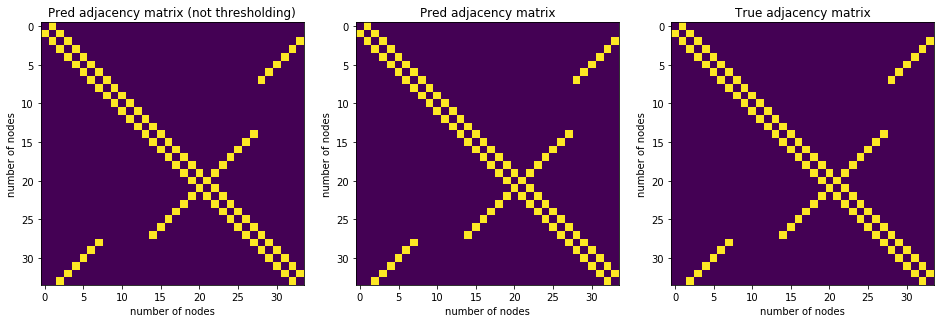

>> test acc :  1.0


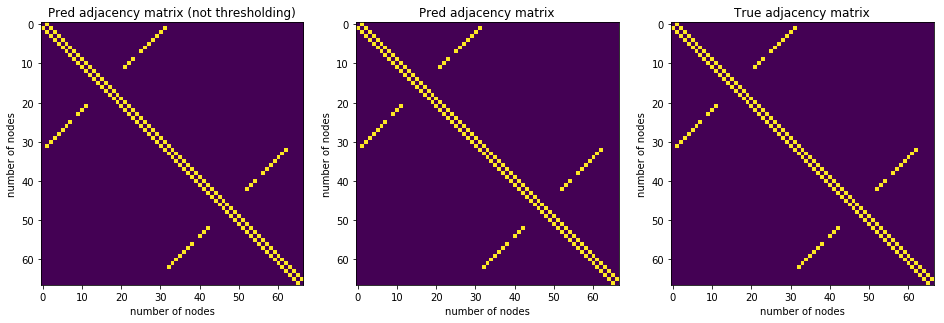

>> test acc :  1.0


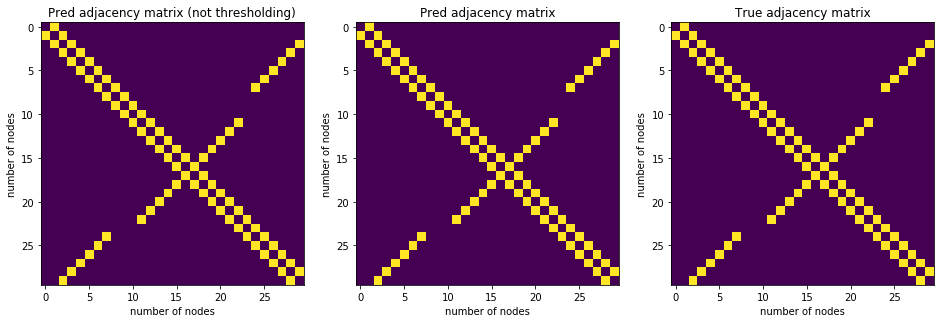

>> test acc :  1.0


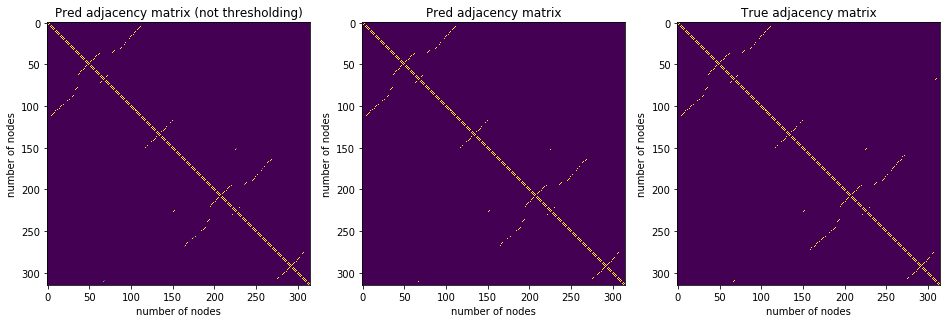

>> test acc :  0.9999989


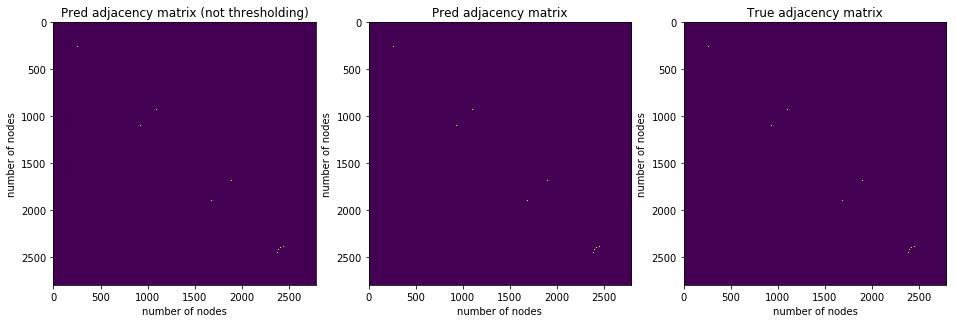

>> test acc :  1.0


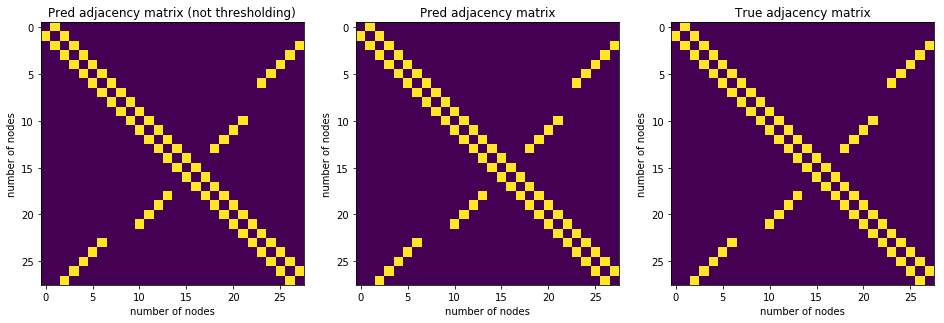

>> test acc :  1.0


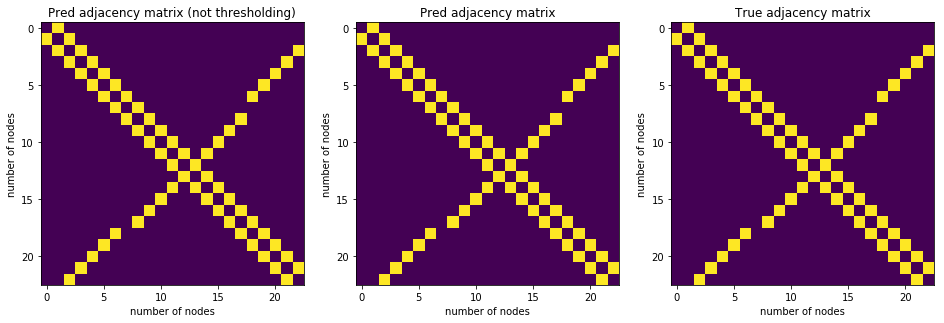

>> test acc :  1.0


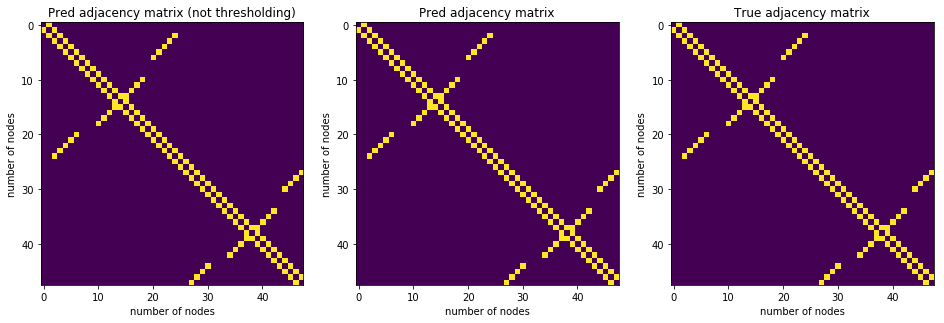

>> test acc :  1.0


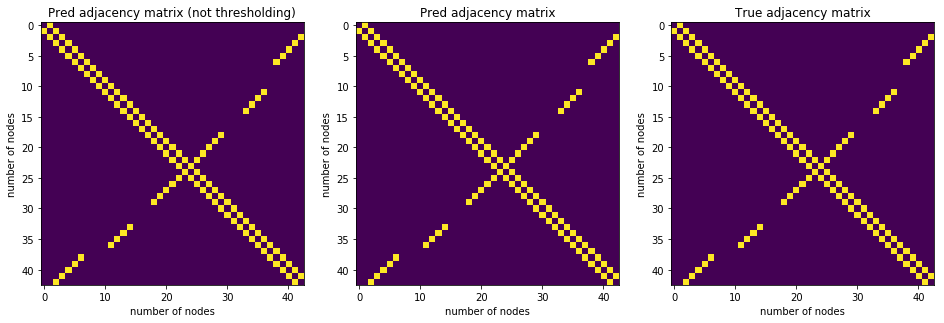

>> test acc :  1.0


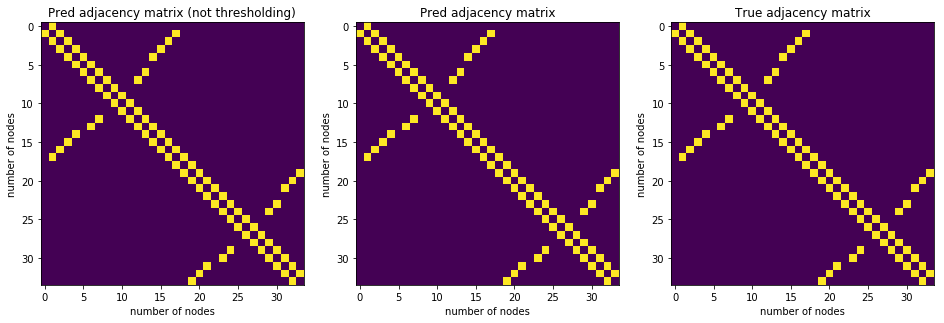

>> test acc :  1.0


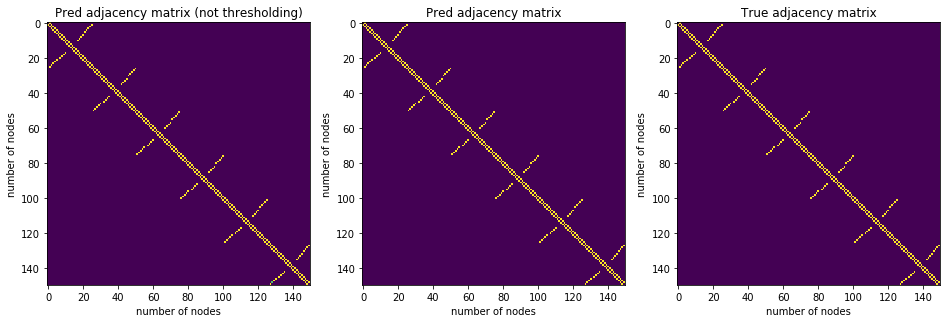

>> test acc :  1.0


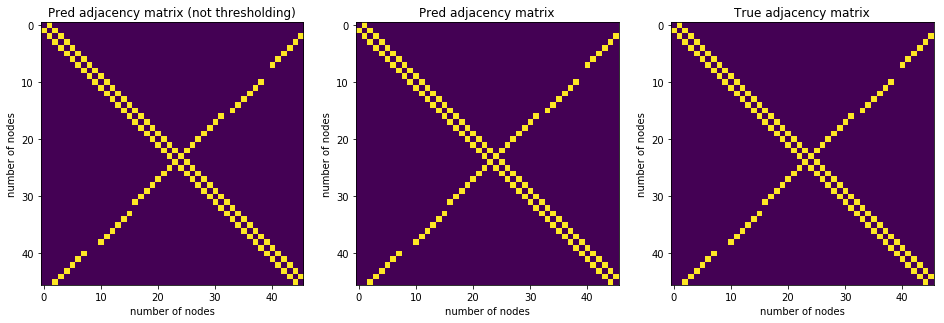

>> test acc :  1.0


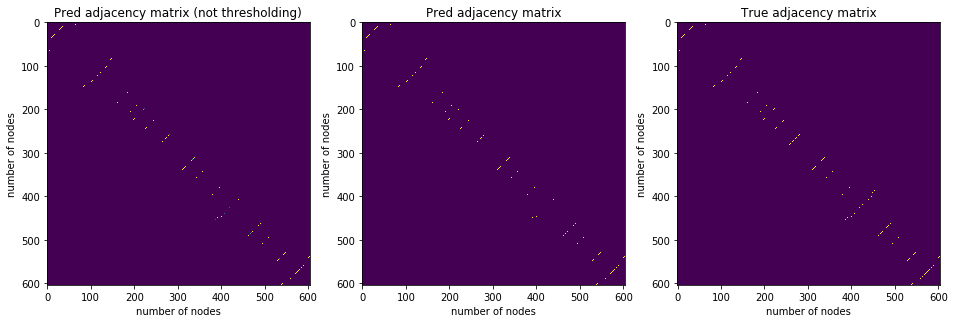

>> test acc :  0.99999386


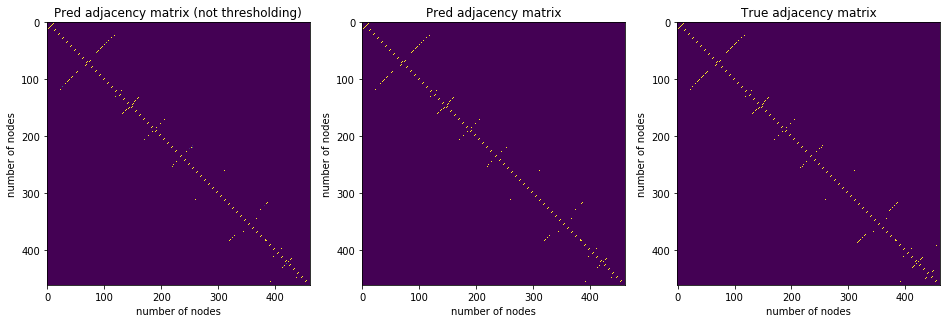

>> test acc :  0.99999624


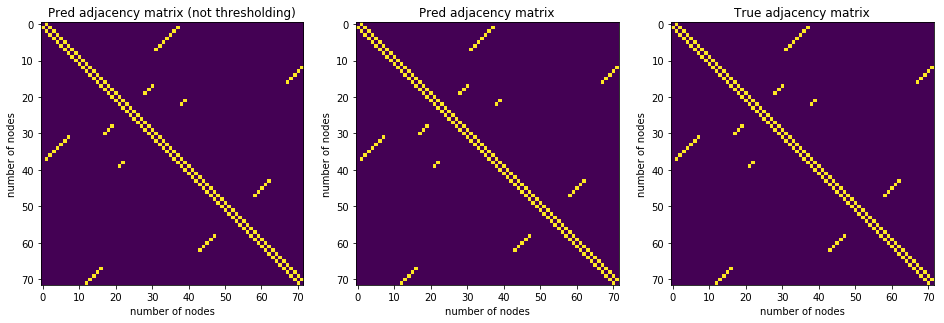

>> test acc :  1.0


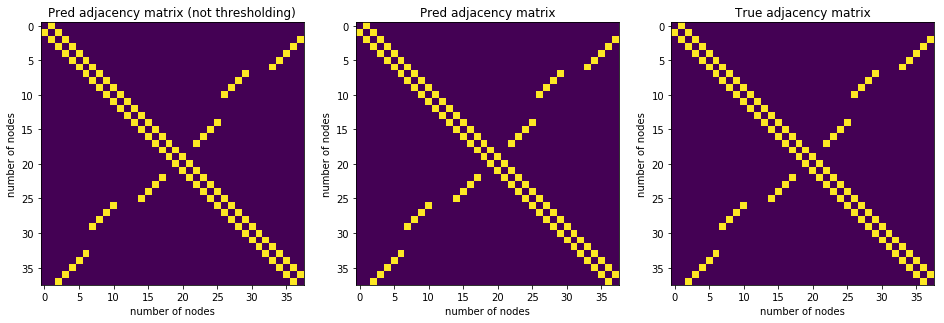

>> test acc :  1.0


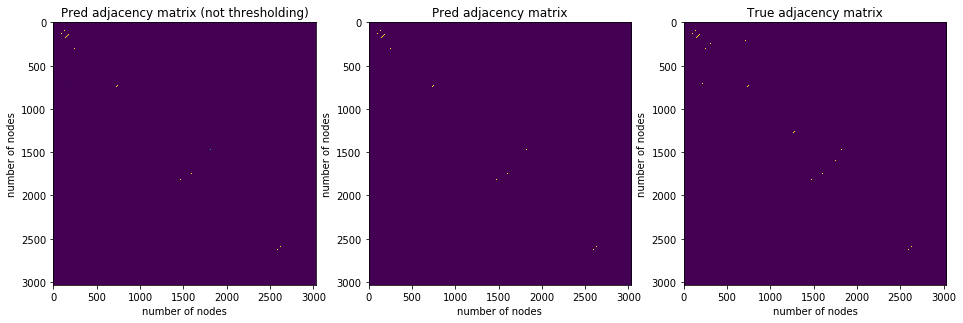

>> test acc :  0.99994063


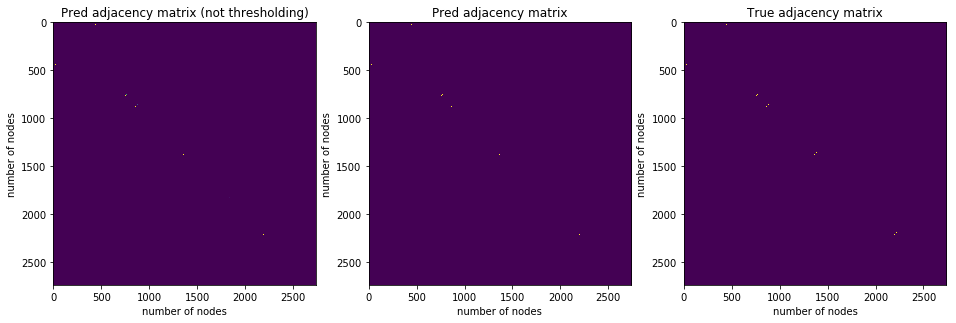

>> test acc :  0.9999605


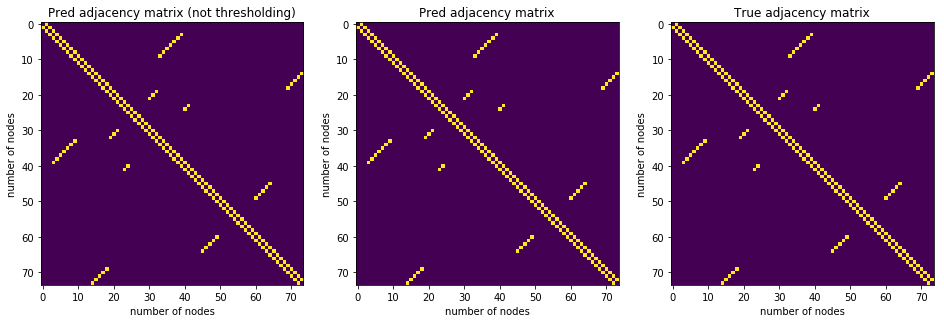

>> test acc :  1.0


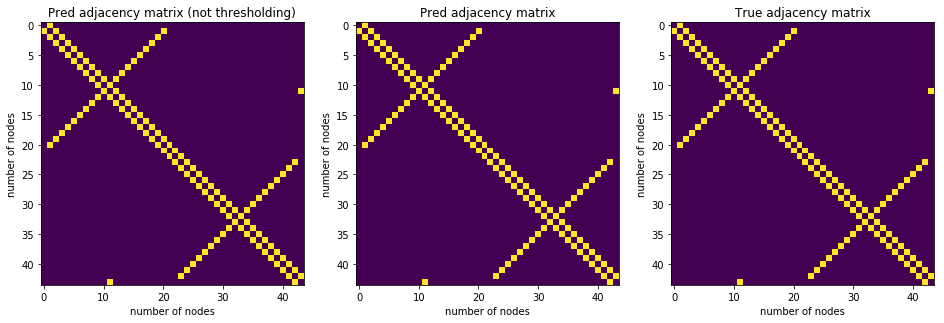

>> test acc :  1.0


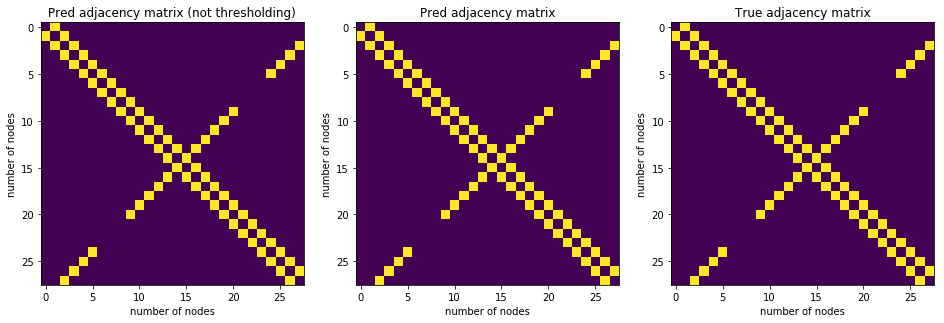

>> test acc :  1.0


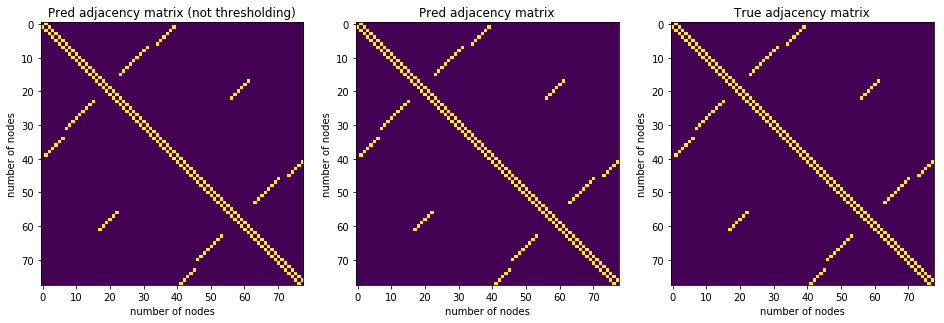

>> test acc :  0.99999994


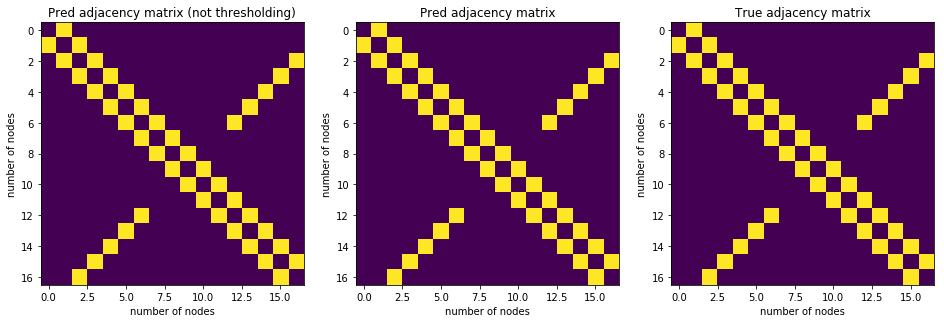

>> test acc :  1.0


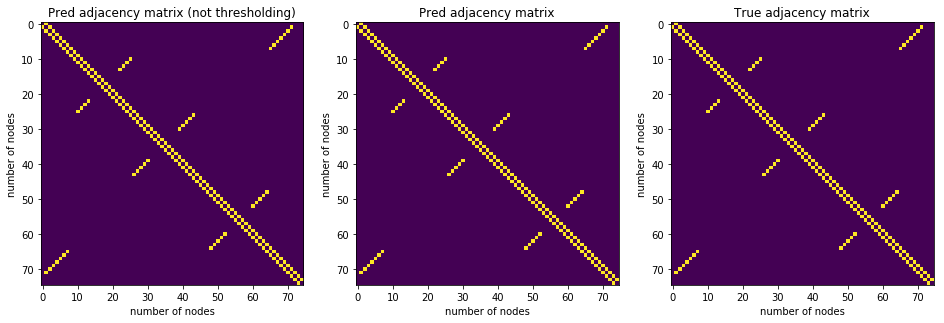

>> test acc :  1.0


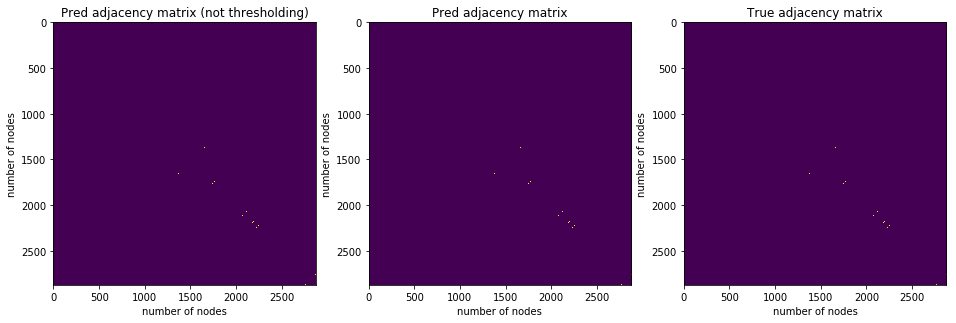

>> test acc :  1.0


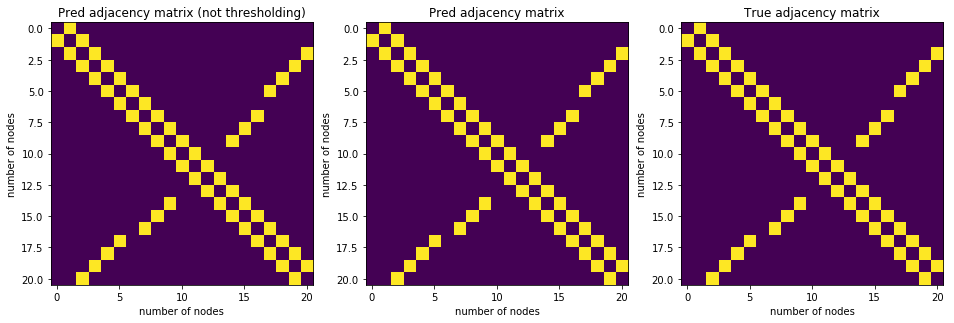

>> test acc :  1.0


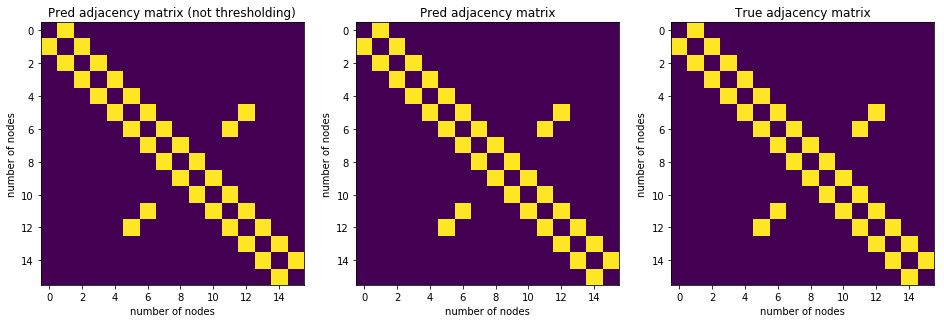

>> test acc :  1.0


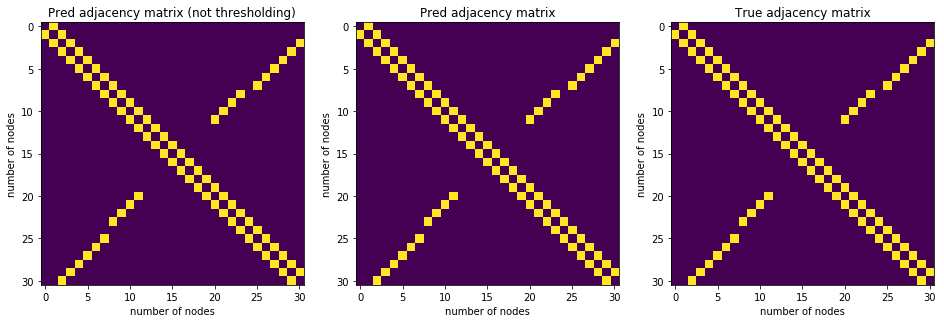

>> test acc :  1.0


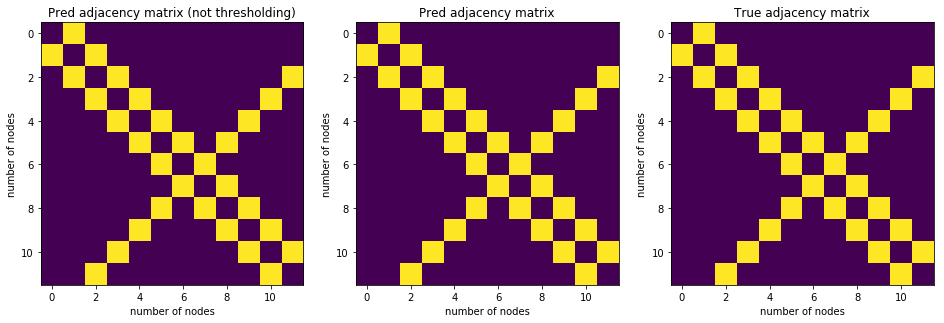

>> test acc :  1.0


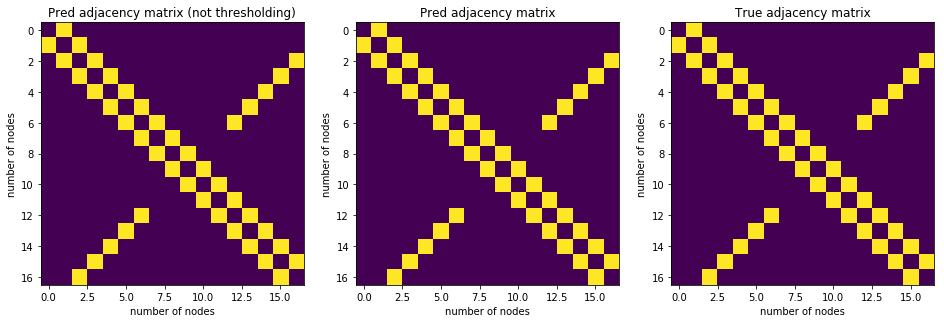

>> test acc :  1.0


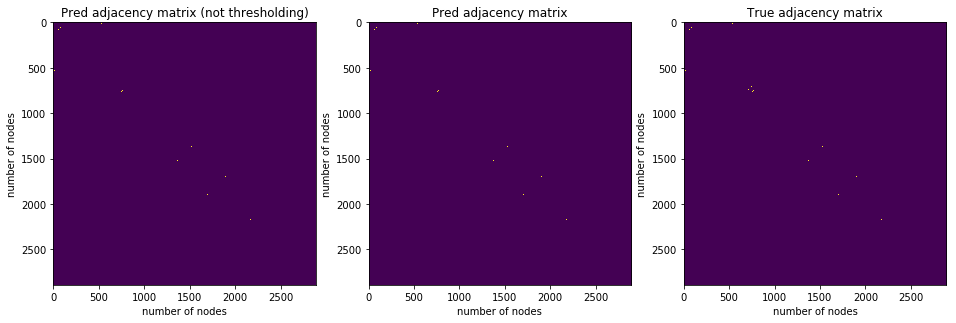

>> test acc :  0.9999888


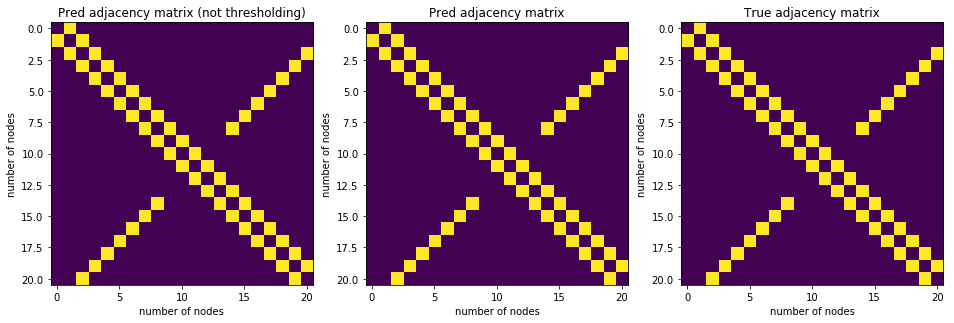

>> test acc :  1.0


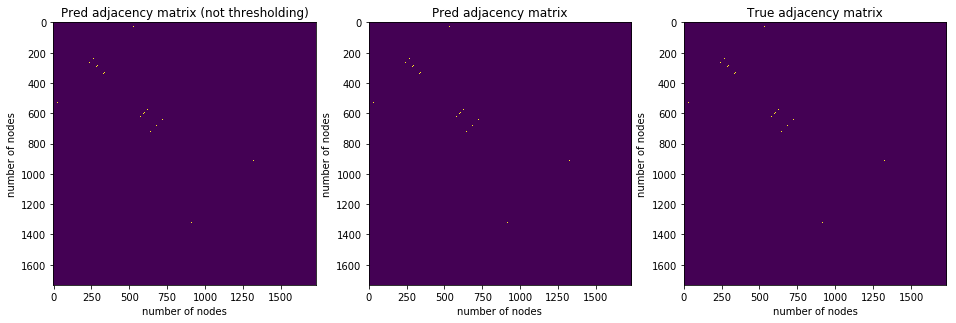

>> test acc :  0.9999984


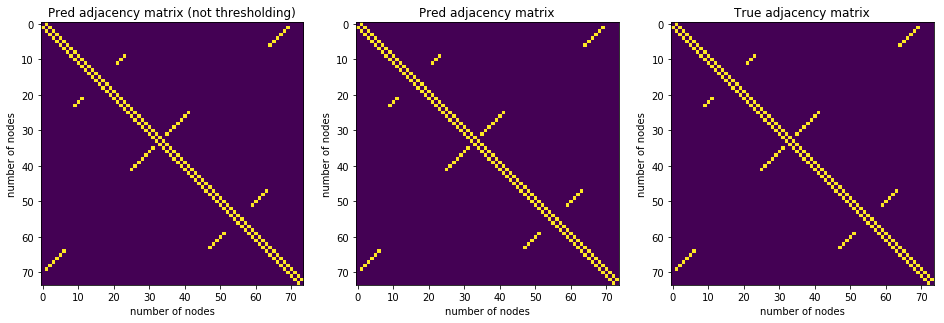

>> test acc :  1.0


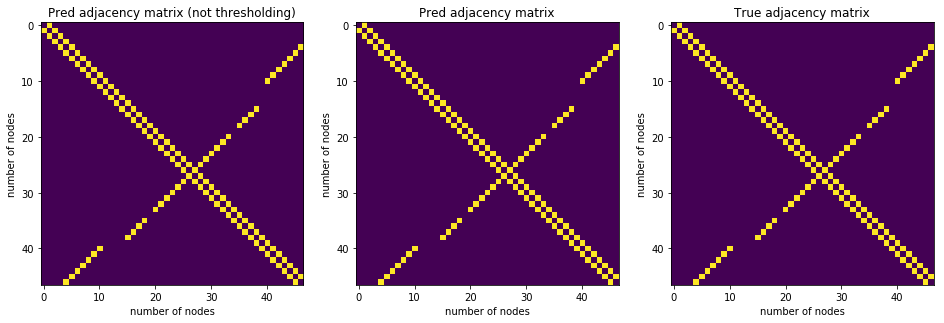

>> test acc :  1.0


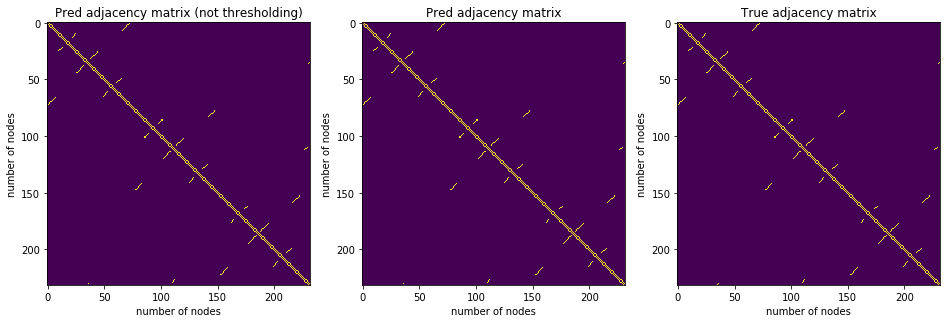

>> test acc :  0.9999999


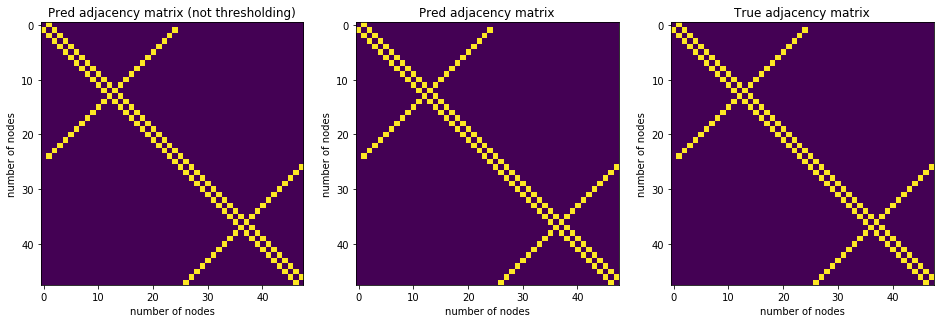

>> test acc :  1.0


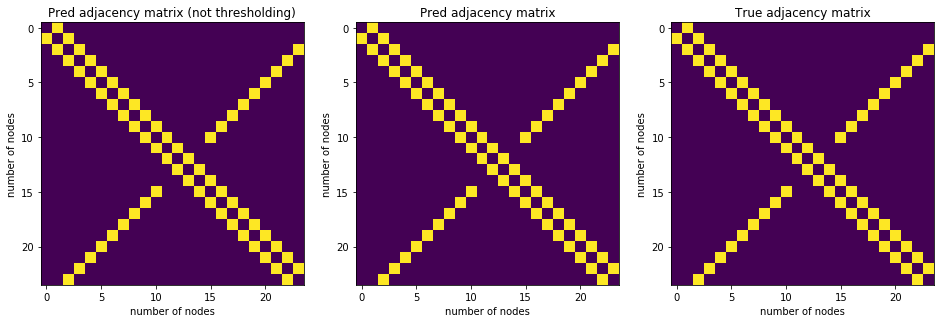

>> test acc :  1.0


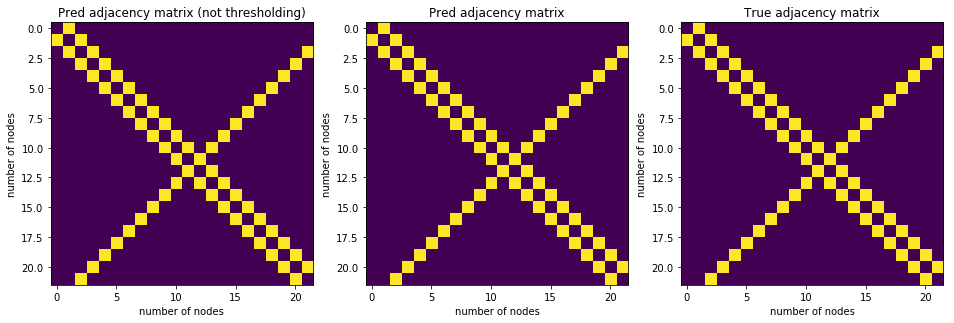

>> test acc :  1.0


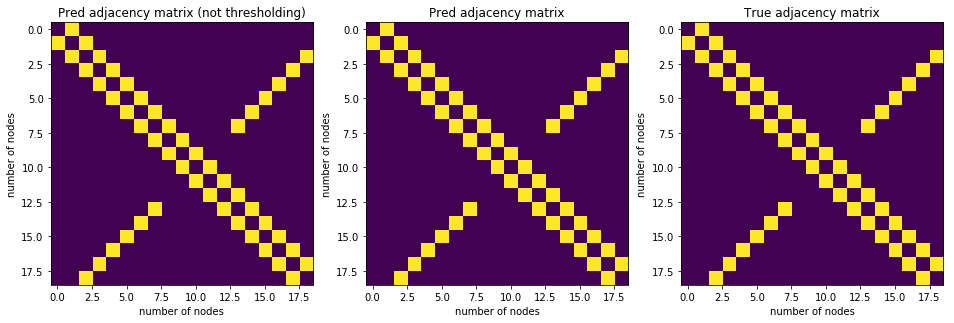

>> test acc :  1.0


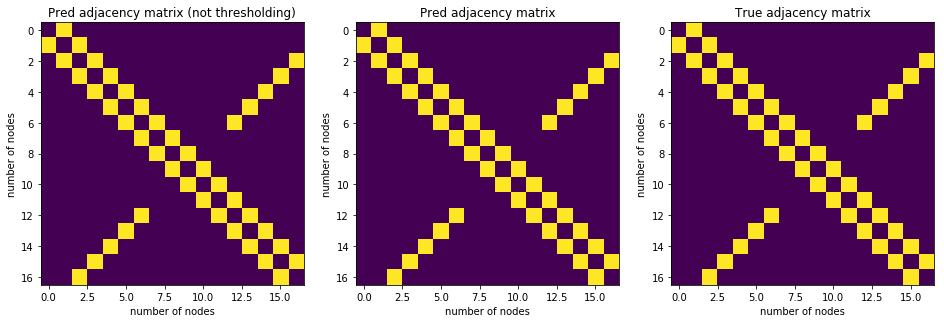

>> test acc :  1.0


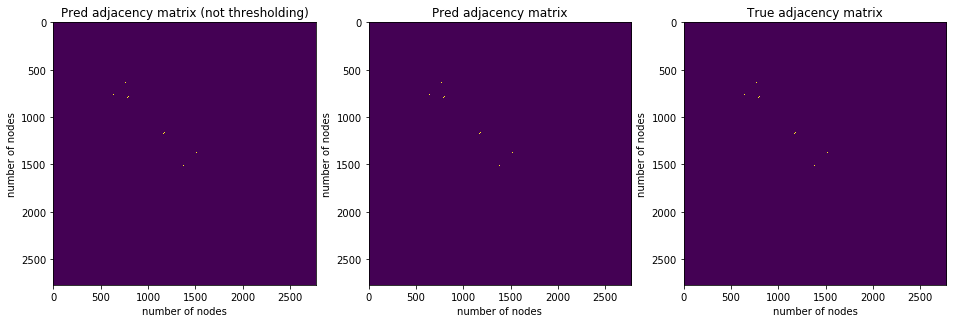

>> test acc :  1.0


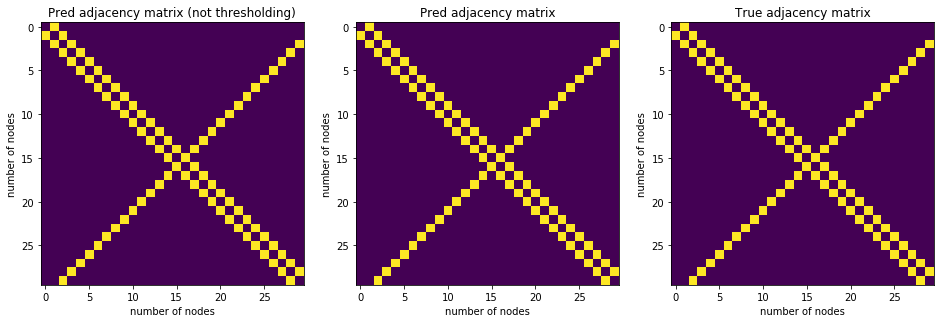

>> test acc :  1.0


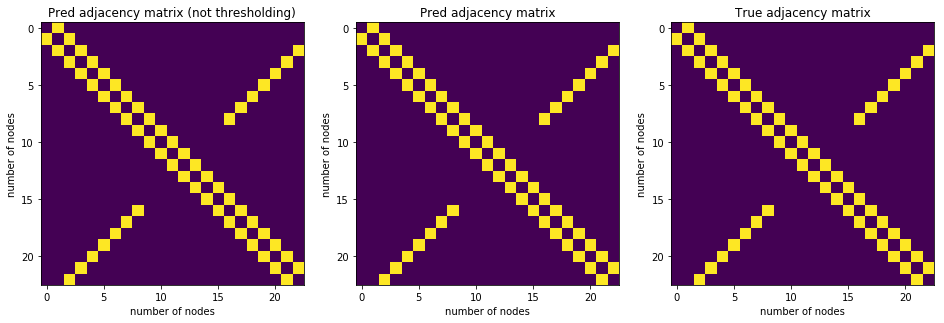

>> test acc :  1.0


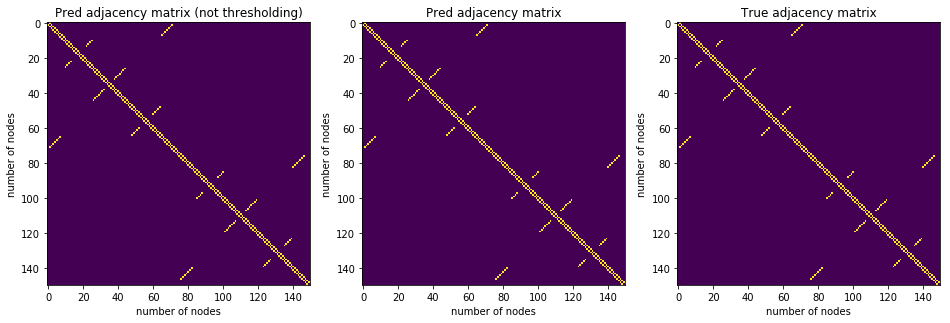

>> test acc :  1.0


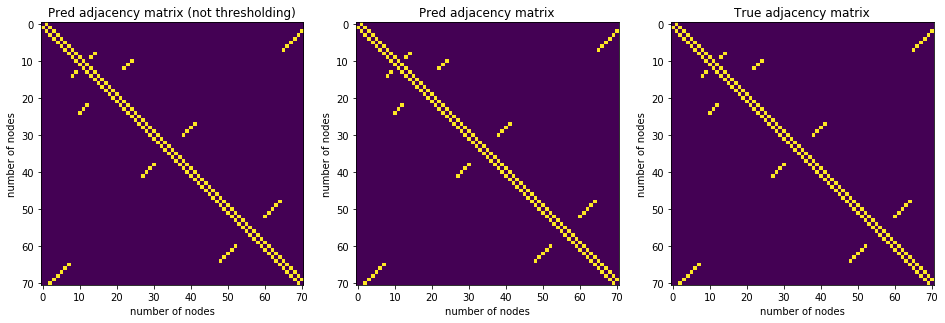

>> test acc :  1.0


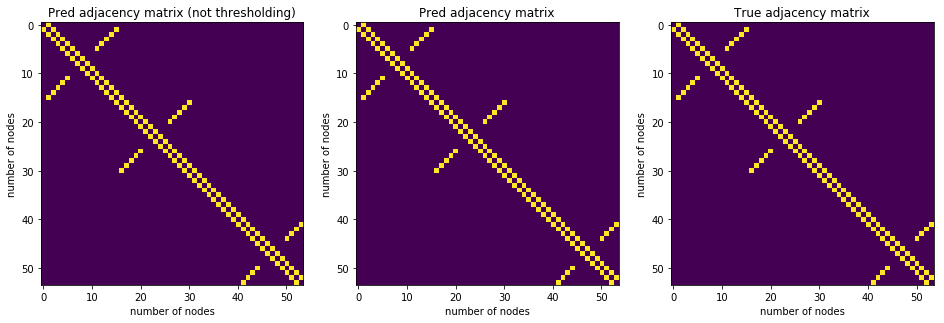

>> test acc :  1.0


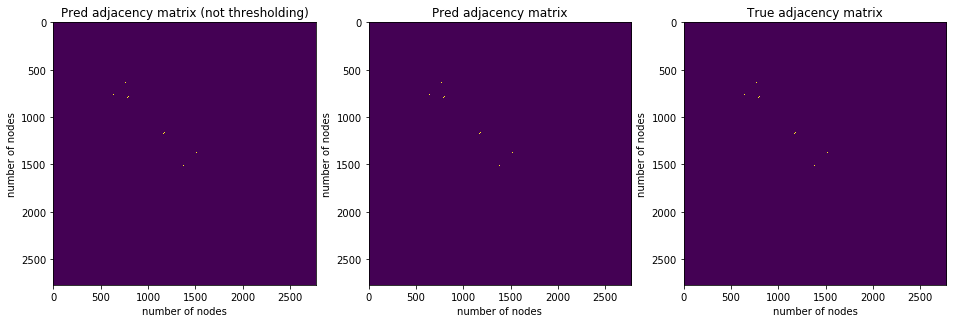

>> test acc :  1.0


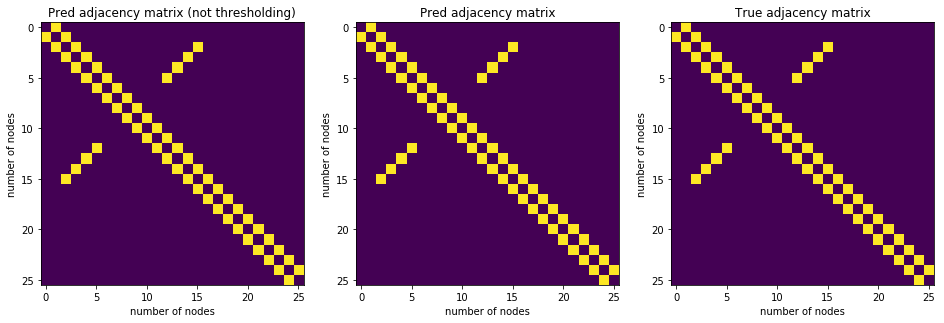

>> test acc :  1.0


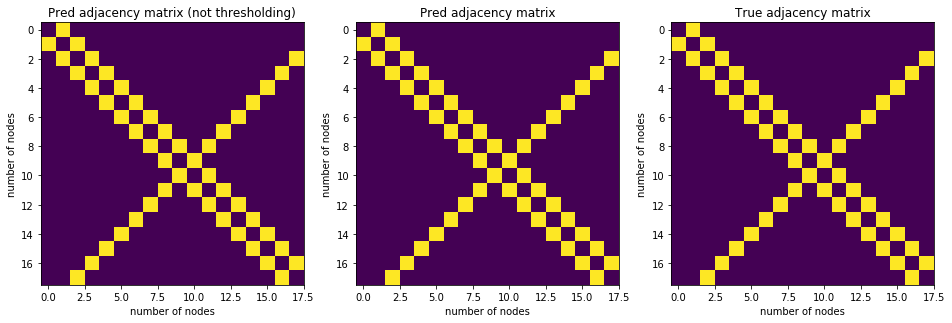

>> test acc :  1.0


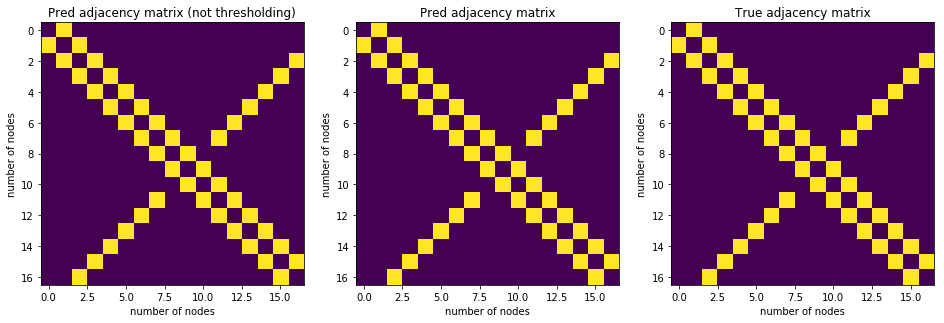

>> test acc :  1.0


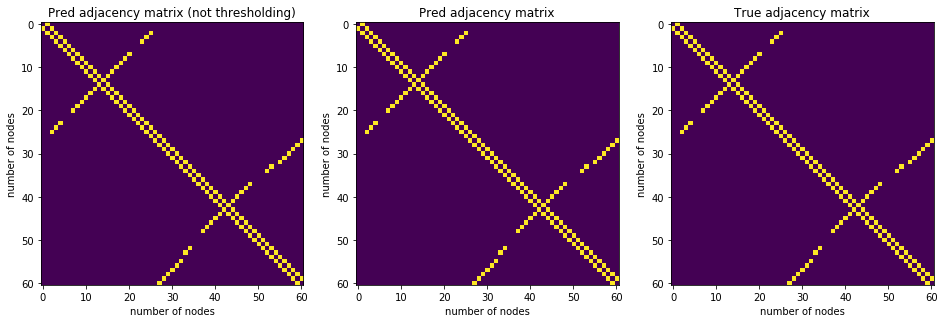

>> test acc :  1.0


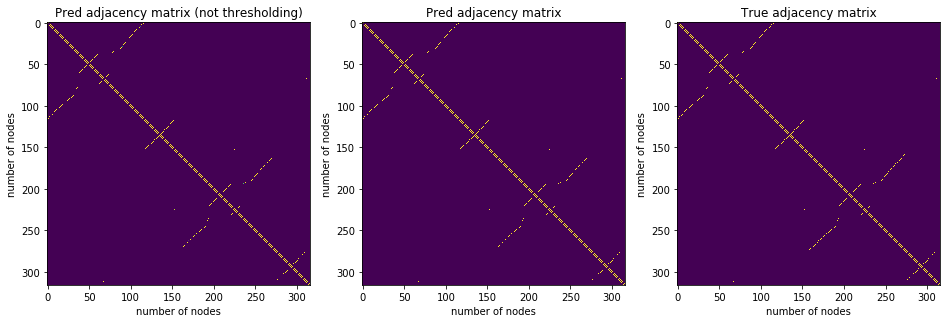

>> test acc :  0.9999987


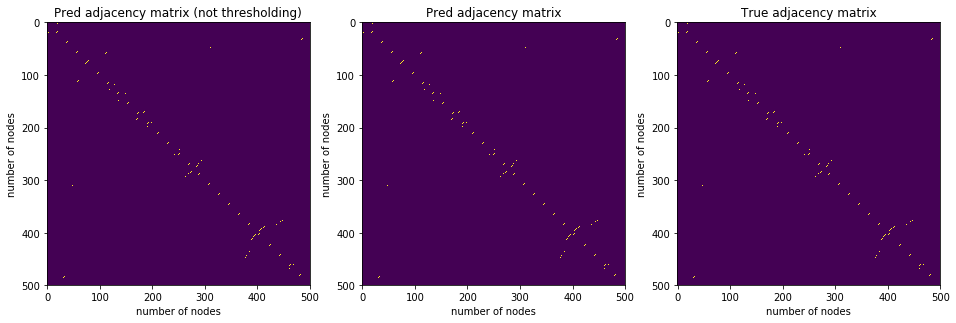

>> test acc :  0.9999999


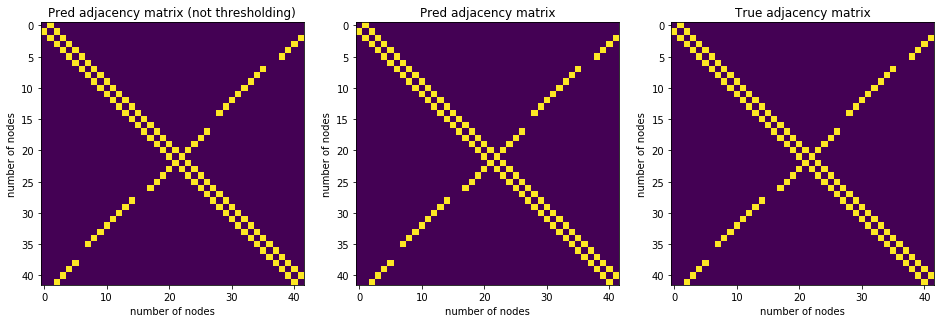

>> test acc :  1.0


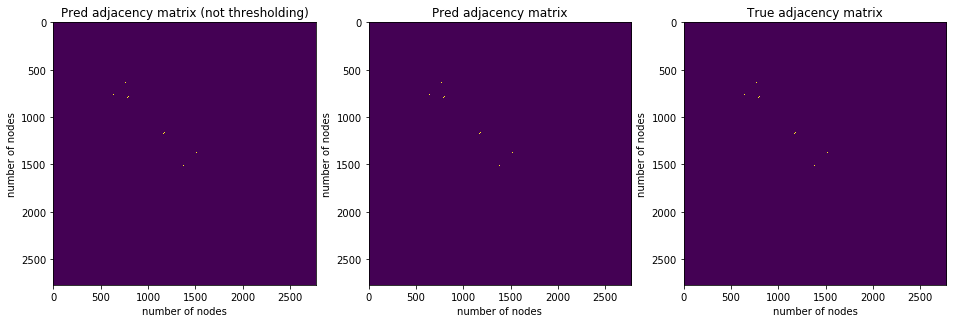

>> test acc :  1.0


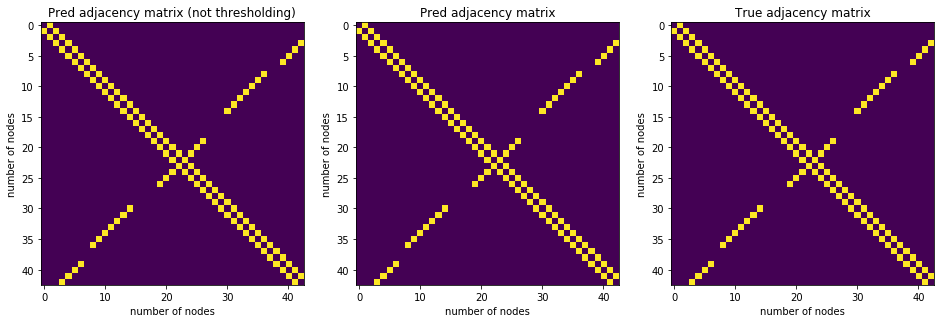

>> test acc :  1.0


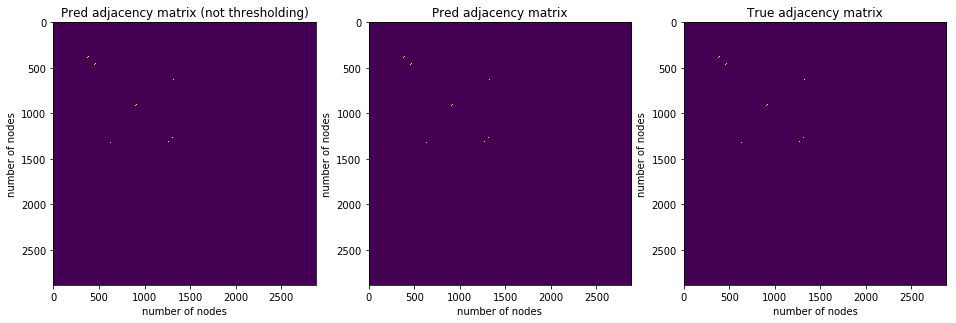

>> test acc :  1.0


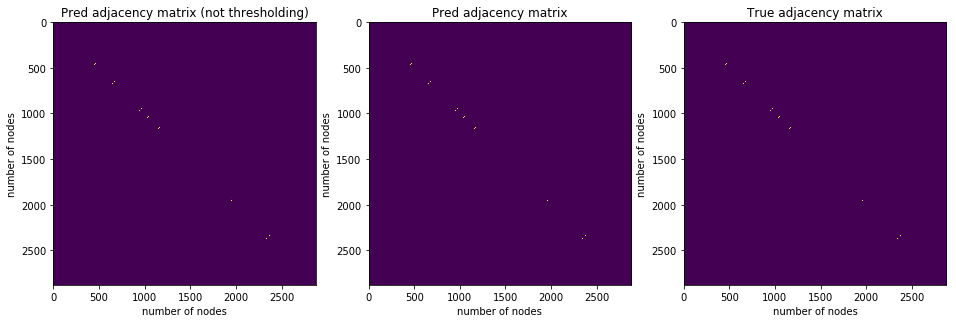

>> test acc :  0.99999994


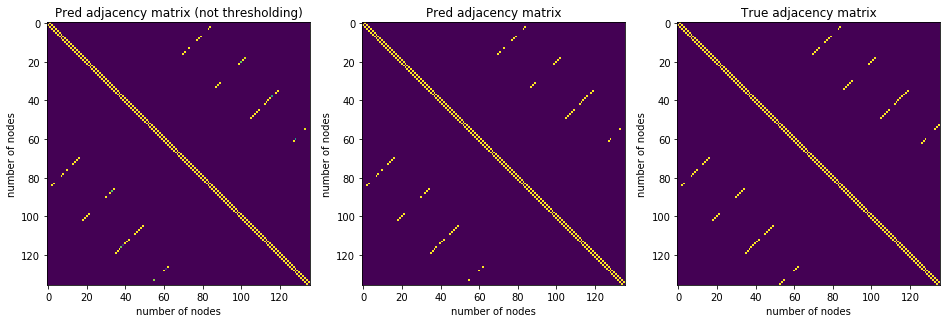

>> test acc :  0.99999917


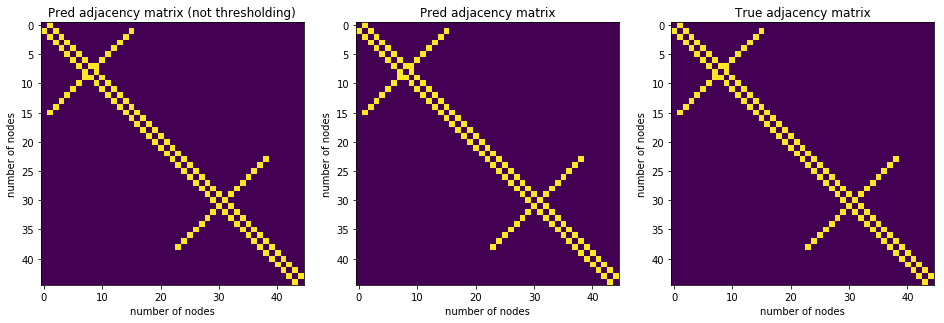

>> test acc :  1.0


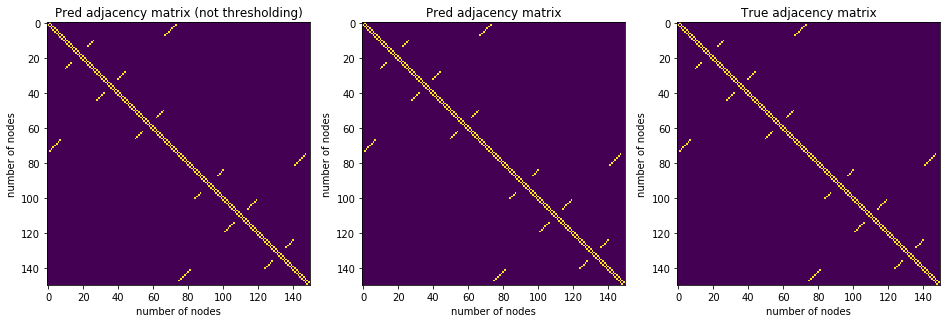

>> test acc :  1.0


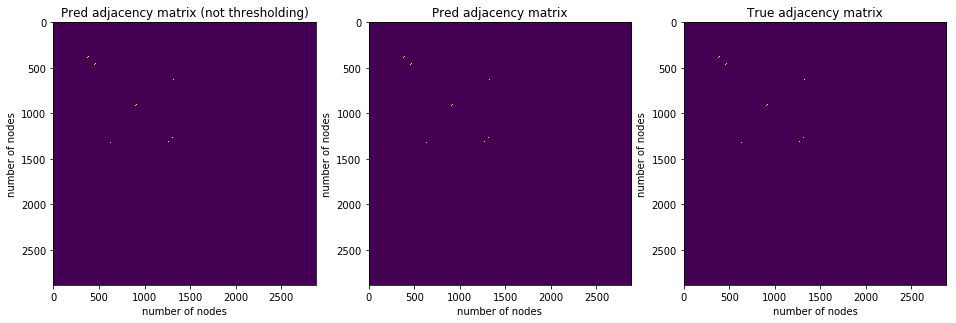

>> test acc :  1.0


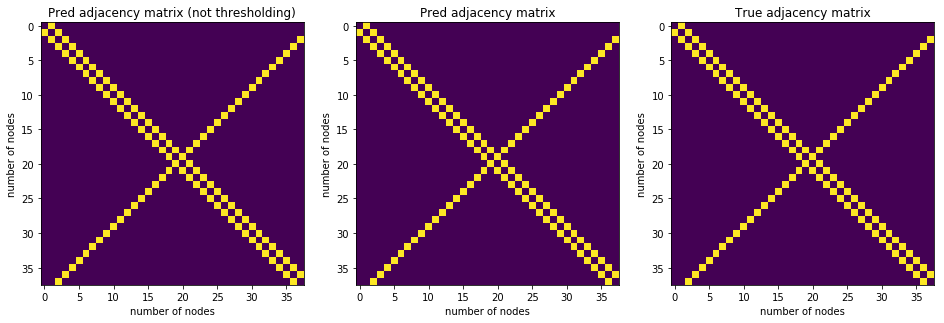

>> test acc :  1.0


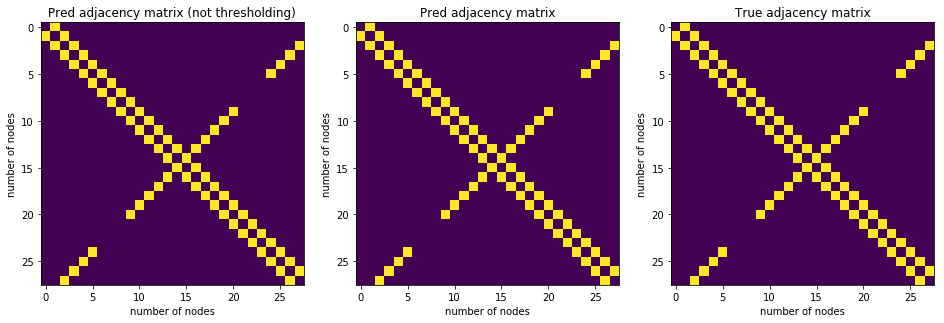

>> test acc :  1.0


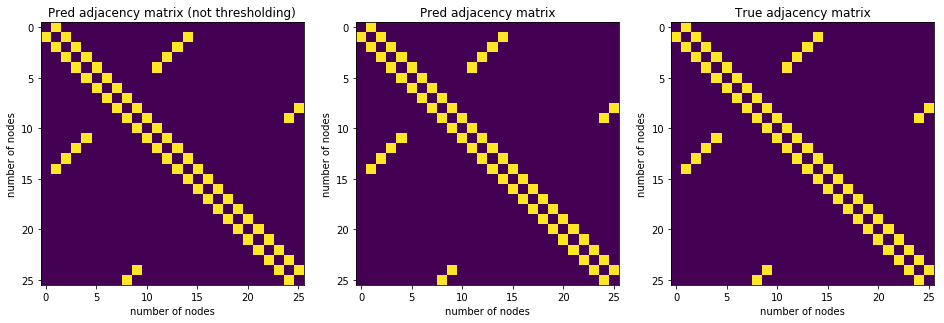

>> test acc :  1.0


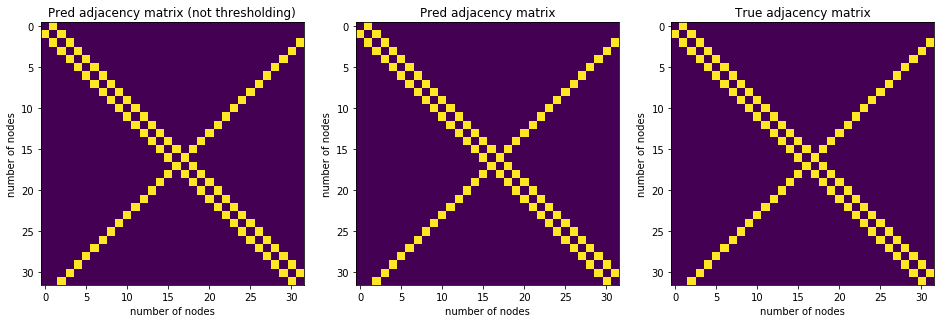

>> test acc :  1.0


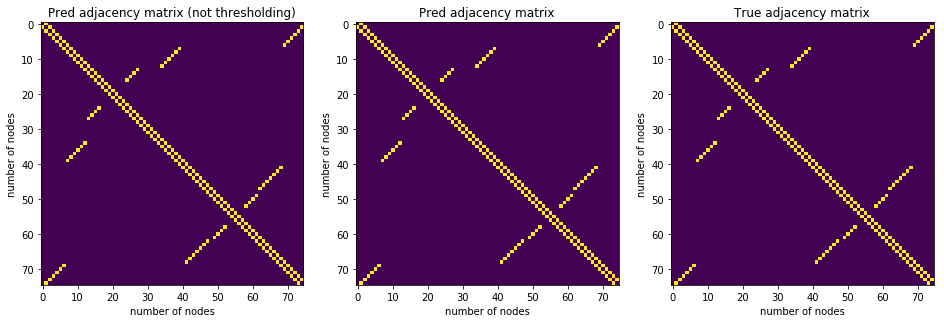

>> test acc :  1.0


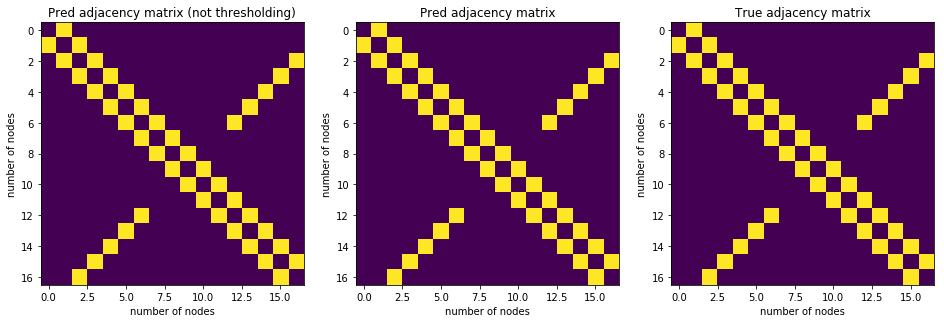

>> test acc :  1.0


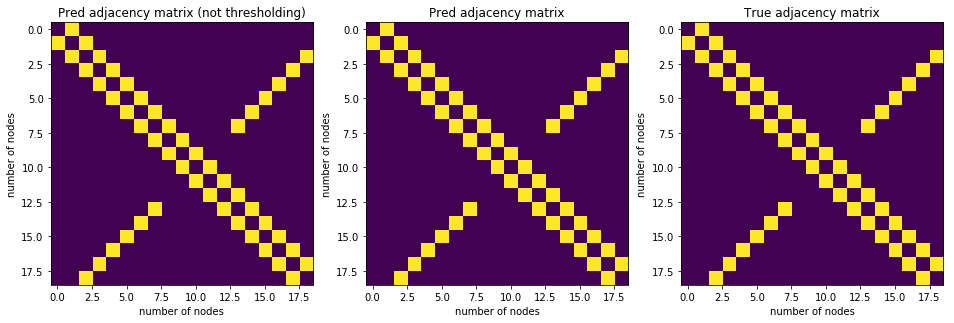

>> test acc :  1.0


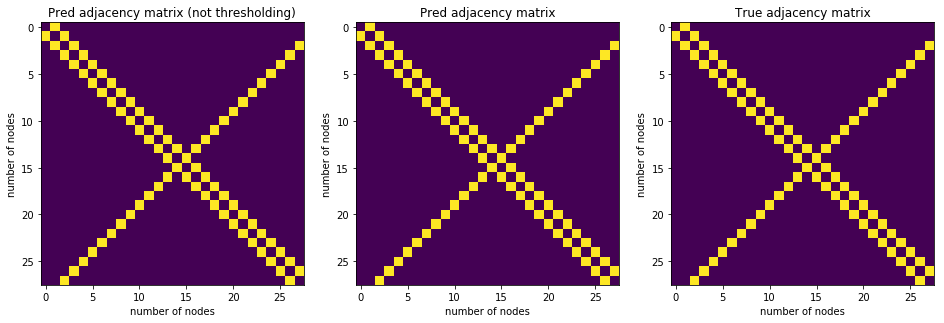

>> test acc :  1.0


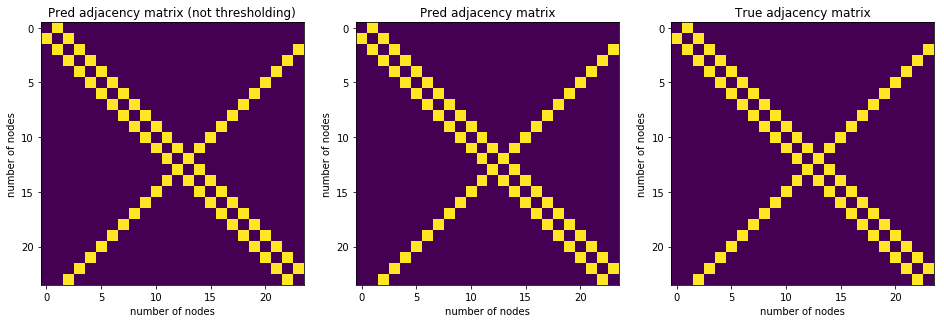

>> test acc :  1.0


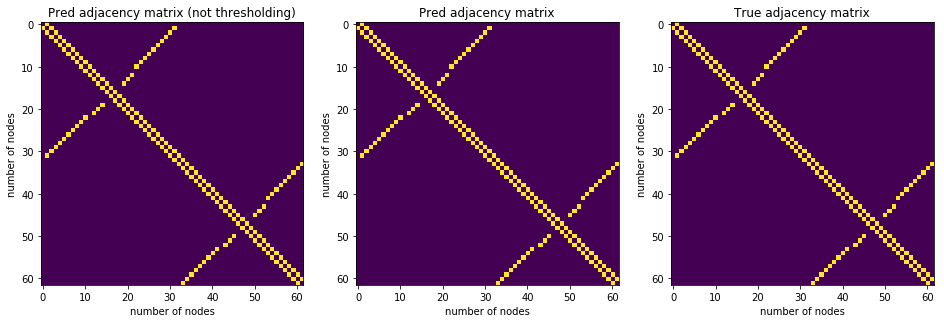

>> test acc :  1.0


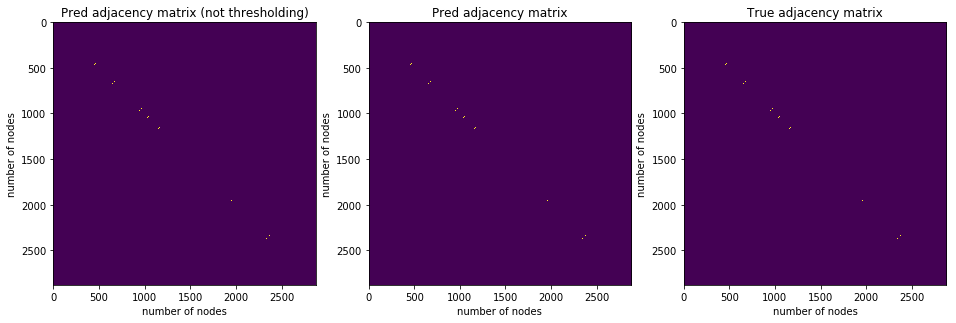

>> test acc :  1.0


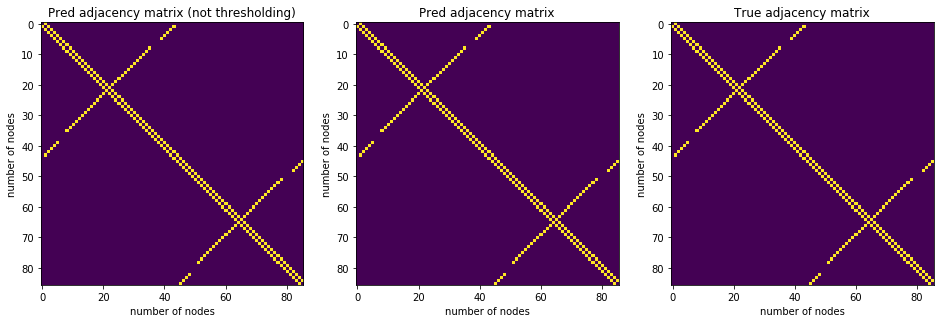

>> test acc :  1.0


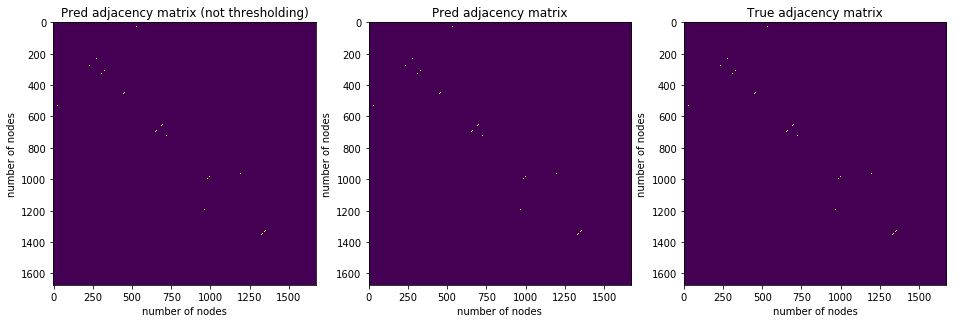

>> test acc :  1.0


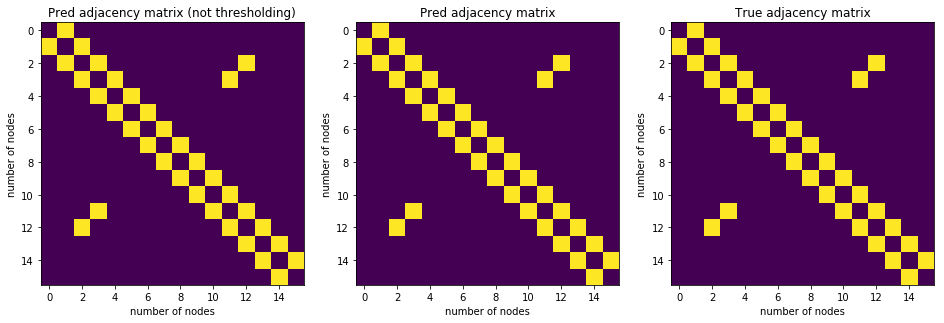

>> test acc :  1.0


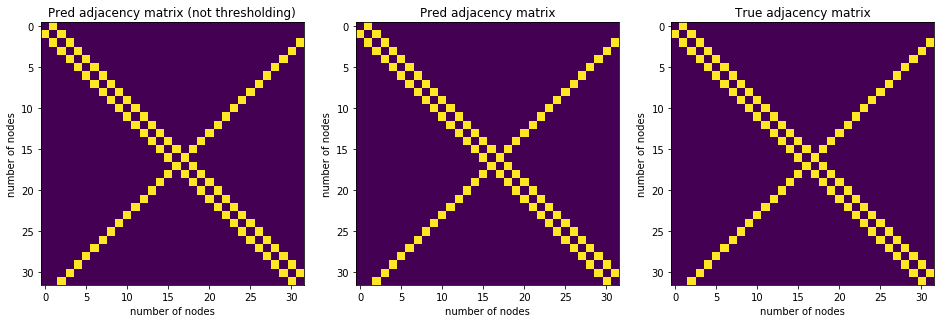

>> test acc :  1.0


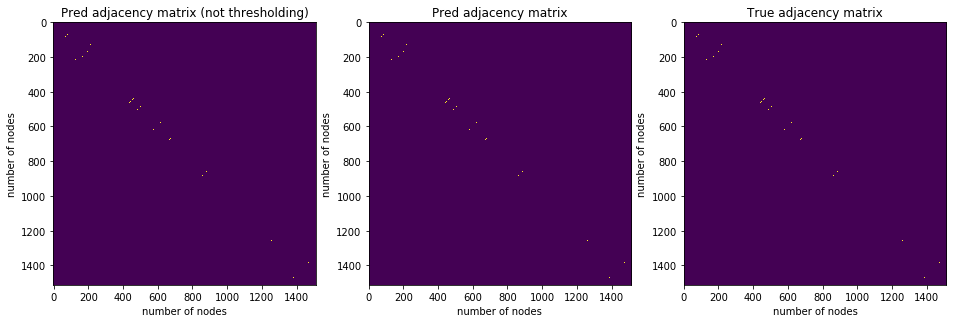

>> test acc :  1.0


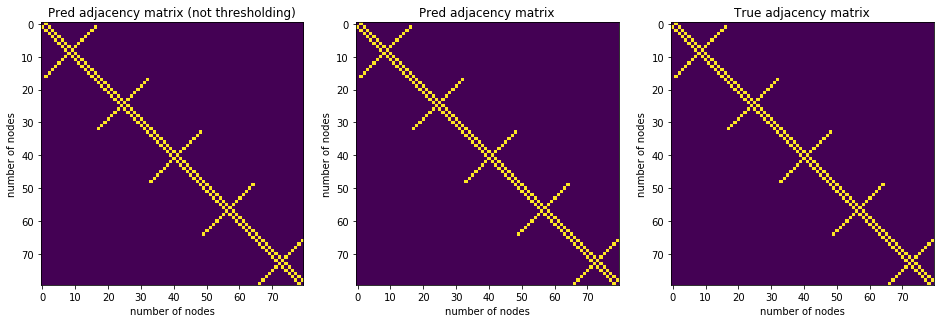

>> test acc :  1.0


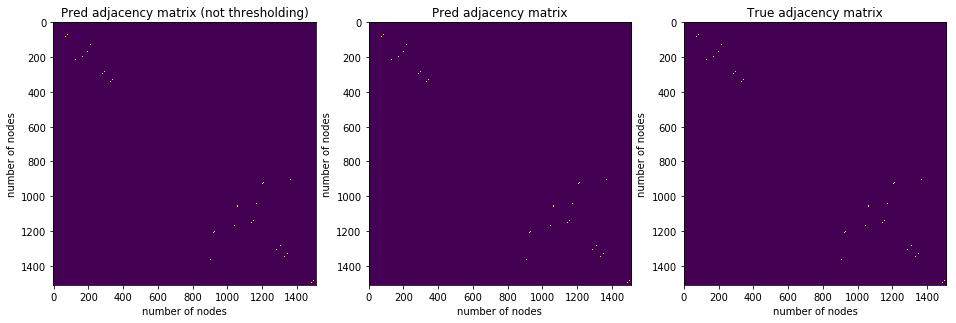

>> test acc :  0.9999998


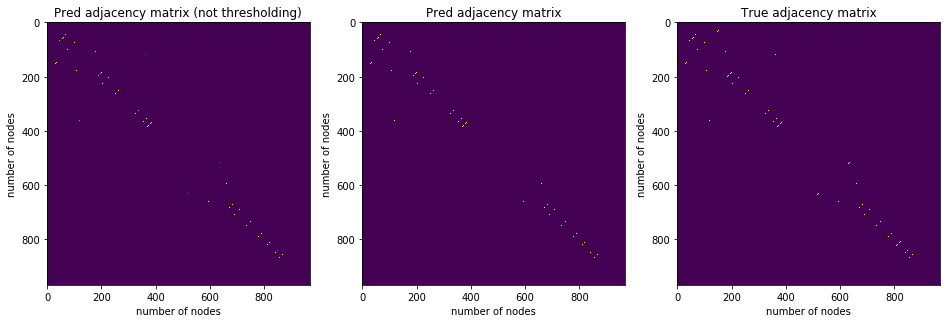

>> test acc :  0.99999


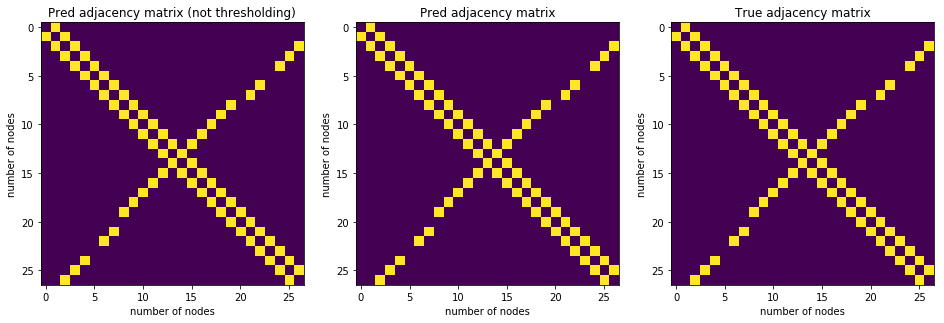

>> test acc :  1.0


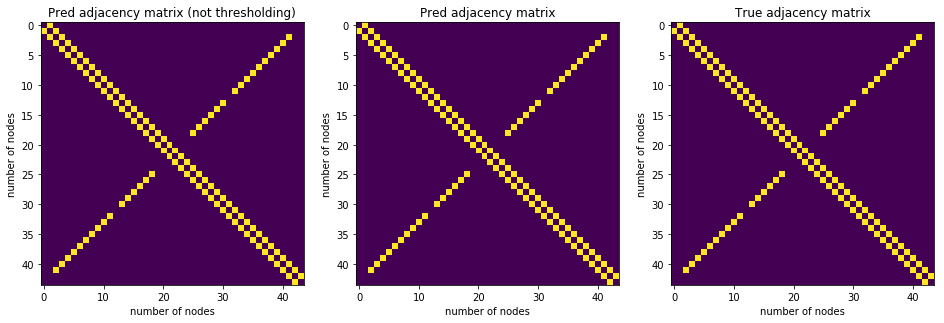

>> test acc :  1.0


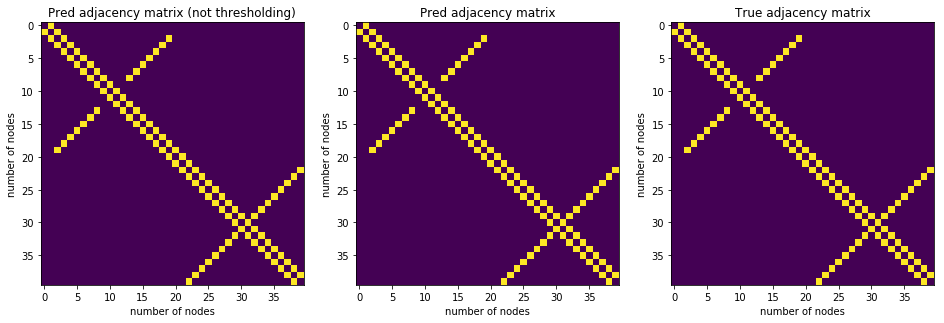

>> test acc :  1.0


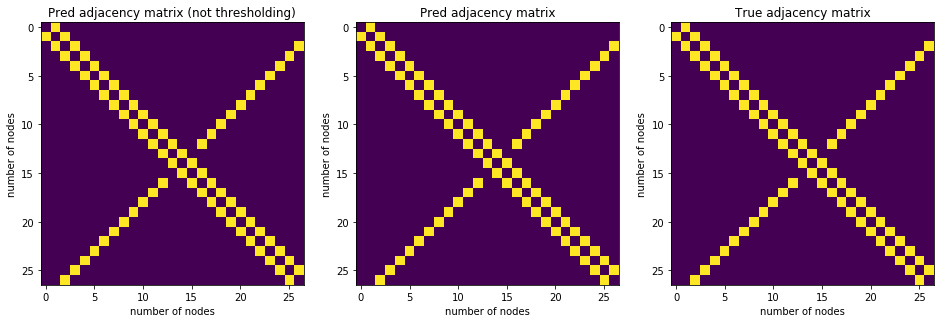

>> test acc :  1.0


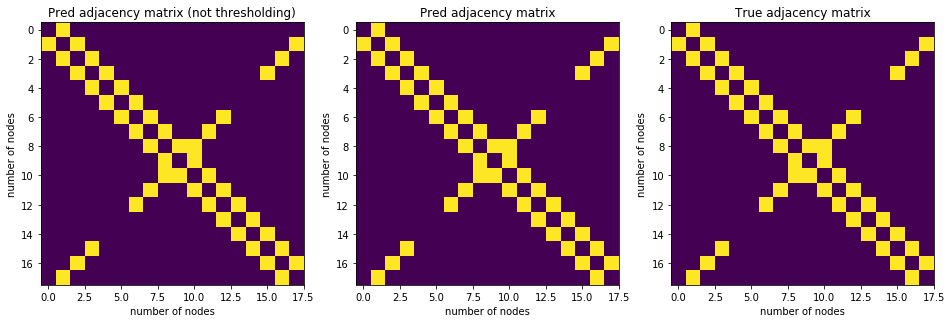

>> test acc :  1.0


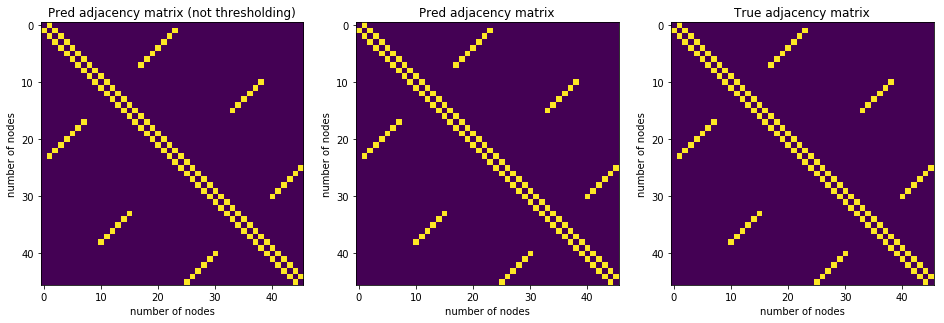

>> test acc :  1.0


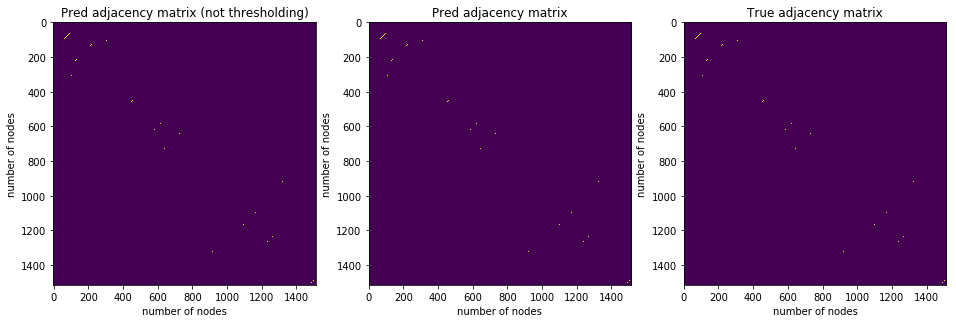

>> test acc :  0.9999999


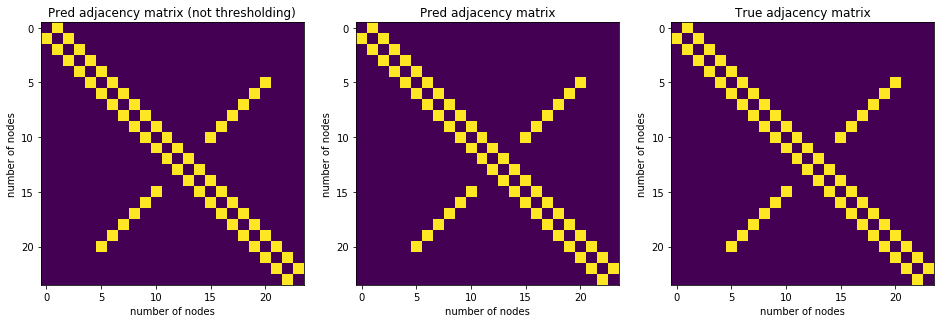

>> test acc :  1.0


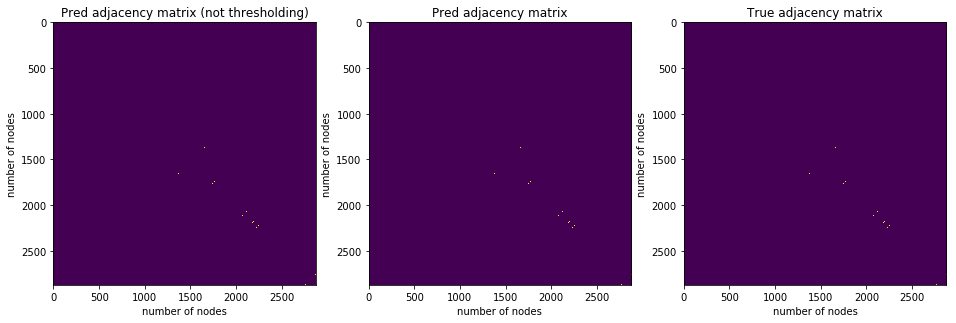

>> test acc :  1.0


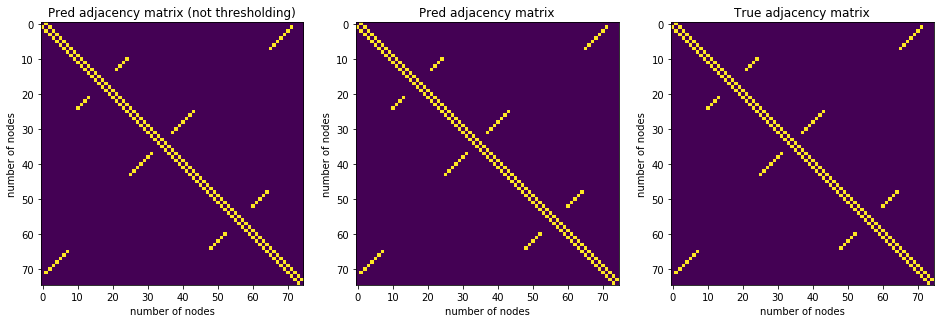

>> test acc :  1.0


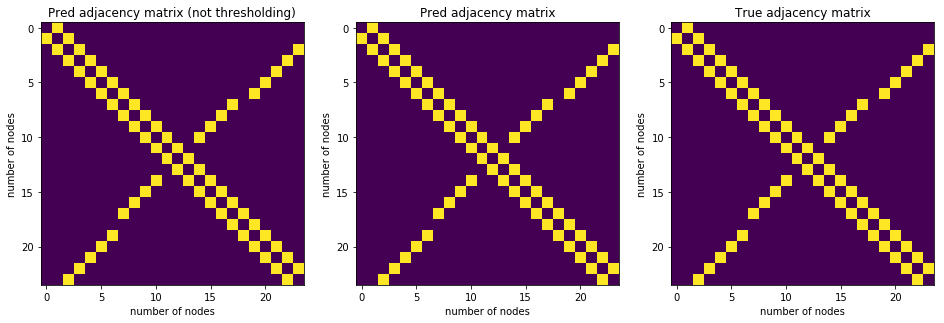

>> test acc :  1.0


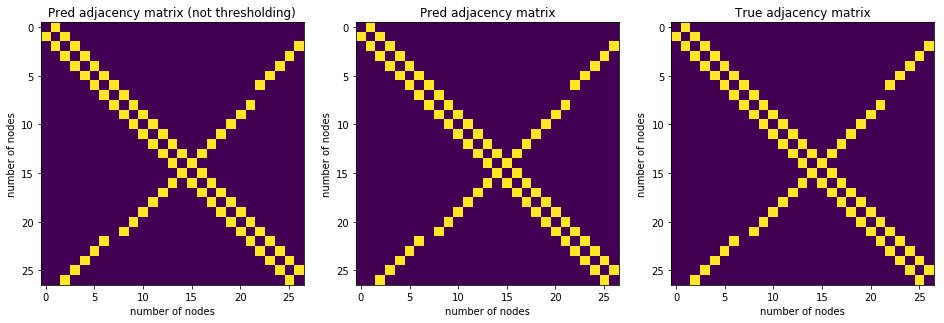

>> test acc :  1.0


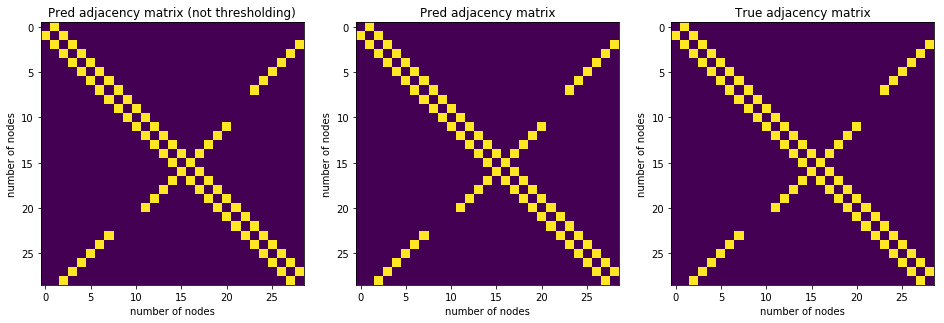

>> test acc :  1.0


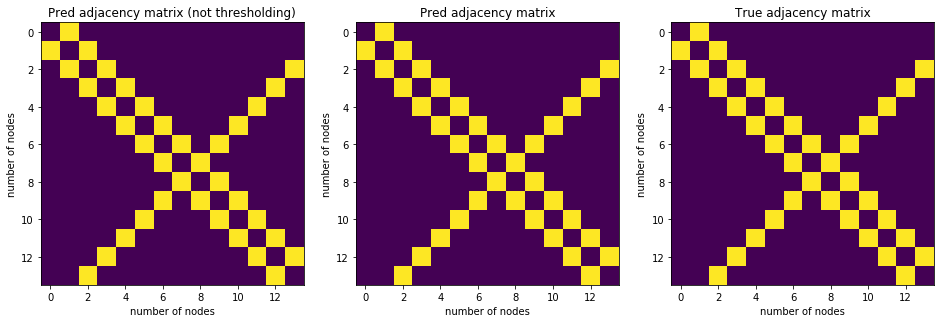

>> test acc :  1.0


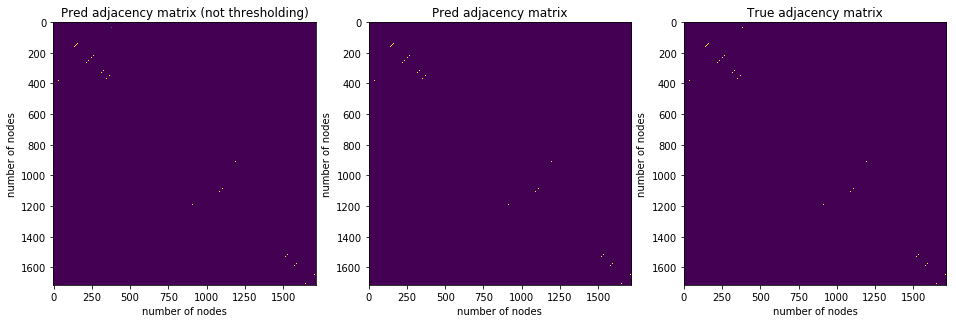

>> test acc :  0.99999636


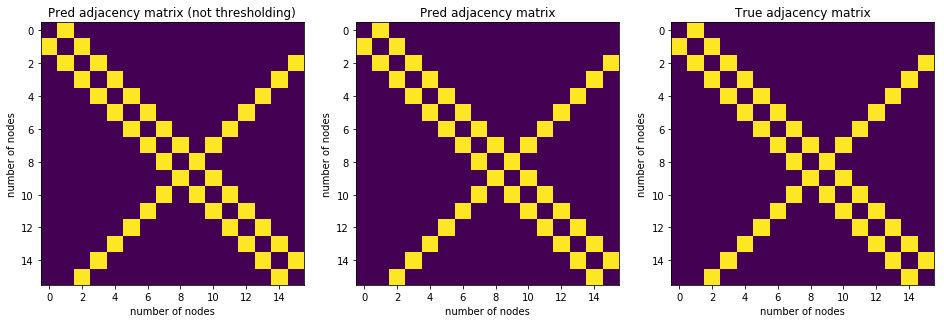

>> test acc :  1.0


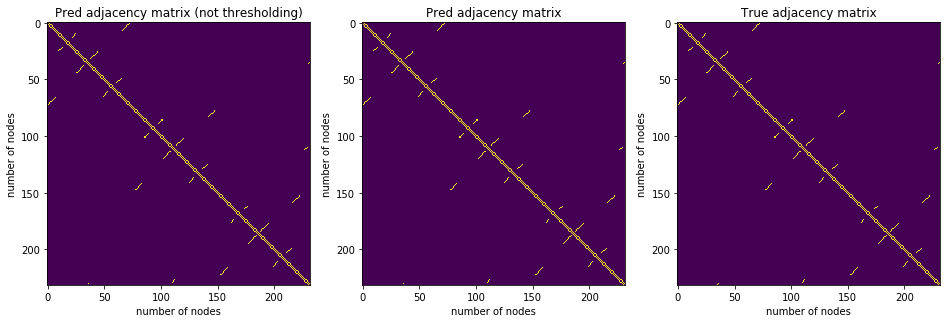

>> test acc :  0.9999999


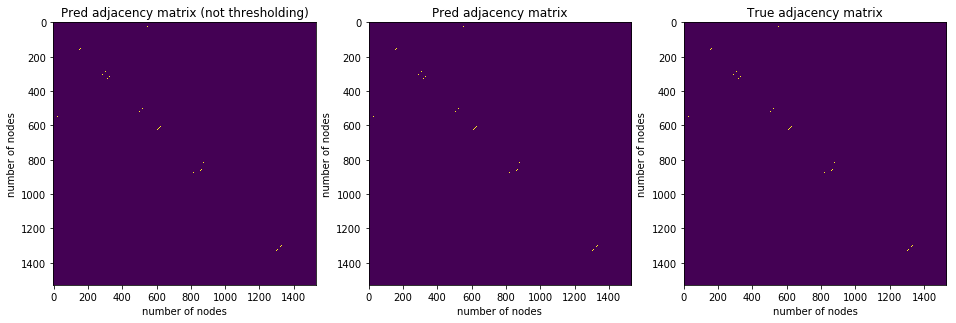

>> test acc :  1.0


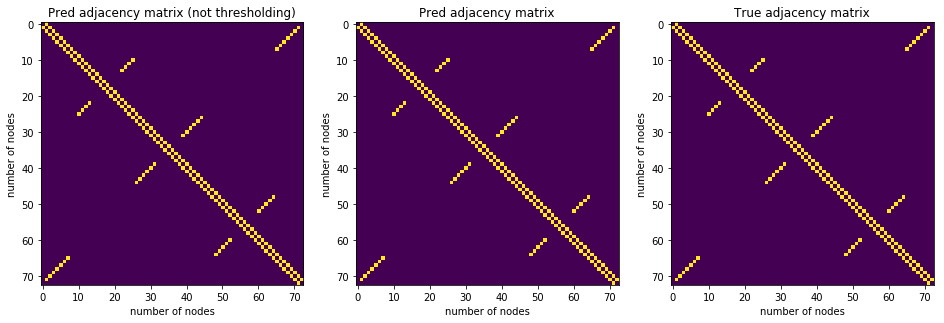

>> test acc :  1.0


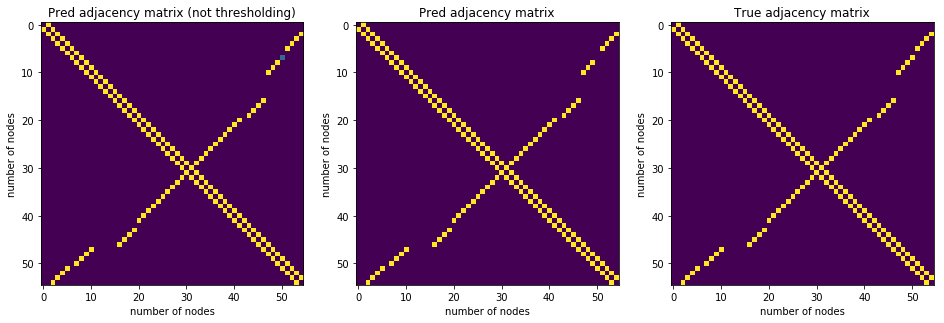

>> test acc :  0.99999994
----------------------------------------------------------------------------------------------------
 
Epoch 1 results
>> average test loss = 0.00660
>> accuray test      = 1.00000
 




In [9]:
EPOCHS = HYPER_PARAMS["epochs"]
test_loss = 1
es_max = 100
ex_cnt = 0

for epoch in range(EPOCHS):
    
    train_rate   = 0.8
    train_len    = int(len(X) * train_rate)
    train_range  = range(0,train_len)
    test_range   = range(train_len,len(X))
    
    # TRAIN
    if not IS_LOAD:
        
        cost_list = []
        acc_list  = []

        for i in train_range:

            Y_tup = sparse_to_tuple(Y[i])

            feed_dict = {
                placeholders["A"]          : Y_tup,
                placeholders["Y"]          : Y_tup,
                placeholders["norm"]       : get_norm(Y[i]),
                placeholders["pos_weight"] : get_pos_weight(Y[i])
            }


            outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

            # Compute average loss
            avg_cost = outs[1]
            avg_accuracy = outs[2]

            cost_list.append(avg_cost)
            acc_list.append(avg_accuracy)

            if i % 50 == 0:
                print("Epoch {} ,batch({}/{}):".format(epoch+1 ,i+1, len(X)),
                      "train_loss={:.5f}".format(avg_cost), 
                      "train_acc={:.5f}".format(avg_accuracy))

        cost_list = np.array(cost_list)
        acc_list  = np.array(acc_list)
        print("-"*100)
        print(" ")
        print("Epoch {} results".format(epoch+1))
        print(">> average train loss = {:.5f}".format(np.mean(cost_list)))
        print(">> accuray train      = {:.5f}".format(np.mean(acc_list)))
        print(" ")
        print("="*100)
    
    
    # TEST 
    cost_list = []
    acc_list  = []
    
    for i in test_range:    
        
        Y_tup = sparse_to_tuple(Y[i])
        
        feed_dict = {
            placeholders["A"]          : Y_tup,
            placeholders["Y"]          : Y_tup,
            placeholders["norm"]       : get_norm(Y[i]),
            placeholders["pos_weight"] : get_pos_weight(Y[i])
        }
        
        outs = sess.run([opt.cost, opt.accuracy, decoder_sigmoid], feed_dict=feed_dict)

        # Compute average loss
        avg_cost     = outs[0]
        avg_accuracy = outs[1]
        
        cost_list.append(avg_cost)
        acc_list.append(avg_accuracy)
        
        if epoch % 2 == 0 and i % 1 == 0:
            
            # predictied result matrix
            P = outs[2]
            view_range = L[i]
            P = P[:view_range,:view_range]
            P_th = P > 0.5
            
            Y_t = Y[i].todense()
            Y_t = Y_t[:view_range,:view_range]
                        
            # for debuging
            plt.figure(figsize=(16,16))
            
            plt.subplot(1,3,1)
            plt.imshow(P)
            plt.title("Pred adjacency matrix (not thresholding)")
            plt.ylabel("number of nodes")
            plt.xlabel("number of nodes")
            
            plt.subplot(1,3,2)
            plt.imshow(P_th)
            plt.title("Pred adjacency matrix")
            plt.ylabel("number of nodes")
            plt.xlabel("number of nodes")
            
            plt.subplot(1,3,3)
            plt.imshow(Y_t)
            plt.title("True adjacency matrix")
            plt.ylabel("number of nodes")
            plt.xlabel("number of nodes")
            
            plt.show()
            
            print(">> test acc : ",avg_accuracy)
            
    
    cost_list = np.array(cost_list)
    acc_list  = np.array(acc_list)
    print("-"*100)
    print(" ")
    print("Epoch {} results".format(epoch+1))
    print(">> average test loss = {:.5f}".format(np.mean(cost_list)))
    print(">> accuray test      = {:.5f}".format(np.mean(acc_list)))
    print(" ")
    print("="*100)
    
    if not IS_LOAD:
        saver.save(sess, checkpoint_path)
        print("model saved")
        
    print('\n')
    
    
    if test_loss >= np.mean(cost_list) :
        test_loss = np.mean(cost_list)
        es_cnt = 0
    else:
        es_cnt += 1
        print("count++")
    
    if es_cnt == es_max:
        print("stop training epoch")
        break
        
    if IS_LOAD: break